In [1]:
import os as os
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy as sc
import scipy.stats as stats
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy as cr
import matplotlib.colors as mcolors
import statistics
import statsmodels.api as sm

kde = sc.stats.gaussian_kde
norm = sc.stats.norm

dpi = 300
mpl.rc('figure',dpi=dpi)
plt.style.use('tableau-colorblind10')
mpl.rc('font',size=9)

In [2]:
scripts_data_folder=os.getcwd()
main_folder_path, scripts_filename = os.path.split(scripts_data_folder)

Raw_data_folder=os.path.join(main_folder_path,'Raw_data')
Raw_data_path, scripts_filename = os.path.split(Raw_data_folder)
WeatherStation_folder = os.path.join(Raw_data_folder,'WeatherStation')
Tide_folder = os.path.join(Raw_data_folder,'TideGauge')
WaterTemp_folder = os.path.join(Raw_data_folder, 'WaterTemp')

Shapefile_folder=os.path.join(main_folder_path,'Shapefiles')
Figures_folder=os.path.join(main_folder_path,'Figures')

In [3]:
os.chdir(Raw_data_folder)

df_AK = pd.read_csv('SoAlaska_icequakes_catalog.csv')
df_AKBC = pd.read_csv('USGS_IQ.csv')
df_USGSneg = pd.read_csv('USGSneg.csv')

def EQpr(df):
    df['time'] = pd.to_datetime((df['time']))
    df.set_index('time',inplace=True)
    df.sort_index(inplace=True)
    df['Mw'] = df['mag']
    df['M0'] = 10**((1.5*df['Mw']+9.105))
    return df

df_EQ_list = [df_AK,df_AKBC,df_USGSneg]
df_EQ_list = [EQpr(df) for df in df_EQ_list]

df_AK['Mw'].replace([0], np.nan, inplace=True)

C:\Users\alexd\AppData\Local\Temp\ipykernel_45080\2798666253.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_AK['Mw'].replace([0], np.nan, inplace=True)


In [4]:
os.chdir(Shapefile_folder)

AKfp = "AK_2020_overall_glacier_covered_area_merc.shp"
AKs = gpd.read_file(AKfp)

gdf_AK = gpd.GeoDataFrame(df_AK, geometry=gpd.points_from_xy(df_AK.longitude, df_AK.latitude), crs='epsg:32662')
gdf_AKBC = gpd.GeoDataFrame(df_AKBC, geometry=gpd.points_from_xy(df_AKBC.longitude, df_AKBC.latitude), crs='epsg:32662')
gdf_USGSneg = gpd.GeoDataFrame(df_USGSneg, geometry=gpd.points_from_xy(df_USGSneg.longitude, df_USGSneg.latitude), crs='epsg:32662')

In [5]:
df_AKBC_cl = df_AKBC.copy().drop(columns = ['magType', 'nst', 'gap', 'dmin', 'rms', 'net', 'id', 'updated', 'place', 'type', 'horizontalError', 'depthError', 'magError', 'magNst', 'status', 'locationSource', 'magSource'])
df_AK_cl = df_AK.copy().drop(columns = ['magType', 'nst', 'gap', 'dmin', 'rms', 'net', 'id', 'updated', 'place', 'type', 'horizontalError', 'depthError', 'magError', 'magNst', 'status', 'locationSource', 'magSource'])

df_AKBC_cl = df_AKBC_cl.dropna()
df_AK_cl = df_AK_cl.dropna()

n_kde_AKBCMw=kde(df_AKBC_cl.Mw)
x_kde_AKBCMw=np.linspace(np.min(df_AKBC_cl.Mw),np.max(df_AKBC_cl.Mw),74)

n_kde_AKMw=kde(df_AK_cl.Mw)
x_kde_AKMw=np.linspace(np.min(df_AK_cl.Mw),np.max(df_AK_cl.Mw),32)

C:\Users\alexd\AppData\Local\Temp\ipykernel_45080\4112342345.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


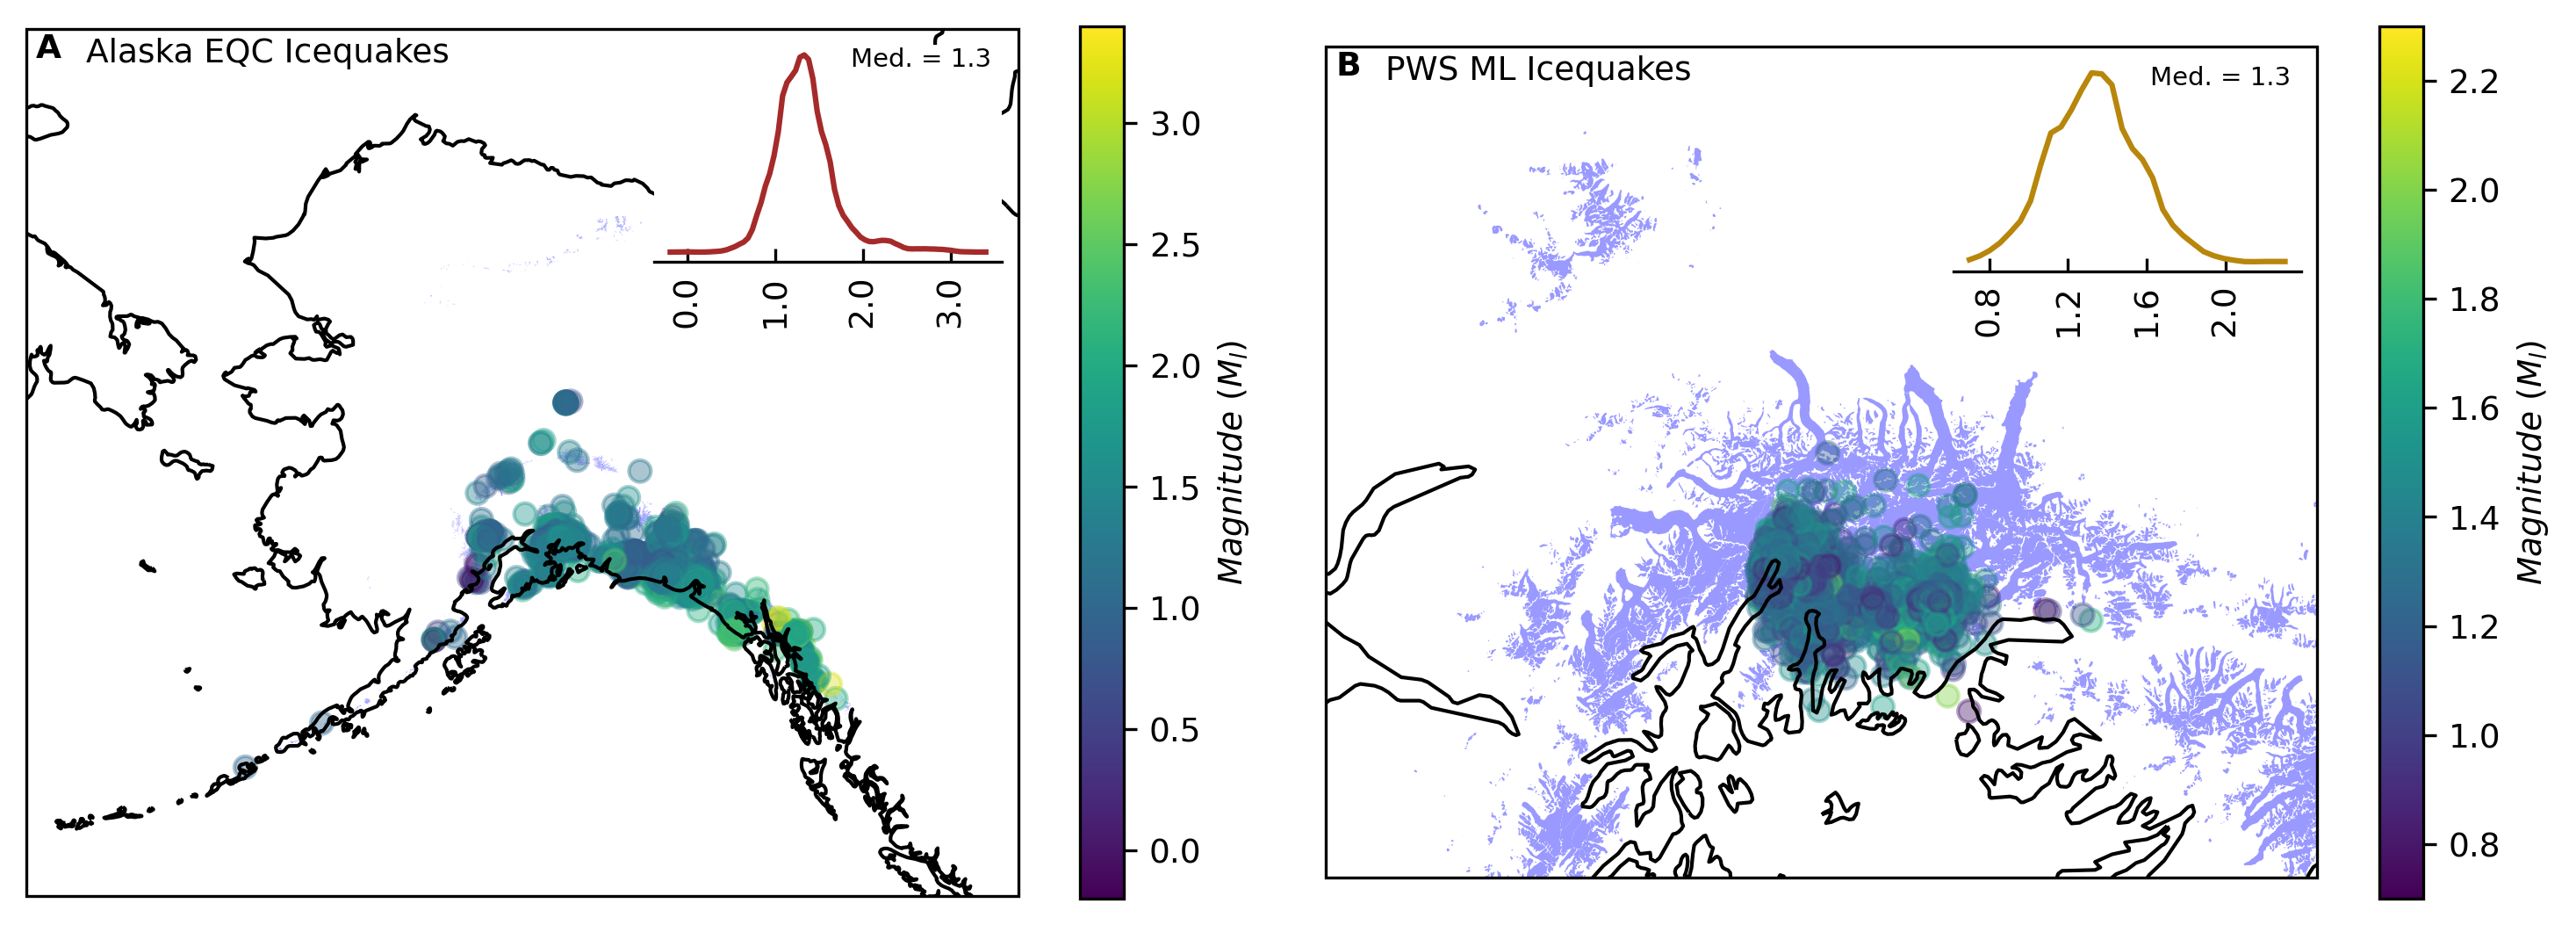

In [6]:
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig = plt.figure(figsize=(10, 5))

gs = GridSpec(1, 2, figure=fig, height_ratios=[10])

axCo = fig.add_subplot(gs[:, 1], projection=ccrs.Mercator())
axCo.coastlines()
AKs.plot(ax=axCo, transform=ccrs.Mercator(), alpha=1, marker = 's', color='#9999FF')
gdf_AK.plot(ax=axCo, transform=ccrs.PlateCarree(), column='Mw', cmap='viridis', legend=True, alpha=0.4, legend_kwds={'label': '$Magnitude$ $(M_l)$', 'shrink':0.7})
axCo.set_extent([-150, -145, 60.5, 62.5], crs=ccrs.PlateCarree())
axCo.text(0.06, 0.99, 'PWS ML Icequakes', horizontalalignment='left', verticalalignment='top', fontsize=9, transform=axCo.transAxes)
axCo.text(0.01, 0.995, 'B', weight='bold', horizontalalignment='left', verticalalignment='top', fontsize=9, transform=axCo.transAxes)

axAK = fig.add_subplot(gs[:, 0], projection=ccrs.Mercator())
axAK.coastlines()
AKs.plot(ax=axAK, transform=ccrs.Mercator(), alpha=1, marker = 's', color='#9999FF')
gdf_AKBC.plot(ax=axAK, transform=ccrs.PlateCarree(), column='Mw', cmap='viridis', legend=True, alpha=0.4, legend_kwds={'label': '$Magnitude$ $(M_l)$', 'shrink':0.7})
axAK.set_extent([-180, -120, 49, 73], crs=ccrs.PlateCarree())
axAK.text(0.06, 0.99, 'Alaska EQC Icequakes', horizontalalignment='left', verticalalignment='top', fontsize=9, transform=axAK.transAxes)
axAK.text(0.01, 0.995, 'A', weight='bold', horizontalalignment='left', verticalalignment='top', fontsize=9, transform=axAK.transAxes)

axkde1 = inset_axes(axAK, width="35%", height="25%", loc='upper right')
axkde1.plot(x_kde_AKBCMw, n_kde_AKBCMw(x_kde_AKBCMw), '-', linewidth=1.5, color='brown')
axkde1.tick_params('x', direction = 'in')
axkde1.tick_params('y', left=False, labelleft=False)
axkde1.set_yticklabels([])
axkde1.spines['right'].set_visible(False)
axkde1.spines['top'].set_visible(False)
axkde1.spines['left'].set_visible(False)
axkde1.set_xticks([0.0, 1.0, 2.0, 3.0])
axkde1.set_xticklabels([0.0, 1.0, 2.0, 3.0])
axkde1.tick_params(axis='x', labelrotation=90, direction='in')
axkde1.text(0.97, 0.99, 'Med. = 1.3', fontsize='7', horizontalalignment='right', verticalalignment='top', transform=axkde1.transAxes)
#axkde1.patch.set_alpha(0)

axkde2 = inset_axes(axCo, width="35%", height="25%", loc='upper right')
axkde2.plot(x_kde_AKMw, n_kde_AKMw(x_kde_AKMw), '-', linewidth=1.5, color='darkgoldenrod')
axkde2.tick_params('x', direction = 'in')
axkde2.tick_params('y', left=False, labelleft=False)
axkde2.set_yticklabels([])
axkde2.spines['right'].set_visible(False)
axkde2.spines['top'].set_visible(False)
axkde2.spines['left'].set_visible(False)
axkde2.set_xticks([0.8, 1.2, 1.6, 2])
axkde2.set_xticklabels([0.8, 1.2, 1.6, 2.0])
axkde2.tick_params(axis='x', labelrotation=90, direction='in')
axkde2.text(0.97, 0.99, 'Med. = 1.3', fontsize='7', horizontalalignment='right', verticalalignment='top', transform=axkde2.transAxes)
#axkde2.patch.set_alpha(0)

plt.tight_layout() 

os.chdir(Figures_folder)
plt.savefig('AKIcequakeLogMl.png', bbox_inches='tight')

#print(statistics.median(df_AKBC_cl['Mw']))
#print(statistics.median(df_AK_cl['Mw']))

In [7]:
os.chdir(Shapefile_folder)

gdf_AKGr = gpd.read_file('AKGlacierRegions.geojson')

gdf_AKBC = gpd.GeoDataFrame(df_AKBC, geometry=gpd.points_from_xy(df_AKBC.longitude, df_AKBC.latitude), crs='epsg:4326')

regAKBC_gdf = gpd.sjoin(gdf_AKBC, gdf_AKGr[['Name', 'geometry']], how='left', predicate='within')
regAKBC_gdf = regAKBC_gdf.drop(columns=['index_right'])
#regAKBC_gdf['Name'].fillna('Outside', inplace=True)
regAKBC_gdf['Name'].dropna(inplace=True)

df_AKBC['Region'] = regAKBC_gdf['Name']
#df_AKBC['Region'].fillna('Outside', inplace=True)
df_AKBC['Region'].dropna(inplace=True)

print(df_AKBC['Region'].value_counts())

Region
St. Elias/Disenchantment Bay    8420
Chugach                         5629
Stikine Icefield                 786
Glacier Bay/Fairweather          511
Alaska Range                     266
Wrangell                         191
Kenai                            134
Juneau Icefield                   10
Name: count, dtype: int64


In [8]:
df_StDis = df_AKBC[df_AKBC['Region'] == 'St. Elias/Disenchantment Bay'].copy()
df_Chugach = df_AKBC[df_AKBC['Region'] == 'Chugach'].copy()
df_Stik = df_AKBC[df_AKBC['Region'] == 'Stikine Icefield'].copy()
df_GlBFair = df_AKBC[df_AKBC['Region'] == 'Glacier Bay/Fairweather'].copy()
df_AlRng = df_AKBC[df_AKBC['Region'] == 'Alaska Range'].copy()
df_Wran = df_AKBC[df_AKBC['Region'] == 'Wrangell'].copy()
df_Ken = df_AKBC[df_AKBC['Region'] == 'Kenai'].copy()
df_JunIce = df_AKBC[df_AKBC['Region'] == 'Juneau Icefield'].copy()

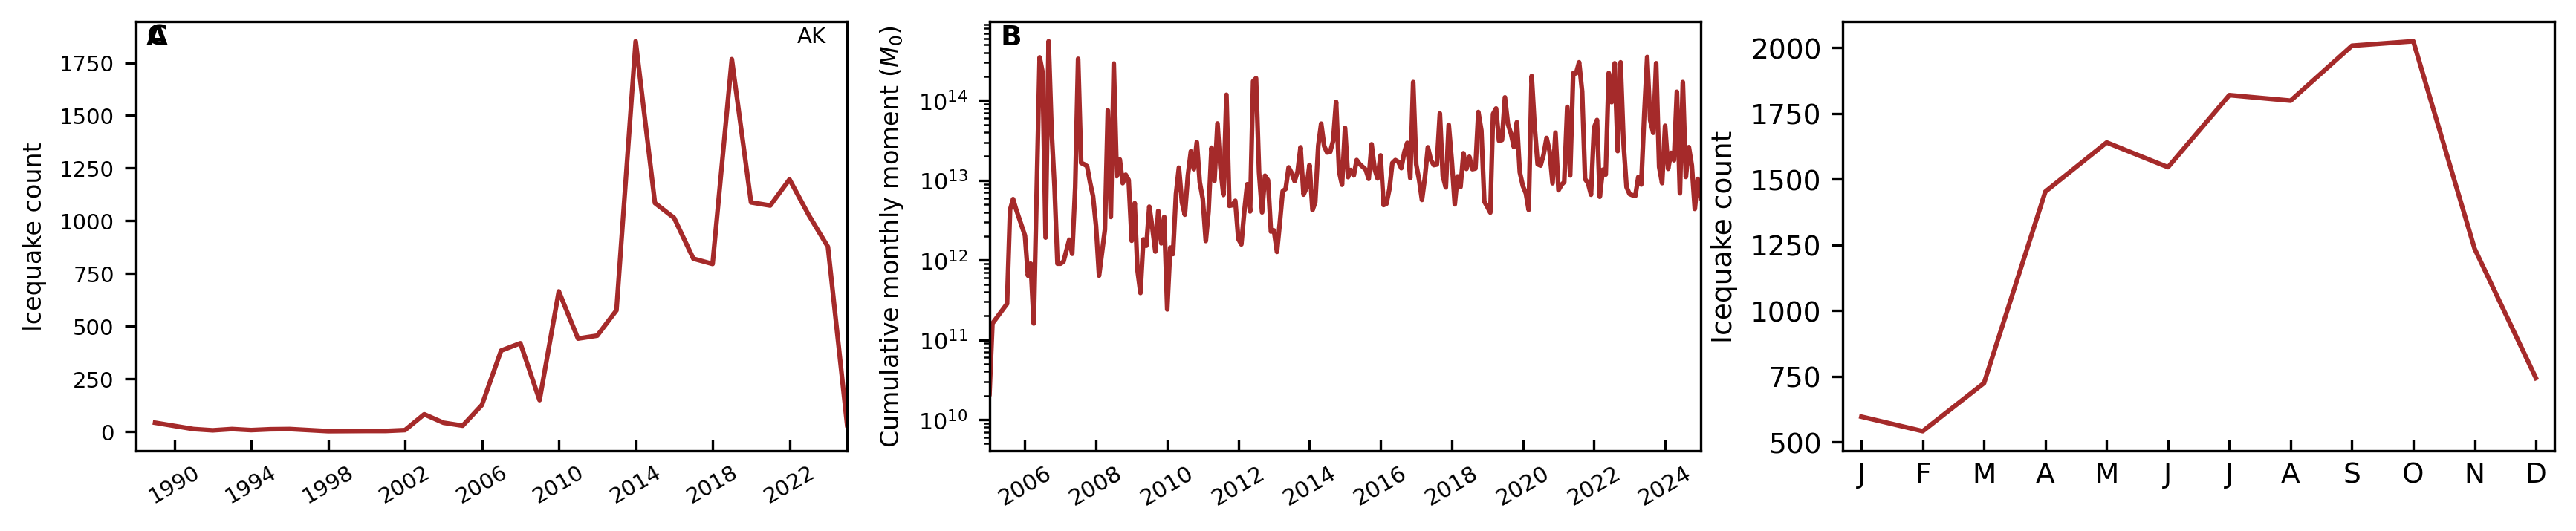

In [9]:
fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(14, 2.5))

ax1.plot(df_AKBC.groupby(df_AKBC.index.year).size(),color='brown')
ax1.tick_params(axis='x', labelrotation=30, direction='in')
ax1.set_xticks([1990, 1994, 1998, 2002, 2006, 2010, 2014, 2018, 2022])
ax1.set_xlim(1988,2025)
ax1.set_ylabel('Icequake count',fontsize = 8)
ax1.tick_params(axis='both', labelsize=7)  
ax1.text(0.97, 0.99, 'AK', fontsize='7', horizontalalignment='right', verticalalignment='top', transform=ax1.transAxes)
ax1.text(0.015, 0.995, 'A', weight='bold', horizontalalignment='left', verticalalignment='top', fontsize=9, transform=ax1.transAxes)

df_AKBC.index = df_AKBC.index.tz_localize(None)

ax2.plot(df_AKBC.groupby(df_AKBC.index.to_period('M'))['M0'].sum().index.to_timestamp(), 
         df_AKBC.groupby(df_AKBC.index.to_period('M'))['M0'].sum(), color='brown')
ax2.set_yscale('log')
ax2.tick_params(axis='x', labelrotation=30, direction='in')
ax2.set_xlim(pd.Timestamp('2005-01-01'),pd.Timestamp('2025-01-01'))
ax2.set_ylabel('Cumulative monthly moment $(M_0)$', fontsize=8)
ax2.tick_params(axis='both', labelsize=7.25)  
#ax2.text(0.97, 0.99, 'AK', fontsize='7', horizontalalignment='right', verticalalignment='top', transform=ax2.transAxes)
ax2.text(0.015, 0.995, 'B', weight='bold', horizontalalignment='left', verticalalignment='top', fontsize=9, transform=ax2.transAxes)

ax3.plot(df_AKBC.groupby(df_AKBC.index.month).size(),color='brown')
ax3.set_ylabel('Icequake count')
ax3.tick_params(axis='x', direction='in')
#ax1.set_ylim(0,2100)
ax3.set_xlim(0.7,12.3)
ax3.set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
ax3.set_xticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])
#ax3.text(0.97, 0.99, 'AK', fontsize='7', horizontalalignment='right', verticalalignment='top', transform=ax1.transAxes)
ax3.text(0.015, 0.995, 'C', weight='bold', horizontalalignment='left', verticalalignment='top', fontsize=9, transform=ax1.transAxes)

os.chdir(Figures_folder)
plt.savefig('AKBCIqMomentMonthly.png', bbox_inches='tight')

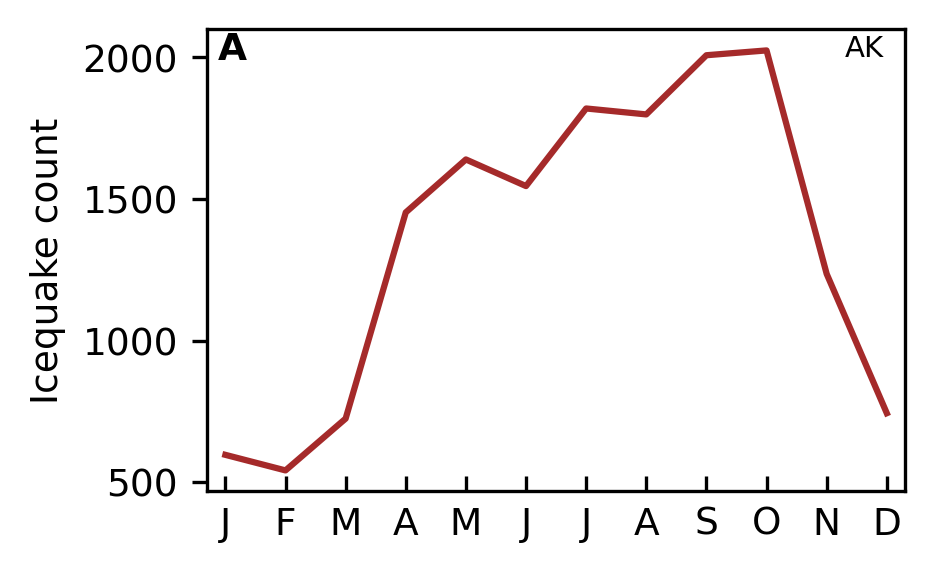

In [10]:
fig, ((ax1)) = plt.subplots(1, 1, figsize=(3, 2))

ax1.plot(df_AKBC.groupby(df_AKBC.index.month).size(),color='brown')
ax1.set_ylabel('Icequake count')
ax1.tick_params(axis='x', direction='in')
#ax1.set_ylim(0,2100)
ax1.set_xlim(0.7,12.3)
ax1.set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
ax1.set_xticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])
ax1.text(0.97, 0.99, 'AK', fontsize='7', horizontalalignment='right', verticalalignment='top', transform=ax1.transAxes)
ax1.text(0.015, 0.995, 'A', weight='bold', horizontalalignment='left', verticalalignment='top', fontsize=9, transform=ax1.transAxes)

os.chdir(Figures_folder)
plt.savefig('AKBCIQMonthlycount.png', bbox_inches='tight')

In [11]:
AKBC_Mw_round = round(df_AKBC.Mw, 1)

print(AKBC_Mw_round.min())
print(AKBC_Mw_round.max())

AKBC_Mw_bins = [i/10.0 for i in range(-2, 34)] 
AKBC_Mw_binned = pd.cut(AKBC_Mw_round, bins = AKBC_Mw_bins)

AKBC_N_list = []
AKBC_Mw_bin_upper_list = []

for i in range(len(AKBC_Mw_bins) - 1):
    AKBC_Mw_bin_lower = AKBC_Mw_bins[i]
    AKBC_Mw_bin_upper = AKBC_Mw_bins[i+1]
    AKBC_N = AKBC_Mw_round[AKBC_Mw_round >= AKBC_Mw_bin_upper].count()
    AKBC_N_list.append(AKBC_N)
    AKBC_Mw_bin_upper_list.append(AKBC_Mw_bin_upper)

logN_AKBC= np.log10(AKBC_N_list)

AKBC_bin1 = np.array(AKBC_Mw_bin_upper_list[:12])
AKBC_bin2 = np.array(AKBC_Mw_bin_upper_list[12:30])
AKBC_bin3 = np.array(AKBC_Mw_bin_upper_list[30:])

AKBC_N1 = np.array(logN_AKBC[:12])
AKBC_N2 = np.array(logN_AKBC[12:30])
AKBC_N3 = np.array(logN_AKBC[30:])

slope, intercept, r_value, p_value, std_err = stats.linregress(AKBC_Mw_bin_upper_list,logN_AKBC)
print(slope, intercept, r_value, p_value, std_err)

AKBC_stat1 = stats.linregress(AKBC_bin1,AKBC_N1)
AKBC_stat2 = stats.linregress(AKBC_bin2,AKBC_N2)
AKBC_stat3 = stats.linregress(AKBC_bin3,AKBC_N3)

#print(AKBC_stat1)
print(AKBC_stat2)
print(AKBC_stat3)

-0.2
3.4
-1.023700962332554 4.8194948248109934 -0.9402667128959484 5.270044472937525e-17 0.06452143291220394
LinregressResult(slope=-1.27399293947866, intercept=5.549223438944075, rvalue=-0.9969354428515511, pvalue=3.873799395948515e-19, stderr=0.024992279460486728, intercept_stderr=0.050430349356277125)
LinregressResult(slope=-3.4097453203091677, intercept=11.725805992526032, rvalue=-0.9961256771623758, pvalue=0.00028931770865961074, stderr=0.17379569856562233, intercept_stderr=0.5393270054506439)


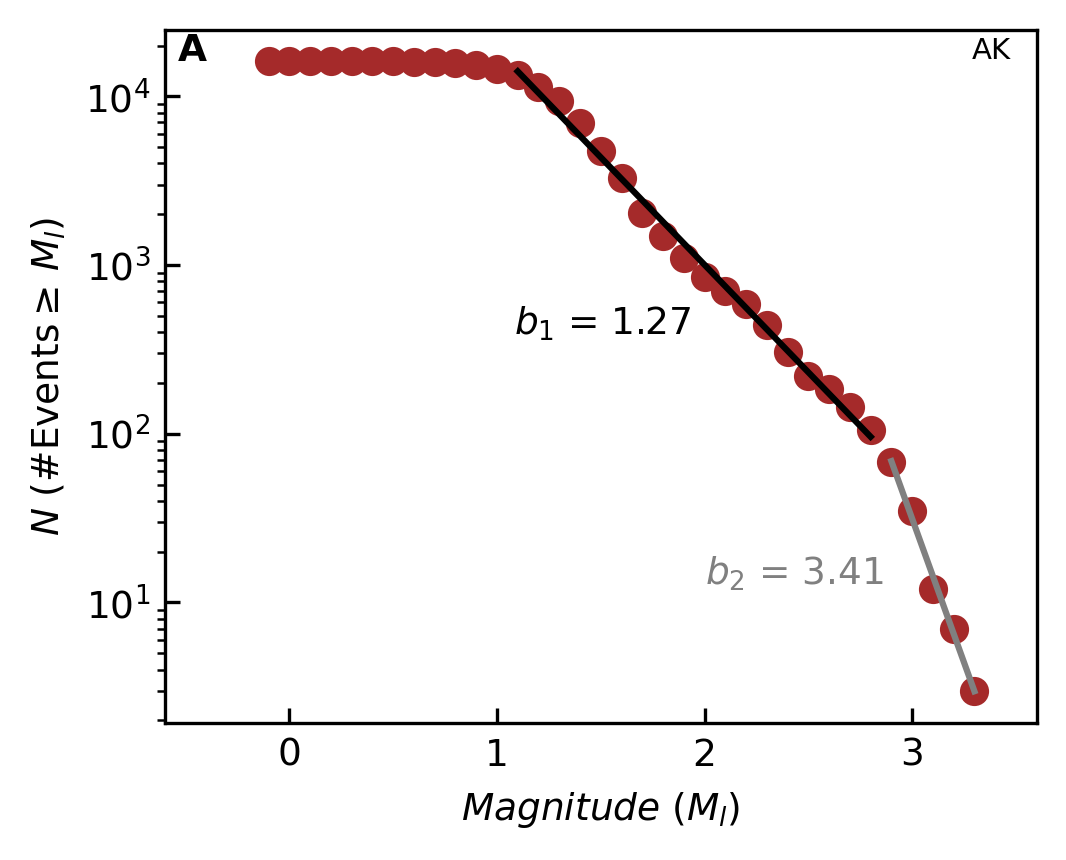

In [12]:
fig, (ax1) = plt.subplots(1, 1, figsize=(3.75, 3))

ax1.scatter(AKBC_Mw_bin_upper_list, AKBC_N_list, color='brown')
ax1.set_yscale('log')
ax1.plot(AKBC_bin2, 10**(AKBC_stat2.intercept + AKBC_stat2.slope*AKBC_bin2), color='black')
ax1.plot(AKBC_bin3, 10**(AKBC_stat3.intercept + AKBC_stat3.slope*AKBC_bin3), color='grey')
ax1.set_xlabel('$Magnitude$ $(M_l)$')
ax1.set_ylabel(r'$N$ $(\#\text{Events} \geq \, M_l)$')
ax1.set_xlim(-0.6,3.6)
ax1.tick_params('both', direction = 'in')
ax1.text(0.97, 0.99, 'AK', fontsize='7', horizontalalignment='right', verticalalignment='top', transform=ax1.transAxes)
ax1.text(0.015, 0.995, 'A', weight='bold', horizontalalignment='left', verticalalignment='top', fontsize=9, transform=ax1.transAxes)
ax1.text(0.4, 0.56, '$b_1$ = 1.27', transform=ax1.transAxes, color='black')
ax1.text(0.62, 0.2, '$b_2$ = 3.41', transform=ax1.transAxes, color='grey')

os.chdir(Figures_folder)
plt.savefig('AKBCEqGutRich.png', bbox_inches='tight')

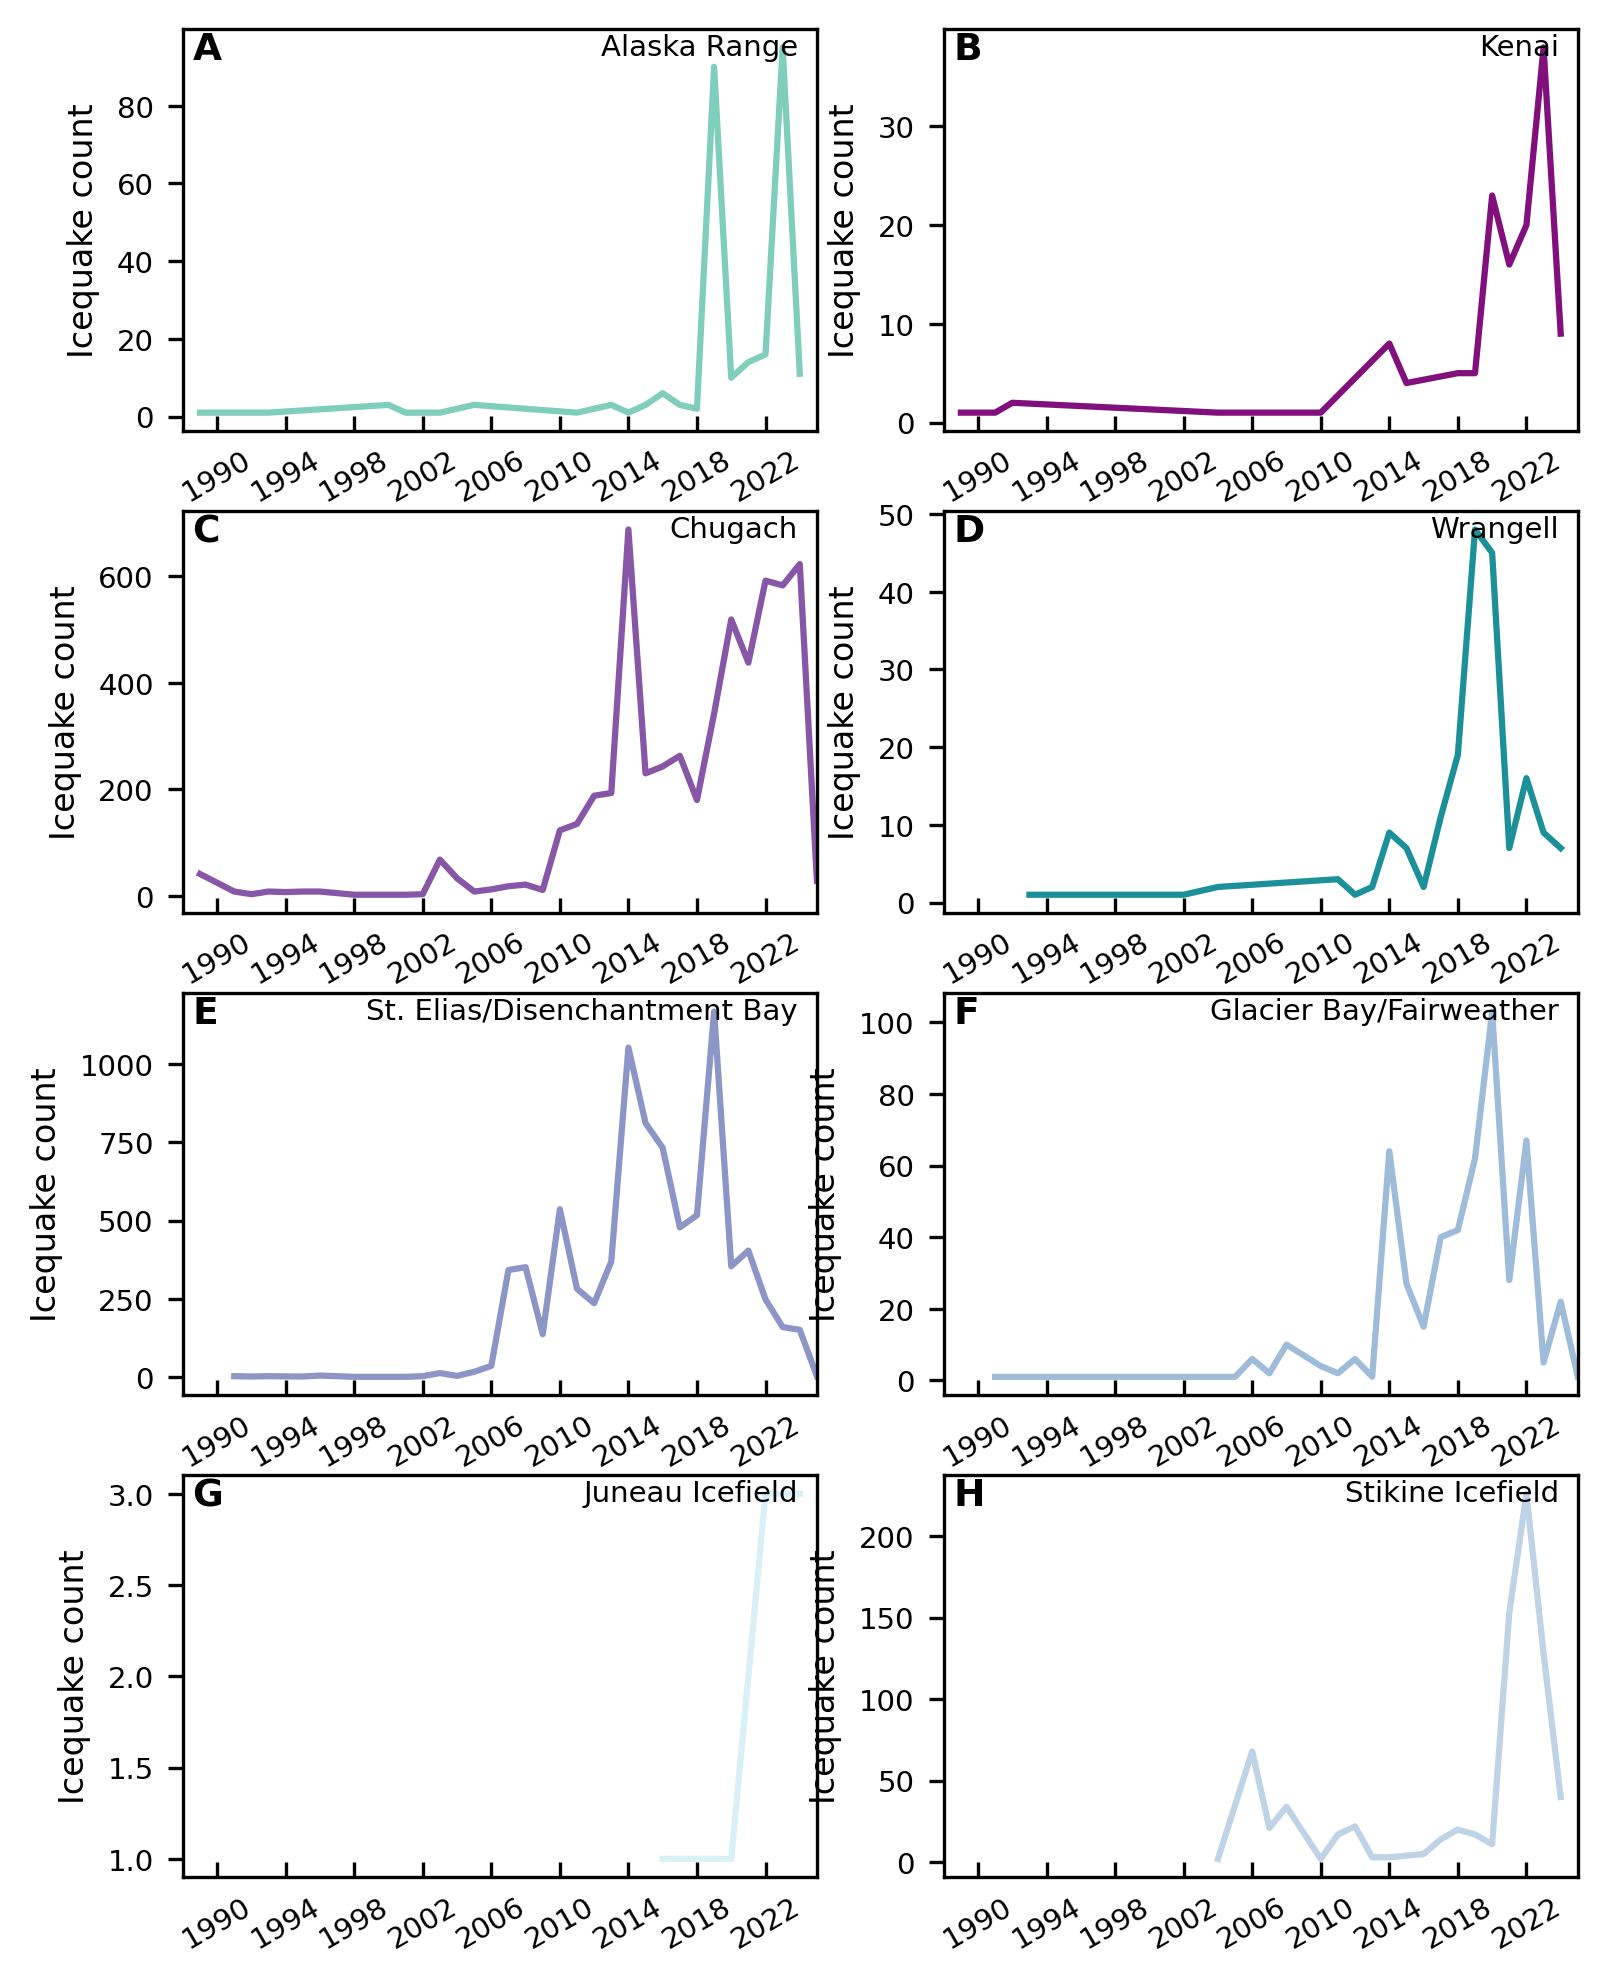

In [13]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7,ax8)) = plt.subplots(4, 2, figsize=(6, 8))

ax1.plot(df_AlRng.groupby(df_AlRng.index.year).size(),color='#7fcdbb')
ax1.tick_params(axis='x', labelrotation=30, direction='in')
ax1.set_xticks([1990, 1994, 1998, 2002, 2006, 2010, 2014, 2018, 2022])
ax1.set_xlim(1988,2025)
ax1.set_ylabel('Icequake count',fontsize = 8)
ax1.tick_params(axis='both', labelsize=7)  
ax1.text(0.97, 0.99, 'Alaska Range', fontsize='7', horizontalalignment='right', verticalalignment='top', transform=ax1.transAxes)
ax1.text(0.015, 0.995, 'A', weight='bold', horizontalalignment='left', verticalalignment='top', fontsize=9, transform=ax1.transAxes)

ax2.plot(df_Ken.groupby(df_Ken.index.year).size(),color='#810f7c')
ax2.tick_params(axis='x', labelrotation=30, direction='in')
ax2.set_xticks([1990, 1994, 1998, 2002, 2006, 2010, 2014, 2018, 2022])
ax2.set_xlim(1988,2025)
ax2.set_ylabel('Icequake count',fontsize = 8)
ax2.tick_params(axis='both', labelsize=7)  
ax2.text(0.97, 0.99, 'Kenai', fontsize='7', horizontalalignment='right', verticalalignment='top', transform=ax2.transAxes)
ax2.text(0.015, 0.995, 'B', weight='bold', horizontalalignment='left', verticalalignment='top', fontsize=9, transform=ax2.transAxes)

ax3.plot(df_Chugach.groupby(df_Chugach.index.year).size(),color='#8856a7')
ax3.tick_params(axis='x', labelrotation=30, direction='in')
ax3.set_xticks([1990, 1994, 1998, 2002, 2006, 2010, 2014, 2018, 2022])
ax3.set_xlim(1988,2025)
ax3.set_ylabel('Icequake count',fontsize = 8)
ax3.tick_params(axis='both', labelsize=7)  
ax3.text(0.97, 0.99, 'Chugach', fontsize='7', horizontalalignment='right', verticalalignment='top', transform=ax3.transAxes)
ax3.text(0.015, 0.995, 'C', weight='bold', horizontalalignment='left', verticalalignment='top', fontsize=9, transform=ax3.transAxes)

ax4.plot(df_Wran.groupby(df_Wran.index.year).size(),color='#1c9099')
ax4.tick_params(axis='x', labelrotation=30, direction='in')
ax4.set_xticks([1990, 1994, 1998, 2002, 2006, 2010, 2014, 2018, 2022])
ax4.set_xlim(1988,2025)
ax4.set_ylabel('Icequake count',fontsize = 8)
ax4.tick_params(axis='both', labelsize=7)  
ax4.text(0.97, 0.99, 'Wrangell', fontsize='7', horizontalalignment='right', verticalalignment='top', transform=ax4.transAxes)
ax4.text(0.015, 0.995, 'D', weight='bold', horizontalalignment='left', verticalalignment='top', fontsize=9, transform=ax4.transAxes)

ax5.plot(df_StDis.groupby(df_StDis.index.year).size(),color='#8c96c6')
ax5.tick_params(axis='x', labelrotation=30, direction='in')
ax5.set_xticks([1990, 1994, 1998, 2002, 2006, 2010, 2014, 2018, 2022])
ax5.set_xlim(1988,2025)
ax5.set_ylabel('Icequake count',fontsize = 8)
ax5.tick_params(axis='both', labelsize=7)  
ax5.text(0.97, 0.99, 'St. Elias/Disenchantment Bay', fontsize='7', horizontalalignment='right', verticalalignment='top', transform=ax5.transAxes)
ax5.text(0.015, 0.995, 'E', weight='bold', horizontalalignment='left', verticalalignment='top', fontsize=9, transform=ax5.transAxes)

ax6.plot(df_GlBFair.groupby(df_GlBFair.index.year).size(),color='#9ebcda')
ax6.tick_params(axis='x', labelrotation=30, direction='in')
ax6.set_xticks([1990, 1994, 1998, 2002, 2006, 2010, 2014, 2018, 2022])
ax6.set_xlim(1988,2025)
ax6.set_ylabel('Icequake count',fontsize = 8)
ax6.tick_params(axis='both', labelsize=7)  
ax6.text(0.97, 0.99, 'Glacier Bay/Fairweather', fontsize='7', horizontalalignment='right', verticalalignment='top', transform=ax6.transAxes)
ax6.text(0.015, 0.995, 'F', weight='bold', horizontalalignment='left', verticalalignment='top', fontsize=9, transform=ax6.transAxes)

ax7.plot(df_JunIce.groupby(df_JunIce.index.year).size(),color='#d8f0f6')
ax7.tick_params(axis='x', labelrotation=30, direction='in')
ax7.set_xticks([1990, 1994, 1998, 2002, 2006, 2010, 2014, 2018, 2022])
ax7.set_xlim(1988,2025)
ax7.set_ylabel('Icequake count',fontsize = 8)
ax7.tick_params(axis='both', labelsize=7)  
ax7.text(0.97, 0.99, 'Juneau Icefield', fontsize='7', horizontalalignment='right', verticalalignment='top', transform=ax7.transAxes)
ax7.text(0.015, 0.995, 'G', weight='bold', horizontalalignment='left', verticalalignment='top', fontsize=9, transform=ax7.transAxes)

ax8.plot(df_Stik.groupby(df_Stik.index.year).size(),color='#bfd3e6')
ax8.tick_params(axis='x', labelrotation=30, direction='in')
ax8.set_xticks([1990, 1994, 1998, 2002, 2006, 2010, 2014, 2018, 2022])
ax8.set_xlim(1988,2025)
ax8.set_ylabel('Icequake count',fontsize = 8)
ax8.tick_params(axis='both', labelsize=7)  
ax8.text(0.97, 0.99, 'Stikine Icefield', fontsize='7', horizontalalignment='right', verticalalignment='top', transform=ax8.transAxes)
ax8.text(0.015, 0.995, 'H', weight='bold', horizontalalignment='left', verticalalignment='top', fontsize=9, transform=ax8.transAxes)

os.chdir(Figures_folder)
plt.savefig('AKregionsYearCount.png', bbox_inches='tight')

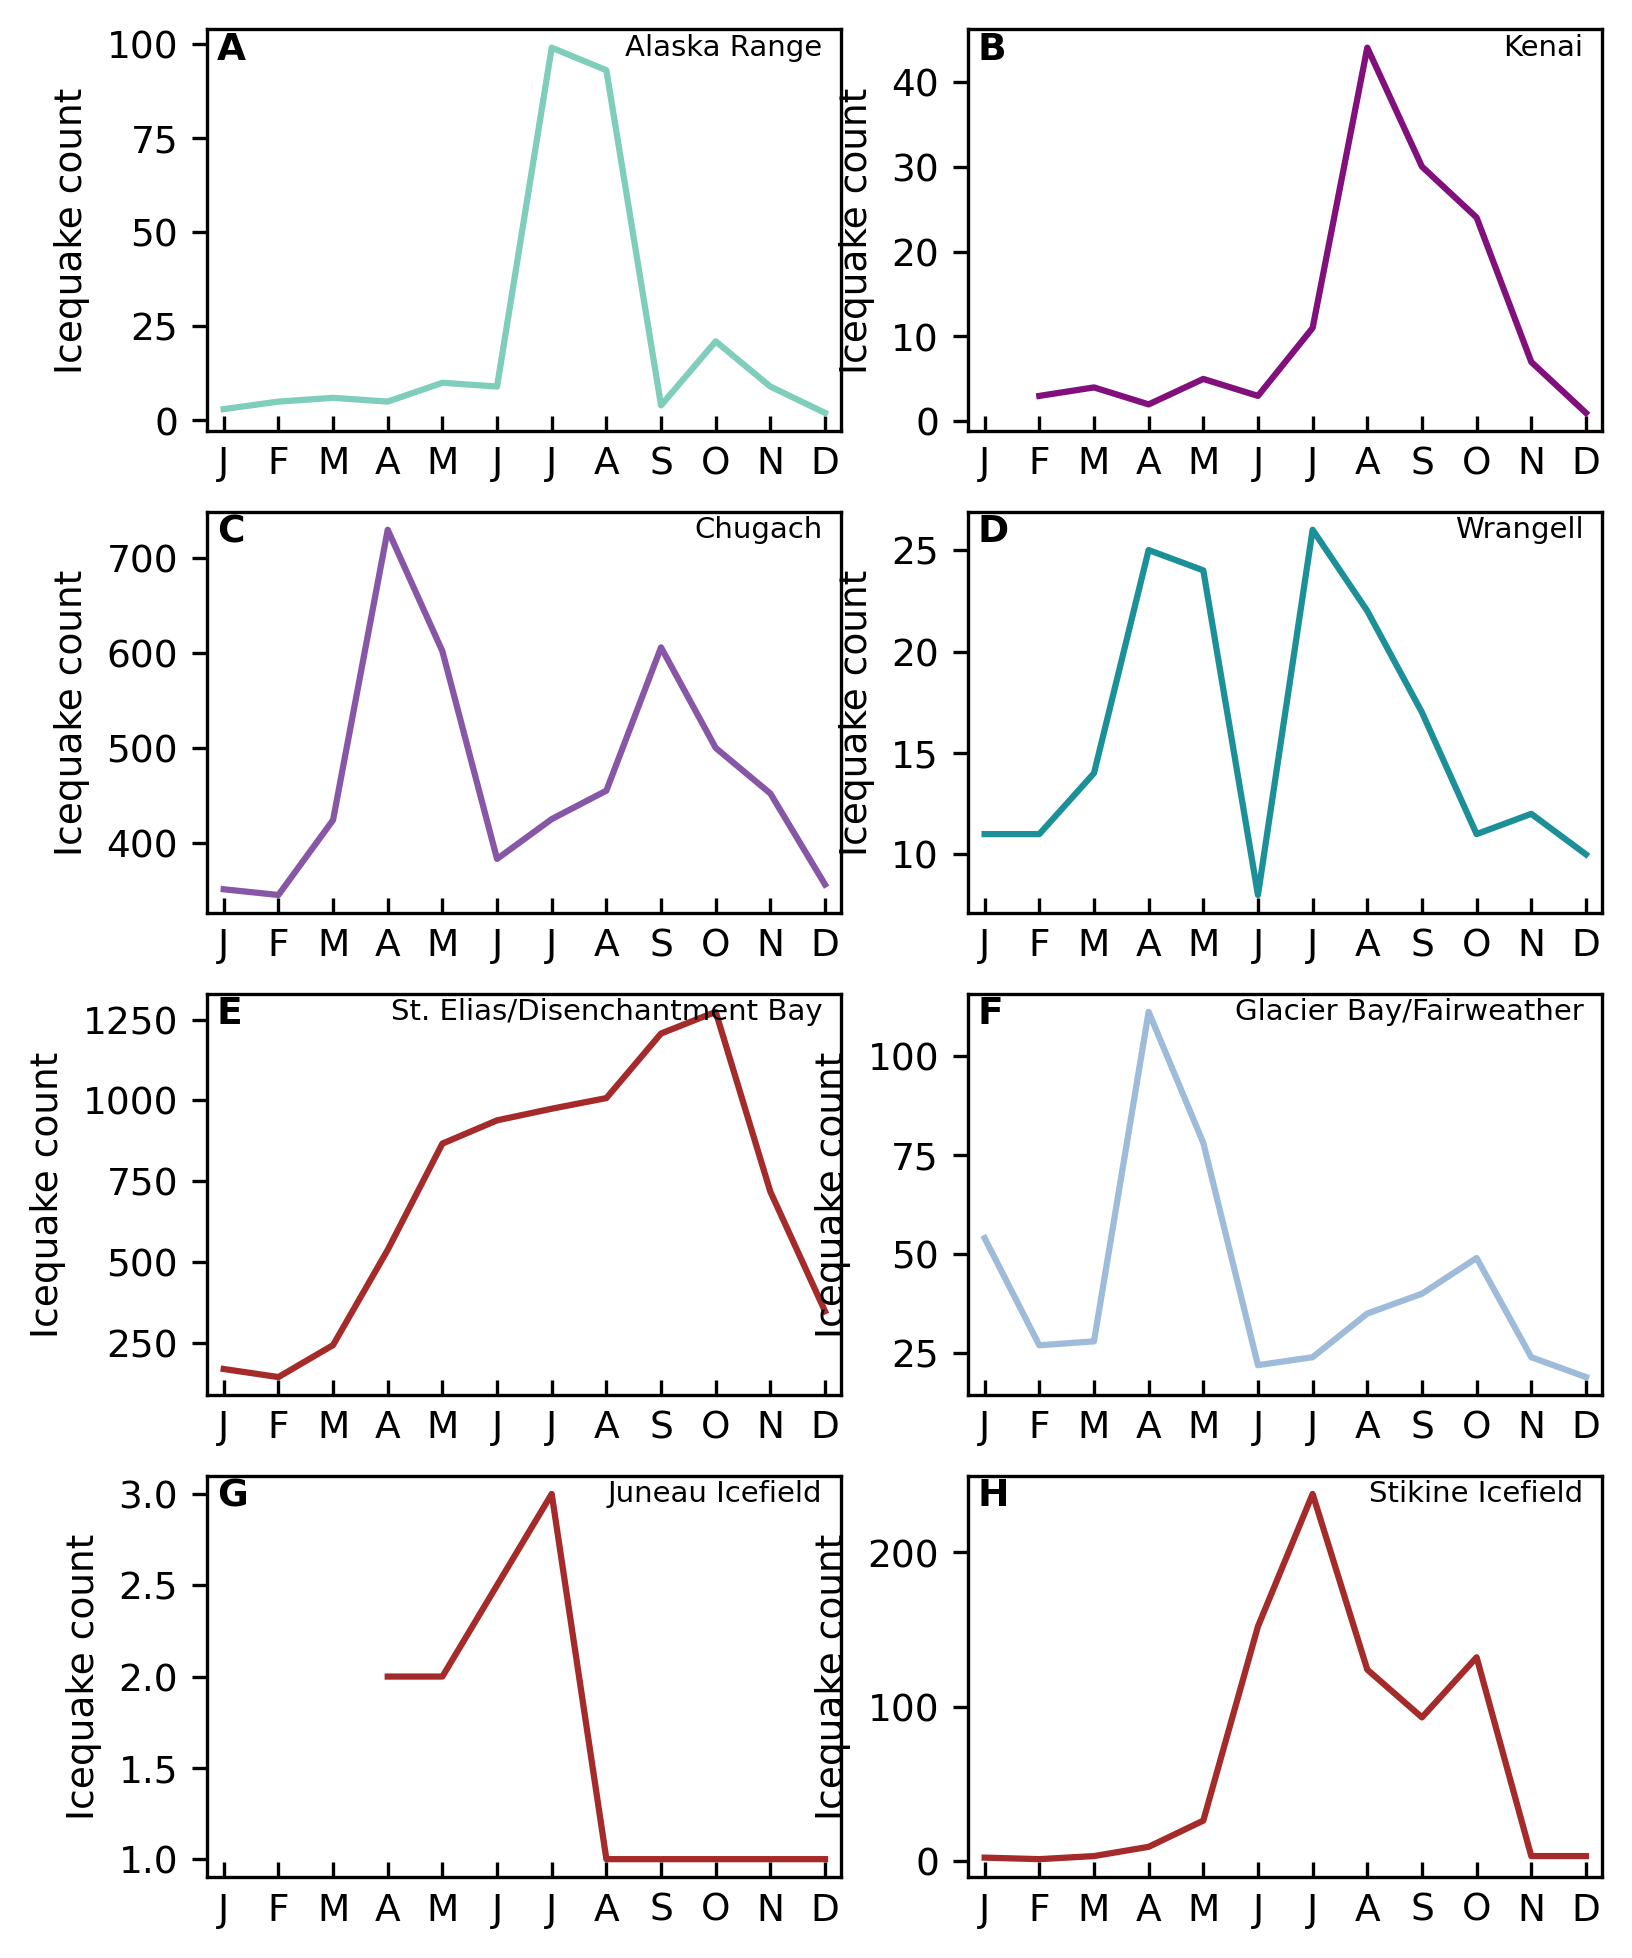

In [14]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7,ax8)) = plt.subplots(4, 2, figsize=(6, 8))

ax1.plot(df_AlRng.groupby(df_AlRng.index.month).size(),color='#7fcdbb')
ax1.set_ylabel('Icequake count')
ax1.tick_params(axis='x', direction='in')
#ax1.set_ylim(0,2100)
ax1.set_xlim(0.7,12.3)
ax1.set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
ax1.set_xticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])
ax1.text(0.97, 0.99, 'Alaska Range', fontsize='7', horizontalalignment='right', verticalalignment='top', transform=ax1.transAxes)
ax1.text(0.015, 0.995, 'A', weight='bold', horizontalalignment='left', verticalalignment='top', fontsize=9, transform=ax1.transAxes)

ax2.plot(df_Ken.groupby(df_Ken.index.month).size(),color='#810f7c')
ax2.set_ylabel('Icequake count')
ax2.tick_params(axis='x', direction='in')
#ax1.set_ylim(0,2100)
ax2.set_xlim(0.7,12.3)
ax2.set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
ax2.set_xticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])
ax2.text(0.97, 0.99, 'Kenai', fontsize='7', horizontalalignment='right', verticalalignment='top', transform=ax2.transAxes)
ax2.text(0.015, 0.995, 'B', weight='bold', horizontalalignment='left', verticalalignment='top', fontsize=9, transform=ax2.transAxes)

ax3.plot(df_Chugach.groupby(df_Chugach.index.month).size(),color='#8856a7')
ax3.set_ylabel('Icequake count')
ax3.tick_params(axis='x', direction='in')
#ax1.set_ylim(0,2100)
ax3.set_xlim(0.7,12.3)
ax3.set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
ax3.set_xticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])
ax3.text(0.97, 0.99, 'Chugach', fontsize='7', horizontalalignment='right', verticalalignment='top', transform=ax3.transAxes)
ax3.text(0.015, 0.995, 'C', weight='bold', horizontalalignment='left', verticalalignment='top', fontsize=9, transform=ax3.transAxes)

ax4.plot(df_Wran.groupby(df_Wran.index.month).size(),color='#1c9099')
ax4.set_ylabel('Icequake count')
ax4.tick_params(axis='x', direction='in')
#ax1.set_ylim(0,2100)
ax4.set_xlim(0.7,12.3)
ax4.set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
ax4.set_xticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])
ax4.text(0.97, 0.99, 'Wrangell', fontsize='7', horizontalalignment='right', verticalalignment='top', transform=ax4.transAxes)
ax4.text(0.015, 0.995, 'D', weight='bold', horizontalalignment='left', verticalalignment='top', fontsize=9, transform=ax4.transAxes)

ax5.plot(df_StDis.groupby(df_StDis.index.month).size(),color='brown')
ax5.set_ylabel('Icequake count')
ax5.tick_params(axis='x', direction='in')
#ax1.set_ylim(0,2100)
ax5.set_xlim(0.7,12.3)
ax5.set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
ax5.set_xticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])
ax5.text(0.97, 0.99, 'St. Elias/Disenchantment Bay', fontsize='7', horizontalalignment='right', verticalalignment='top', transform=ax5.transAxes)
ax5.text(0.015, 0.995, 'E', weight='bold', horizontalalignment='left', verticalalignment='top', fontsize=9, transform=ax5.transAxes)

ax6.plot(df_GlBFair.groupby(df_GlBFair.index.month).size(),color='#9ebcda')
ax6.set_ylabel('Icequake count')
ax6.tick_params(axis='x', direction='in')
#ax1.set_ylim(0,2100)
ax6.set_xlim(0.7,12.3)
ax6.set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
ax6.set_xticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])
ax6.text(0.97, 0.99, 'Glacier Bay/Fairweather', fontsize='7', horizontalalignment='right', verticalalignment='top', transform=ax6.transAxes)
ax6.text(0.015, 0.995, 'F', weight='bold', horizontalalignment='left', verticalalignment='top', fontsize=9, transform=ax6.transAxes)

ax7.plot(df_JunIce.groupby(df_JunIce.index.month).size(),color='brown')
ax7.set_ylabel('Icequake count')
ax7.tick_params(axis='x', direction='in')
#ax1.set_ylim(0,2100)
ax7.set_xlim(0.7,12.3)
ax7.set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
ax7.set_xticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])
ax7.text(0.97, 0.99, 'Juneau Icefield', fontsize='7', horizontalalignment='right', verticalalignment='top', transform=ax7.transAxes)
ax7.text(0.015, 0.995, 'G', weight='bold', horizontalalignment='left', verticalalignment='top', fontsize=9, transform=ax7.transAxes)

ax8.plot(df_Stik.groupby(df_Stik.index.month).size(),color='brown')
ax8.set_ylabel('Icequake count')
ax8.tick_params(axis='x', direction='in')
#ax1.set_ylim(0,2100)
ax8.set_xlim(0.7,12.3)
ax8.set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
ax8.set_xticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])
ax8.text(0.97, 0.99, 'Stikine Icefield', fontsize='7', horizontalalignment='right', verticalalignment='top', transform=ax8.transAxes)
ax8.text(0.015, 0.995, 'H', weight='bold', horizontalalignment='left', verticalalignment='top', fontsize=9, transform=ax8.transAxes)

os.chdir(Figures_folder)
plt.savefig('AKBCIQMonthlycount.png', bbox_inches='tight')

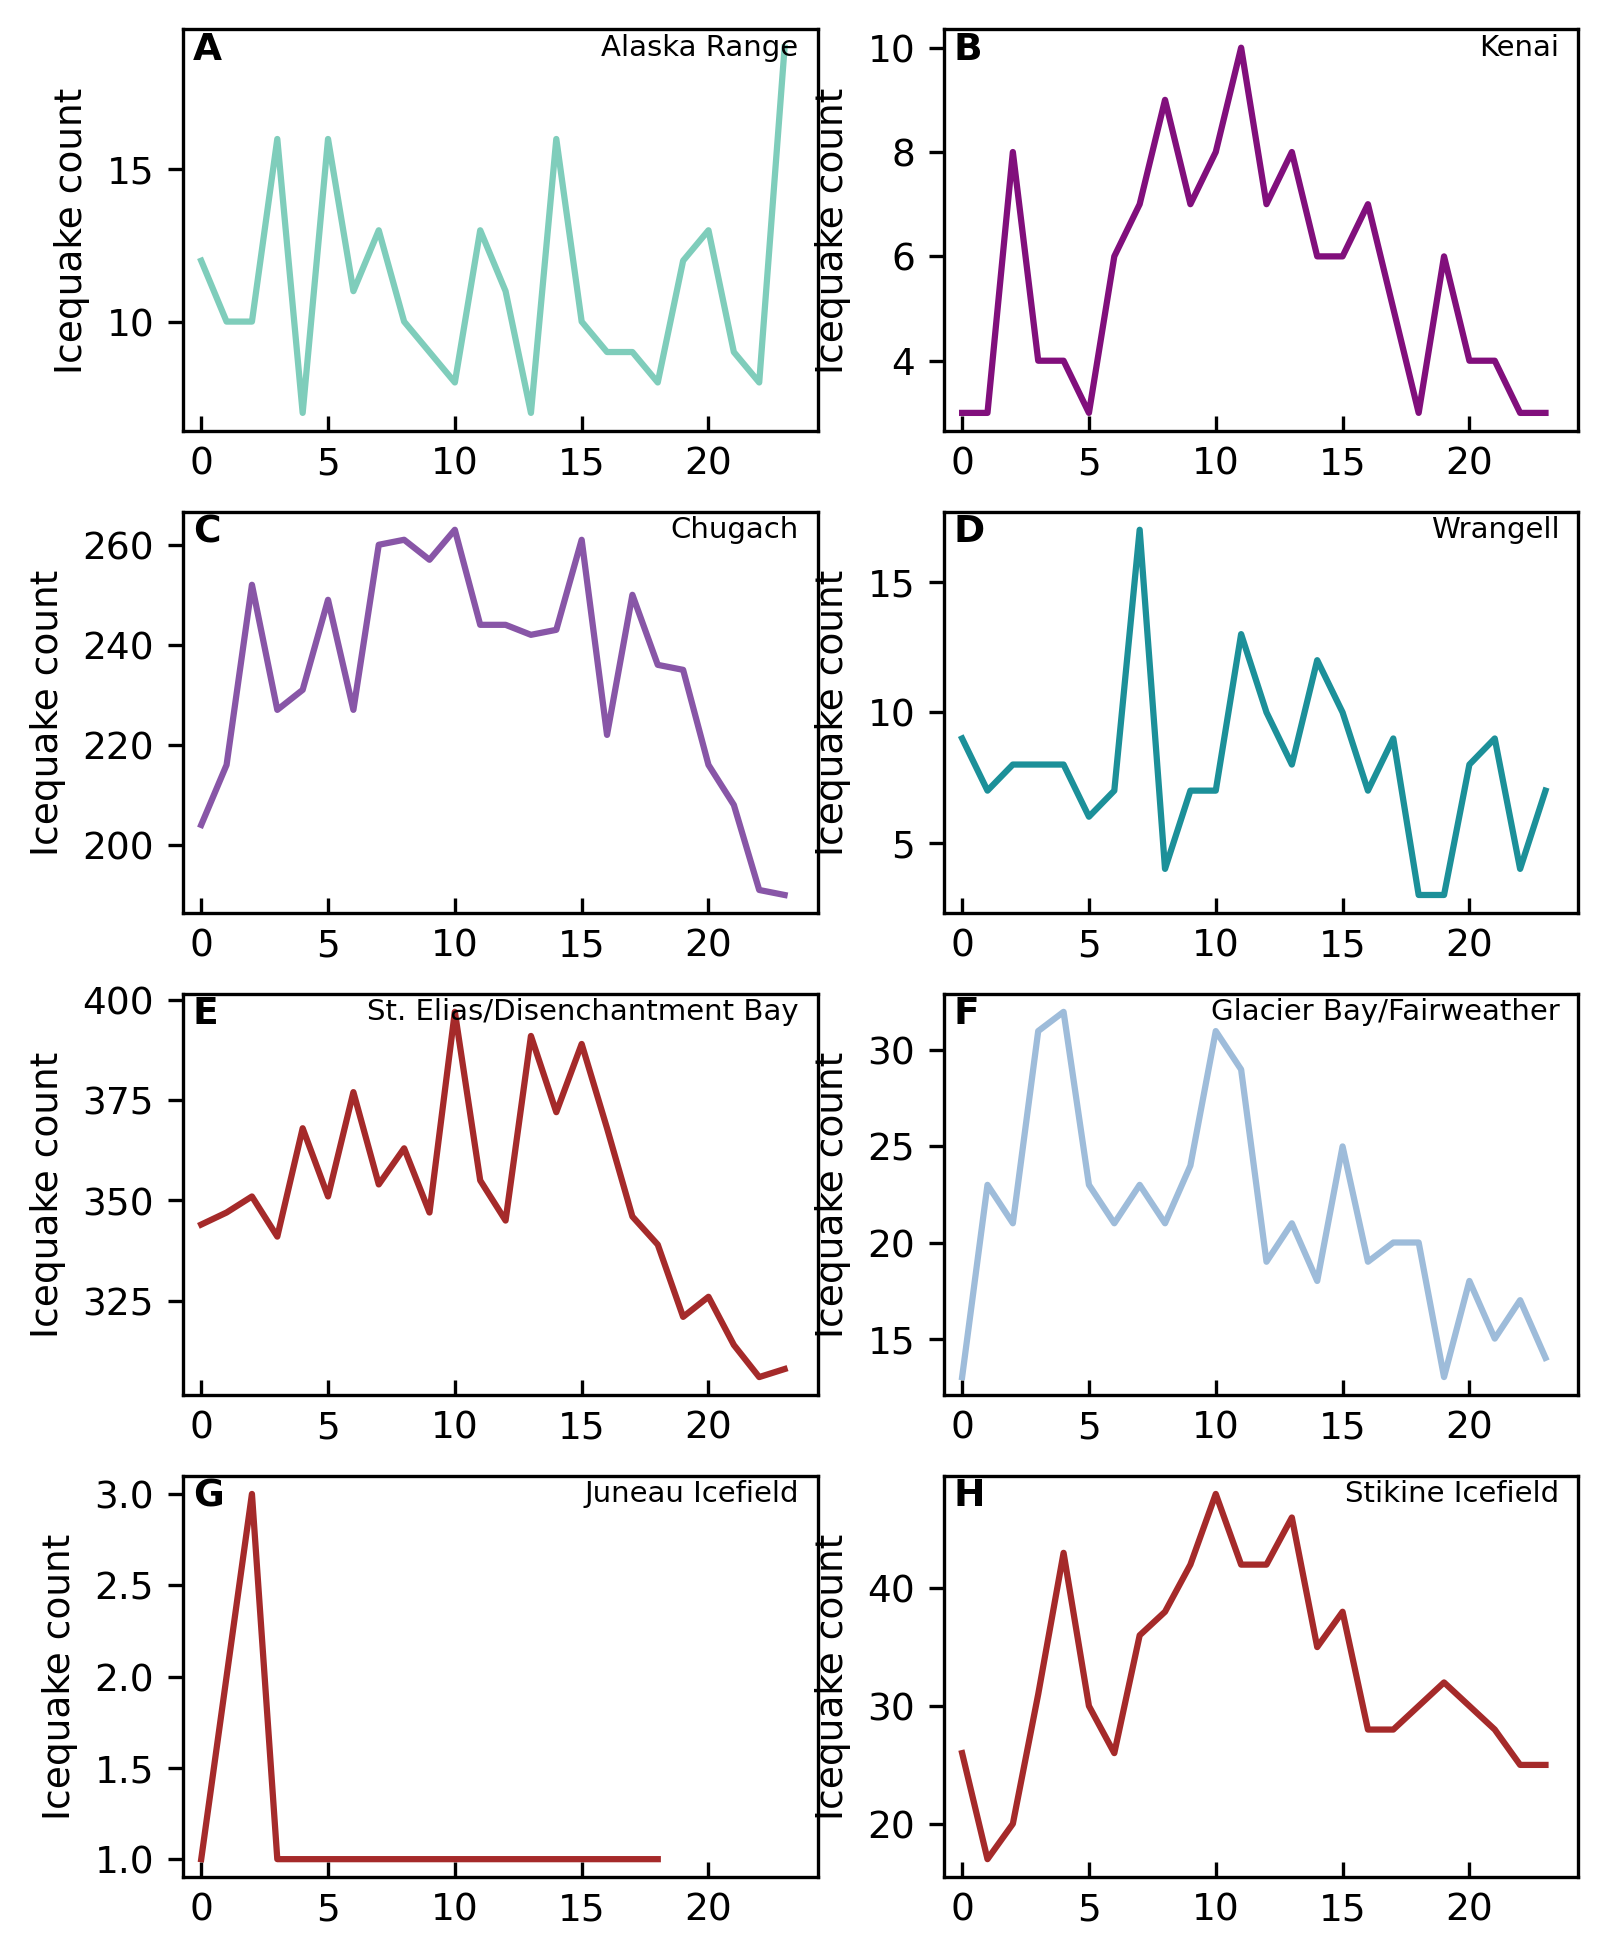

In [15]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7,ax8)) = plt.subplots(4, 2, figsize=(6, 8))

ax1.plot(df_AlRng.groupby(df_AlRng.index.hour).size(),color='#7fcdbb')
ax1.set_ylabel('Icequake count')
ax1.tick_params(axis='x', direction='in')
#ax1.set_ylim(0,2100)
ax1.set_xlim(-0.7,24.3)
#ax1.set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
#ax1.set_xticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])
ax1.text(0.97, 0.99, 'Alaska Range', fontsize='7', horizontalalignment='right', verticalalignment='top', transform=ax1.transAxes)
ax1.text(0.015, 0.995, 'A', weight='bold', horizontalalignment='left', verticalalignment='top', fontsize=9, transform=ax1.transAxes)

ax2.plot(df_Ken.groupby(df_Ken.index.hour).size(),color='#810f7c')
ax2.set_ylabel('Icequake count')
ax2.tick_params(axis='x', direction='in')
#ax1.set_ylim(0,2100)
ax2.set_xlim(-0.7,24.3)
#ax2.set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
#ax2.set_xticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])
ax2.text(0.97, 0.99, 'Kenai', fontsize='7', horizontalalignment='right', verticalalignment='top', transform=ax2.transAxes)
ax2.text(0.015, 0.995, 'B', weight='bold', horizontalalignment='left', verticalalignment='top', fontsize=9, transform=ax2.transAxes)

ax3.plot(df_Chugach.groupby(df_Chugach.index.hour).size(),color='#8856a7')
ax3.set_ylabel('Icequake count')
ax3.tick_params(axis='x', direction='in')
#ax1.set_ylim(0,2100)
ax3.set_xlim(-0.7,24.3)
#ax3.set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
#ax3.set_xticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])
ax3.text(0.97, 0.99, 'Chugach', fontsize='7', horizontalalignment='right', verticalalignment='top', transform=ax3.transAxes)
ax3.text(0.015, 0.995, 'C', weight='bold', horizontalalignment='left', verticalalignment='top', fontsize=9, transform=ax3.transAxes)

ax4.plot(df_Wran.groupby(df_Wran.index.hour).size(),color='#1c9099')
ax4.set_ylabel('Icequake count')
ax4.tick_params(axis='x', direction='in')
#ax1.set_ylim(0,2100)
ax4.set_xlim(-0.7,24.3)
#ax4.set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
#ax4.set_xticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])
ax4.text(0.97, 0.99, 'Wrangell', fontsize='7', horizontalalignment='right', verticalalignment='top', transform=ax4.transAxes)
ax4.text(0.015, 0.995, 'D', weight='bold', horizontalalignment='left', verticalalignment='top', fontsize=9, transform=ax4.transAxes)

ax5.plot(df_StDis.groupby(df_StDis.index.hour).size(),color='brown')
ax5.set_ylabel('Icequake count')
ax5.tick_params(axis='x', direction='in')
#ax1.set_ylim(0,2100)
ax5.set_xlim(-0.7,24.3)
#ax5.set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
#ax5.set_xticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])
ax5.text(0.97, 0.99, 'St. Elias/Disenchantment Bay', fontsize='7', horizontalalignment='right', verticalalignment='top', transform=ax5.transAxes)
ax5.text(0.015, 0.995, 'E', weight='bold', horizontalalignment='left', verticalalignment='top', fontsize=9, transform=ax5.transAxes)

ax6.plot(df_GlBFair.groupby(df_GlBFair.index.hour).size(),color='#9ebcda')
ax6.set_ylabel('Icequake count')
ax6.tick_params(axis='x', direction='in')
#ax1.set_ylim(0,2100)
ax6.set_xlim(-0.7,24.3)
#ax6.set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
#ax6.set_xticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])
ax6.text(0.97, 0.99, 'Glacier Bay/Fairweather', fontsize='7', horizontalalignment='right', verticalalignment='top', transform=ax6.transAxes)
ax6.text(0.015, 0.995, 'F', weight='bold', horizontalalignment='left', verticalalignment='top', fontsize=9, transform=ax6.transAxes)

ax7.plot(df_JunIce.groupby(df_JunIce.index.hour).size(),color='brown')
ax7.set_ylabel('Icequake count')
ax7.tick_params(axis='x', direction='in')
#ax1.set_ylim(0,2100)
ax7.set_xlim(-0.7,24.3)
#ax7.set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
#ax7.set_xticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])
ax7.text(0.97, 0.99, 'Juneau Icefield', fontsize='7', horizontalalignment='right', verticalalignment='top', transform=ax7.transAxes)
ax7.text(0.015, 0.995, 'G', weight='bold', horizontalalignment='left', verticalalignment='top', fontsize=9, transform=ax7.transAxes)

ax8.plot(df_Stik.groupby(df_Stik.index.hour).size(),color='brown')
ax8.set_ylabel('Icequake count')
ax8.tick_params(axis='x', direction='in')
#ax1.set_ylim(0,2100)
ax8.set_xlim(-0.7,24.3)
#ax8.set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
#ax8.set_xticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])
ax8.text(0.97, 0.99, 'Stikine Icefield', fontsize='7', horizontalalignment='right', verticalalignment='top', transform=ax8.transAxes)
ax8.text(0.015, 0.995, 'H', weight='bold', horizontalalignment='left', verticalalignment='top', fontsize=9, transform=ax8.transAxes)

os.chdir(Figures_folder)
plt.savefig('AKBCIQMonthlycount.png', bbox_inches='tight')

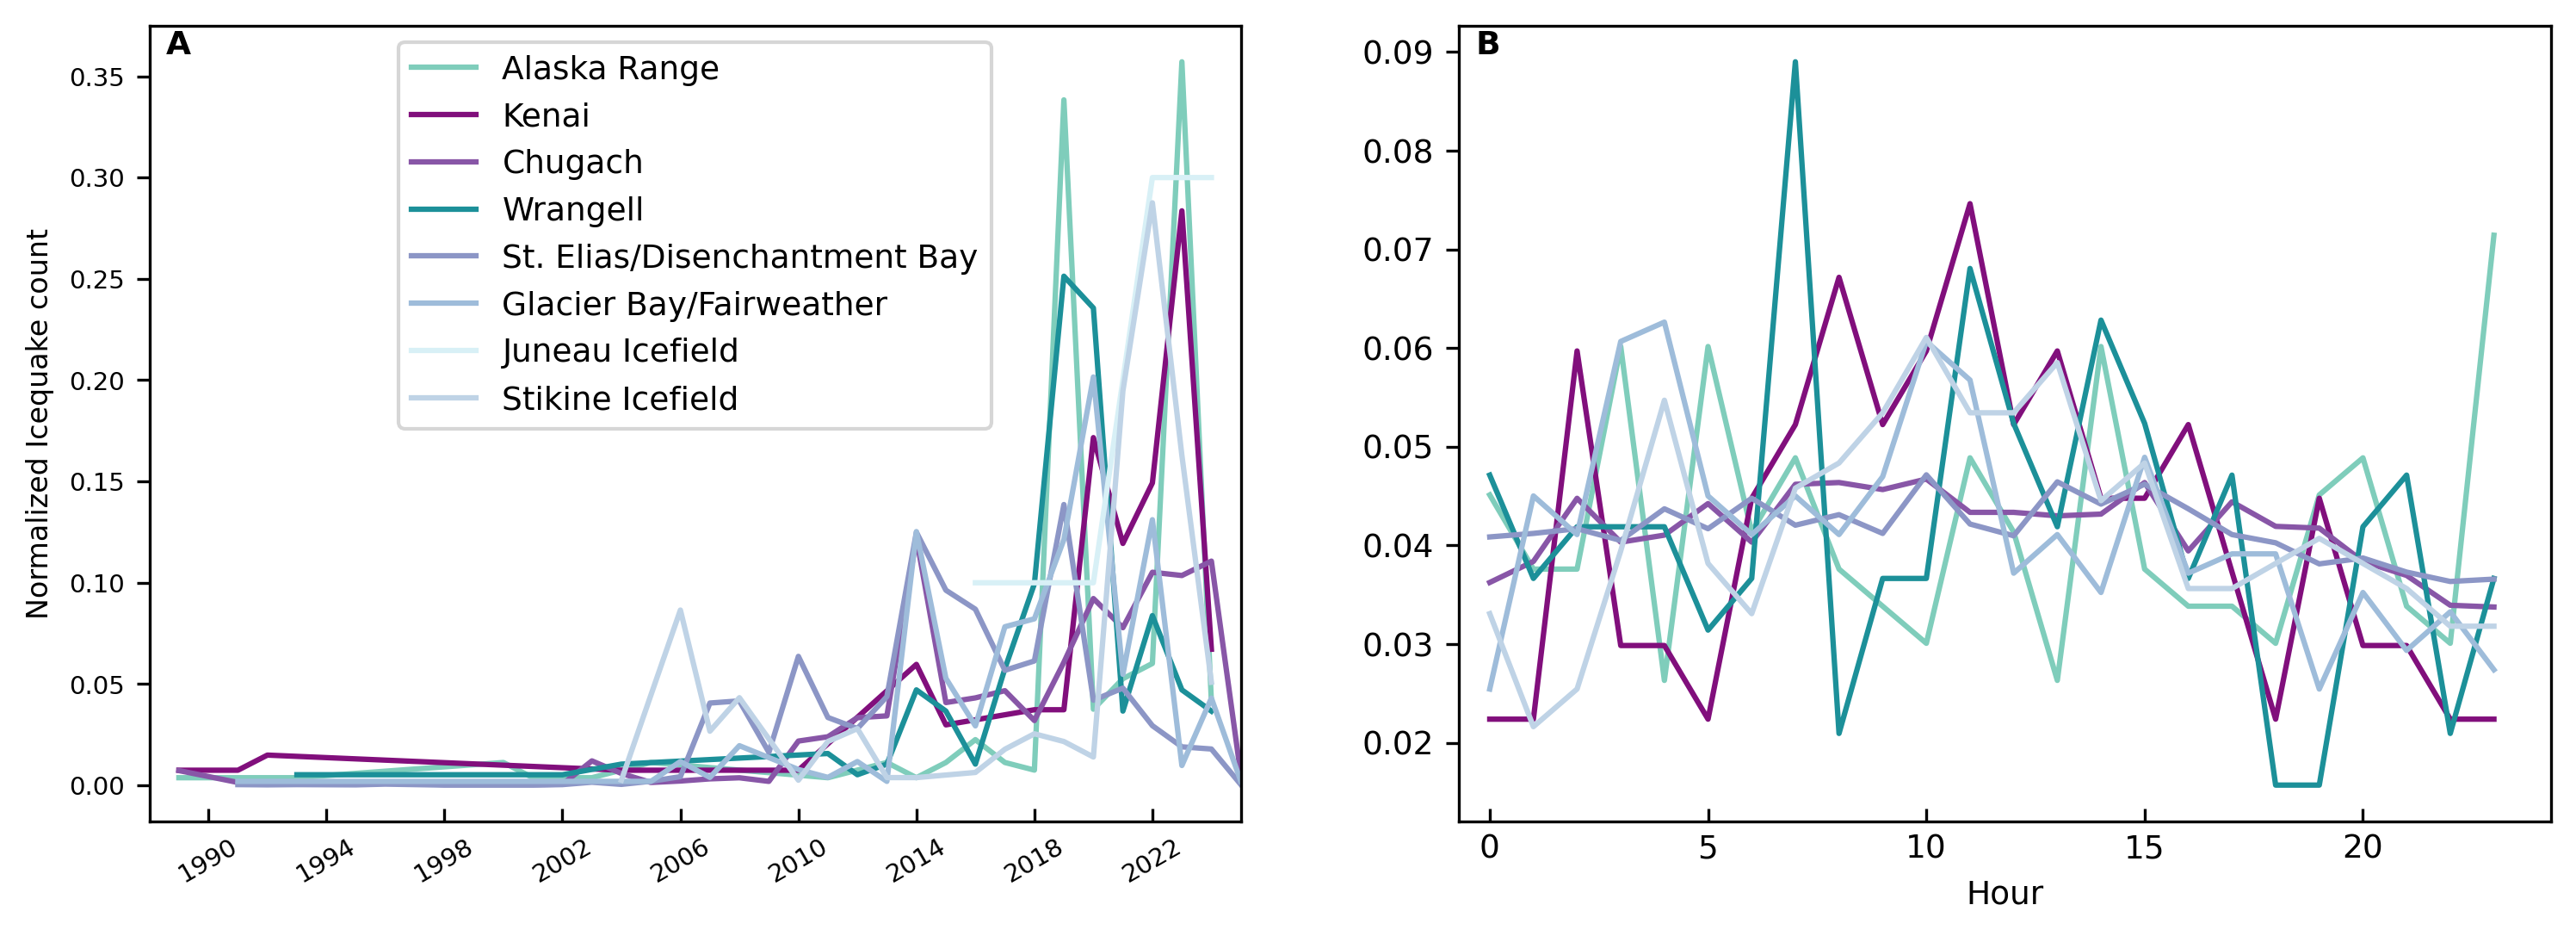

In [16]:
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(df_AlRng.groupby(df_AlRng.index.year).size()/df_AlRng.groupby(df_AlRng.index.year).size().sum(),color='#7fcdbb')
ax1.tick_params(axis='x', labelrotation=30, direction='in')
ax1.set_xticks([1990, 1994, 1998, 2002, 2006, 2010, 2014, 2018, 2022])
ax1.set_xlim(1988,2025)
ax1.set_ylabel('Normalized Icequake count',fontsize = 8)
ax1.tick_params(axis='both', labelsize=7)  
ax1.text(0.015, 0.995, 'A', weight='bold', horizontalalignment='left', verticalalignment='top', fontsize=9, transform=ax1.transAxes)
ax1.plot(df_Ken.groupby(df_Ken.index.year).size()/df_Ken.groupby(df_Ken.index.year).size().sum(),color='#810f7c')
ax1.plot(df_Chugach.groupby(df_Chugach.index.year).size()/df_Chugach.groupby(df_Chugach.index.year).size().sum(),color='#8856a7')
ax1.plot(df_Wran.groupby(df_Wran.index.year).size()/df_Wran.groupby(df_Wran.index.year).size().sum(),color='#1c9099')
ax1.plot(df_StDis.groupby(df_StDis.index.year).size()/df_StDis.groupby(df_StDis.index.year).size().sum(),color='#8c96c6')
ax1.plot(df_GlBFair.groupby(df_GlBFair.index.year).size()/df_GlBFair.groupby(df_GlBFair.index.year).size().sum(),color='#9ebcda')
ax1.plot(df_JunIce.groupby(df_JunIce.index.year).size()/df_JunIce.groupby(df_JunIce.index.year).size().sum(),color='#d8f0f6')
ax1.plot(df_Stik.groupby(df_Stik.index.year).size()/df_Stik.groupby(df_Stik.index.year).size().sum(),color='#bfd3e6')
ax1.legend(labels=['Alaska Range', 'Kenai', 'Chugach', 'Wrangell', 'St. Elias/Disenchantment Bay', 'Glacier Bay/Fairweather', 'Juneau Icefield', 'Stikine Icefield'], loc='upper center')

ax2.plot(df_AlRng.groupby(df_AlRng.index.hour).size()/df_AlRng.groupby(df_AlRng.index.hour).size().sum(),color='#7fcdbb')
#ax2.set_ylabel('Icequake count')
ax2.tick_params(axis='x', direction='in')
#ax1.set_ylim(0,2100)
ax2.set_xlim(-0.7,24.3)
#ax1.set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
#ax1.set_xticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])
ax2.text(0.015, 0.995, 'B', weight='bold', horizontalalignment='left', verticalalignment='top', fontsize=9, transform=ax2.transAxes)
ax2.plot(df_Ken.groupby(df_Ken.index.hour).size()/df_Ken.groupby(df_Ken.index.hour).size().sum(),color='#810f7c')
ax2.plot(df_Chugach.groupby(df_Chugach.index.hour).size()/df_Chugach.groupby(df_Chugach.index.hour).size().sum(),color='#8856a7')
ax2.plot(df_Wran.groupby(df_Wran.index.hour).size()/df_Wran.groupby(df_Wran.index.hour).size().sum(),color='#1c9099')
ax2.plot(df_StDis.groupby(df_StDis.index.hour).size()/df_StDis.groupby(df_StDis.index.hour).size().sum(),color='#8c96c6')
ax2.plot(df_GlBFair.groupby(df_GlBFair.index.hour).size()/df_GlBFair.groupby(df_GlBFair.index.hour).size().sum(),color='#9ebcda')
#ax2.plot(df_JunIce.groupby(df_JunIce.index.hour).size()/df_JunIce.groupby(df_JunIce.index.hour).size().sum(),color='#d8f0f6')
ax2.plot(df_Stik.groupby(df_Stik.index.hour).size()/df_Stik.groupby(df_Stik.index.hour).size().sum(),color='#bfd3e6')
ax2.set_xlabel('Hour')

os.chdir(Figures_folder)
plt.savefig('AKBCIQMonthlyHourlycount.png', bbox_inches='tight')

In [17]:
df_StDis_cl = df_StDis.copy().drop(columns = ['magType', 'nst', 'gap', 'dmin', 'rms', 'net', 'id', 'updated', 'place', 'type', 'horizontalError', 'depthError', 'magError', 'magNst', 'status', 'locationSource', 'magSource'])
df_Chugach_cl = df_Chugach.copy().drop(columns = ['magType', 'nst', 'gap', 'dmin', 'rms', 'net', 'id', 'updated', 'place', 'type', 'horizontalError', 'depthError', 'magError', 'magNst', 'status', 'locationSource', 'magSource'])
df_Stik_cl = df_Stik.copy().drop(columns = ['magType', 'nst', 'gap', 'dmin', 'rms', 'net', 'id', 'updated', 'place', 'type', 'horizontalError', 'depthError', 'magError', 'magNst', 'status', 'locationSource', 'magSource'])
df_GlBFair_cl = df_GlBFair.copy().drop(columns = ['magType', 'nst', 'gap', 'dmin', 'rms', 'net', 'id', 'updated', 'place', 'type', 'horizontalError', 'depthError', 'magError', 'magNst', 'status', 'locationSource', 'magSource'])
df_AlRng_cl = df_AlRng.copy().drop(columns = ['magType', 'nst', 'gap', 'dmin', 'rms', 'net', 'id', 'updated', 'place', 'type', 'horizontalError', 'depthError', 'magError', 'magNst', 'status', 'locationSource', 'magSource'])
df_Wran_cl = df_Wran.copy().drop(columns = ['magType', 'nst', 'gap', 'dmin', 'rms', 'net', 'id', 'updated', 'place', 'type', 'horizontalError', 'depthError', 'magError', 'magNst', 'status', 'locationSource', 'magSource'])
df_Ken_cl = df_Ken.copy().drop(columns = ['magType', 'nst', 'gap', 'dmin', 'rms', 'net', 'id', 'updated', 'place', 'type', 'horizontalError', 'depthError', 'magError', 'magNst', 'status', 'locationSource', 'magSource'])
df_JunIce_cl = df_JunIce.copy().drop(columns = ['magType', 'nst', 'gap', 'dmin', 'rms', 'net', 'id', 'updated', 'place', 'type', 'horizontalError', 'depthError', 'magError', 'magNst', 'status', 'locationSource', 'magSource'])

df_StDis_cl = df_StDis_cl.dropna()
df_Chugach_cl = df_Chugach_cl.dropna()
df_Stik_cl = df_Stik_cl.dropna()
df_GlBFair_cl = df_GlBFair_cl.dropna()
df_AlRng_cl = df_AlRng_cl.dropna()
df_Wran_cl = df_Wran_cl.dropna()
df_Ken_cl = df_Ken_cl.dropna()
df_JunIce_cl = df_JunIce_cl.dropna()

n_kde_StDisMw=kde(df_StDis_cl.Mw)
x_kde_StDisMw=np.linspace(np.min(df_StDis_cl.Mw),np.max(df_StDis_cl.Mw),30)

n_kde_ChugachMw=kde(df_Chugach_cl.Mw)
x_kde_ChugachMw=np.linspace(np.min(df_Chugach_cl.Mw),np.max(df_Chugach_cl.Mw),30)

n_kde_StikMw=kde(df_Stik_cl.Mw)
x_kde_StikMw=np.linspace(np.min(df_Stik_cl.Mw),np.max(df_Stik_cl.Mw),30)

n_kde_GlBFairMw=kde(df_GlBFair_cl.Mw)
x_kde_GlBFairMW=np.linspace(np.min(df_GlBFair_cl.Mw),np.max(df_GlBFair_cl.Mw),50)

n_kde_AlRngMw=kde(df_AlRng_cl.Mw)
x_kde_AlRngMw=np.linspace(np.min(df_AlRng_cl.Mw),np.max(df_AlRng_cl.Mw),30)

n_kde_WranMw=kde(df_Wran_cl.Mw)
x_kde_WranMw=np.linspace(np.min(df_Wran_cl.Mw),np.max(df_Wran_cl.Mw),30)

n_kde_KenMw=kde(df_Ken_cl.Mw)
x_kde_KenMw=np.linspace(np.min(df_Ken_cl.Mw),np.max(df_Ken_cl.Mw),30)

n_kde_JunIceMw=kde(df_JunIce_cl.Mw)
x_kde_JunIceMw=np.linspace(np.min(df_JunIce_cl.Mw),np.max(df_JunIce_cl.Mw),30)

Text(0.97, 0.99, 'Med. = 1.3')

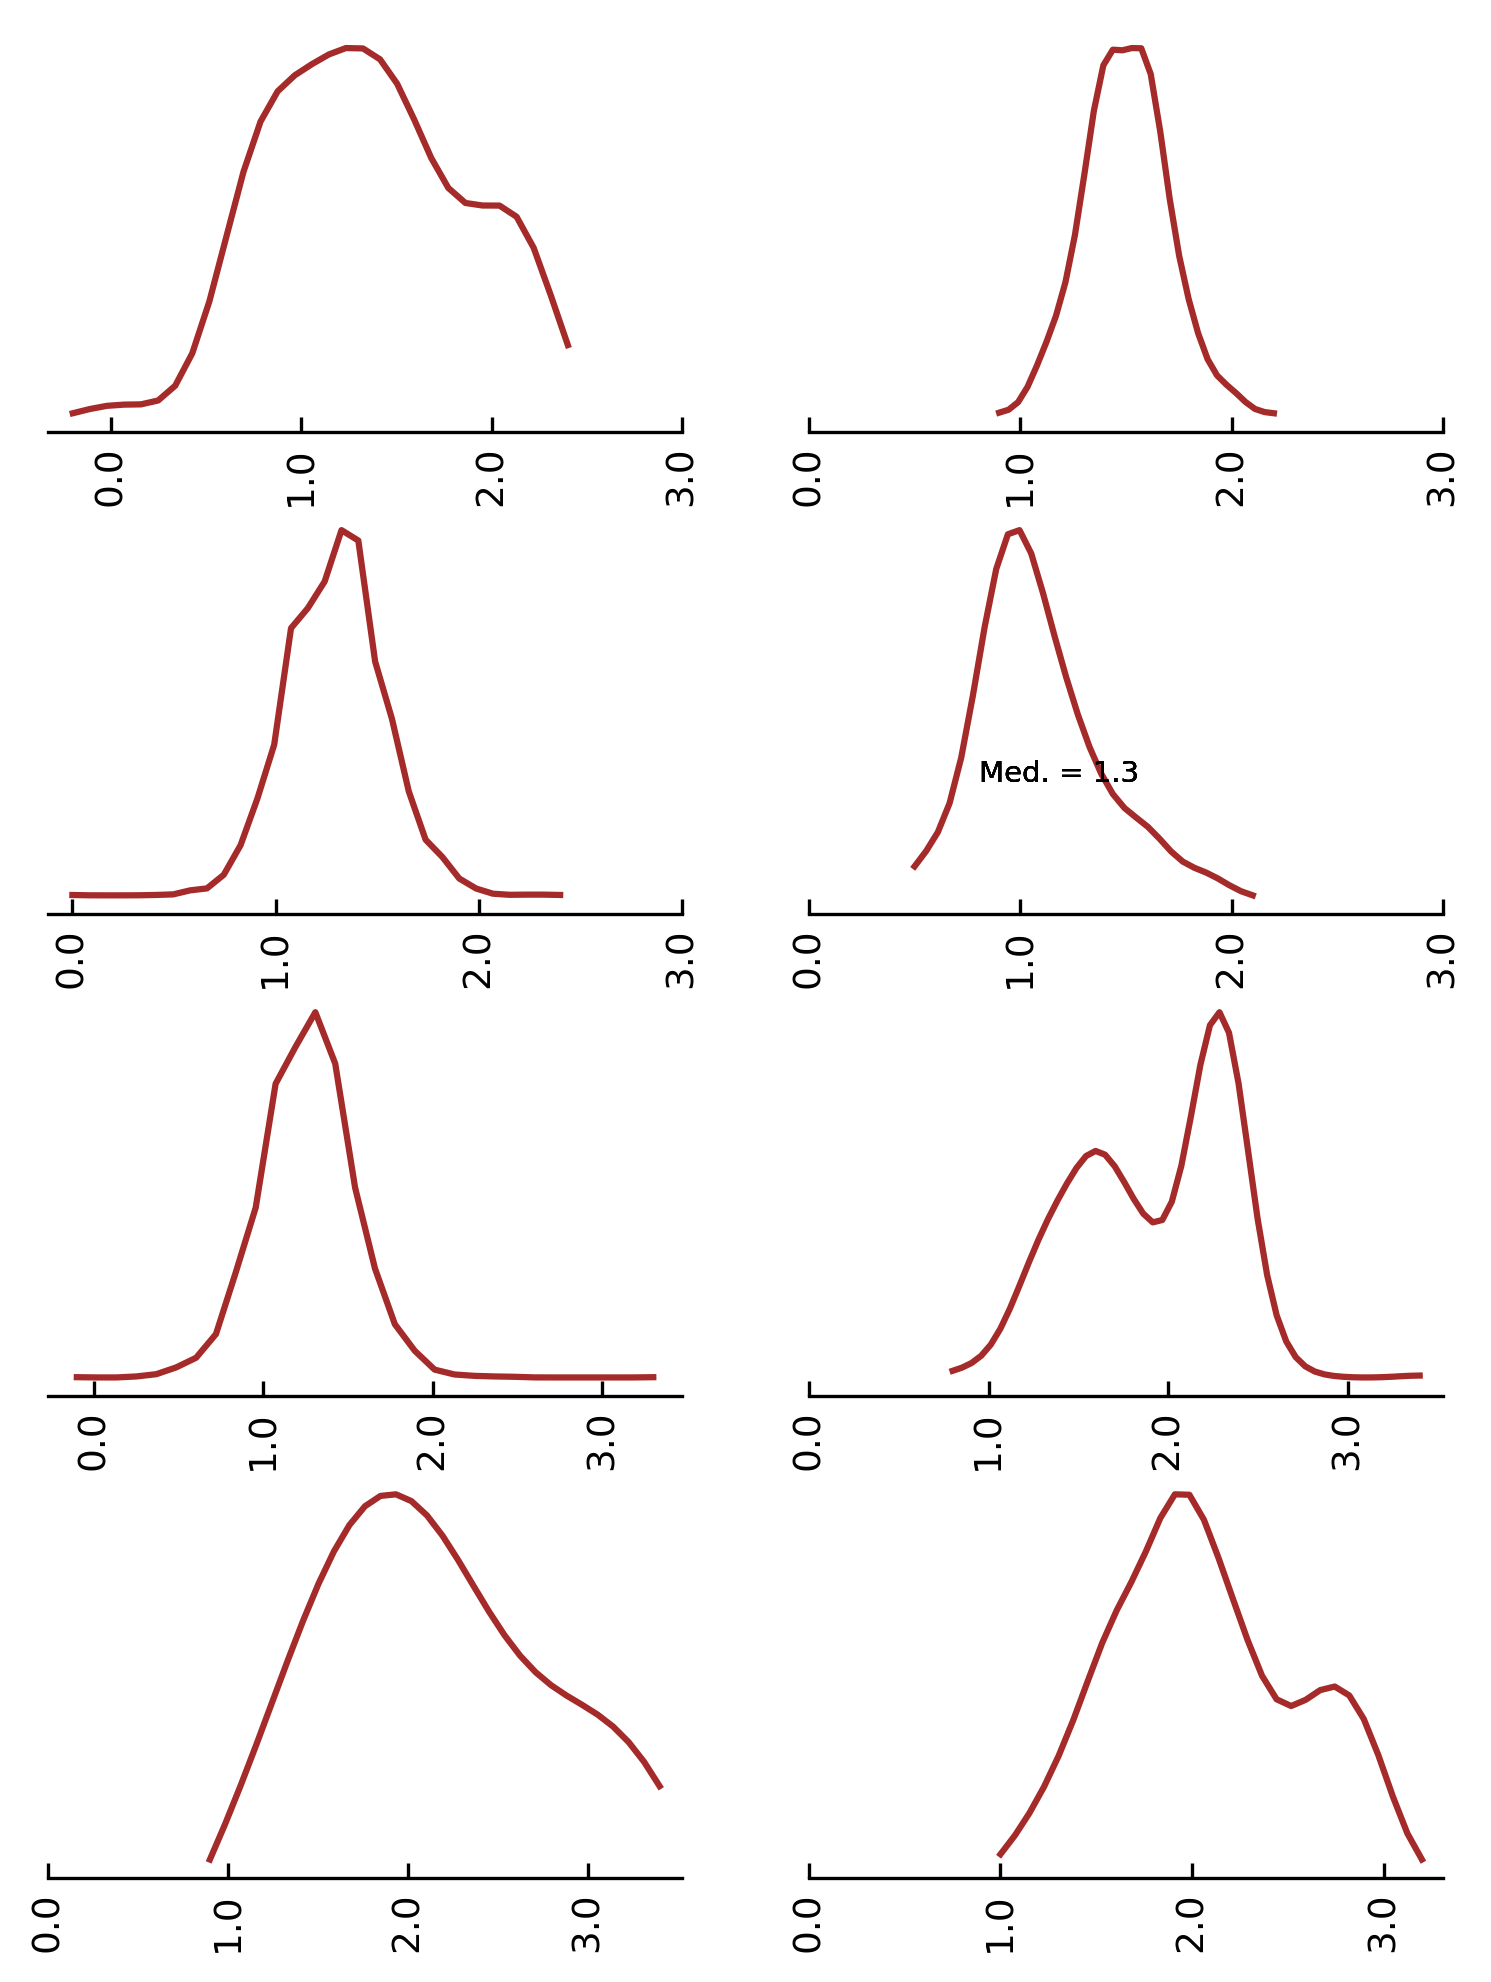

In [18]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7,ax8)) = plt.subplots(4, 2, figsize=(6, 8))

ax1.plot(x_kde_AlRngMw, n_kde_AlRngMw(x_kde_AlRngMw), '-', linewidth=1.5, color='brown')
ax1.tick_params('x', direction = 'in')
ax1.tick_params('y', left=False, labelleft=False)
ax1.set_yticklabels([])
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.set_xticks([0.0, 1.0, 2.0, 3.0])
ax1.set_xticklabels([0.0, 1.0, 2.0, 3.0])
ax1.tick_params(axis='x', labelrotation=90, direction='in')
ax1.text(0.97, 0.99, 'Med. = 1.3', fontsize='7', horizontalalignment='right', verticalalignment='top', transform=axkde1.transAxes)
#axkde1.patch.set_alpha(0)

ax2.plot(x_kde_KenMw, n_kde_KenMw(x_kde_KenMw), '-', linewidth=1.5, color='brown')
ax2.tick_params('x', direction = 'in')  
ax2.tick_params('y', left=False, labelleft=False)
ax2.set_yticklabels([])
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.set_xticks([0.0, 1.0, 2.0, 3.0])
ax2.set_xticklabels([0.0, 1.0, 2.0, 3.0])
ax2.tick_params(axis='x', labelrotation=90, direction='in')
ax2.text(0.97, 0.99, 'Med. = 1.3', fontsize='7', horizontalalignment='right', verticalalignment='top', transform=axkde1.transAxes)
#axkde1.patch.set_alpha(0)

ax3.plot(x_kde_ChugachMw, n_kde_ChugachMw(x_kde_ChugachMw), '-', linewidth=1.5, color='brown')
ax3.tick_params('x', direction = 'in')
ax3.tick_params('y', left=False, labelleft=False)
ax3.set_yticklabels([])
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)
ax3.spines['left'].set_visible(False)
ax3.set_xticks([0.0, 1.0, 2.0, 3.0])
ax3.set_xticklabels([0.0, 1.0, 2.0, 3.0])
ax3.tick_params(axis='x', labelrotation=90, direction='in')
ax3.text(0.97, 0.99, 'Med. = 1.3', fontsize='7', horizontalalignment='right', verticalalignment='top', transform=axkde1.transAxes)
#axkde1.patch.set_alpha(0)

ax4.plot(x_kde_WranMw, n_kde_WranMw(x_kde_WranMw), '-', linewidth=1.5, color='brown')
ax4.tick_params('x', direction = 'in')
ax4.tick_params('y', left=False, labelleft=False)
ax4.set_yticklabels([])
ax4.spines['right'].set_visible(False)
ax4.spines['top'].set_visible(False)
ax4.spines['left'].set_visible(False)
ax4.set_xticks([0.0, 1.0, 2.0, 3.0])
ax4.set_xticklabels([0.0, 1.0, 2.0, 3.0])
ax4.tick_params(axis='x', labelrotation=90, direction='in')
ax4.text(0.97, 0.99, 'Med. = 1.3', fontsize='7', horizontalalignment='right', verticalalignment='top', transform=axkde1.transAxes)
#axkde1.patch.set_alpha(0)

ax5.plot(x_kde_StDisMw, n_kde_StDisMw(x_kde_StDisMw), '-', linewidth=1.5, color='brown')
ax5.tick_params('x', direction = 'in')
ax5.tick_params('y', left=False, labelleft=False)
ax5.set_yticklabels([])
ax5.spines['right'].set_visible(False)
ax5.spines['top'].set_visible(False)
ax5.spines['left'].set_visible(False)
ax5.set_xticks([0.0, 1.0, 2.0, 3.0])
ax5.set_xticklabels([0.0, 1.0, 2.0, 3.0])
ax5.tick_params(axis='x', labelrotation=90, direction='in')
ax5.text(0.97, 0.99, 'Med. = 1.3', fontsize='7', horizontalalignment='right', verticalalignment='top', transform=axkde1.transAxes)
#axkde1.patch.set_alpha(0)

ax6.plot(x_kde_GlBFairMW, n_kde_GlBFairMw(x_kde_GlBFairMW), '-', linewidth=1.5, color='brown')
ax6.tick_params('x', direction = 'in')
ax6.tick_params('y', left=False, labelleft=False)
ax6.set_yticklabels([])
ax6.spines['right'].set_visible(False)
ax6.spines['top'].set_visible(False)
ax6.spines['left'].set_visible(False)
ax6.set_xticks([0.0, 1.0, 2.0, 3.0])
ax6.set_xticklabels([0.0, 1.0, 2.0, 3.0])
ax6.tick_params(axis='x', labelrotation=90, direction='in')
ax6.text(0.97, 0.99, 'Med. = 1.3', fontsize='7', horizontalalignment='right', verticalalignment='top', transform=axkde1.transAxes)
#axkde1.patch.set_alpha(0)

ax7.plot(x_kde_JunIceMw, n_kde_JunIceMw(x_kde_JunIceMw), '-', linewidth=1.5, color='brown')
ax7.tick_params('x', direction = 'in')
ax7.tick_params('y', left=False, labelleft=False)
ax7.set_yticklabels([])
ax7.spines['right'].set_visible(False)
ax7.spines['top'].set_visible(False)
ax7.spines['left'].set_visible(False)
ax7.set_xticks([0.0, 1.0, 2.0, 3.0])
ax7.set_xticklabels([0.0, 1.0, 2.0, 3.0])
ax7.tick_params(axis='x', labelrotation=90, direction='in')
ax7.text(0.97, 0.99, 'Med. = 1.3', fontsize='7', horizontalalignment='right', verticalalignment='top', transform=axkde1.transAxes)
#axkde1.patch.set_alpha(0)

ax8.plot(x_kde_StikMw, n_kde_StikMw(x_kde_StikMw), '-', linewidth=1.5, color='brown')
ax8.tick_params('x', direction = 'in')
ax8.tick_params('y', left=False, labelleft=False)
ax8.set_yticklabels([])
ax8.spines['right'].set_visible(False)
ax8.spines['top'].set_visible(False)
ax8.spines['left'].set_visible(False)
ax8.set_xticks([0.0, 1.0, 2.0, 3.0])
ax8.set_xticklabels([0.0, 1.0, 2.0, 3.0])
ax8.tick_params(axis='x', labelrotation=90, direction='in')
ax8.text(0.97, 0.99, 'Med. = 1.3', fontsize='7', horizontalalignment='right', verticalalignment='top', transform=axkde1.transAxes)
#axkde1.patch.set_alpha(0)



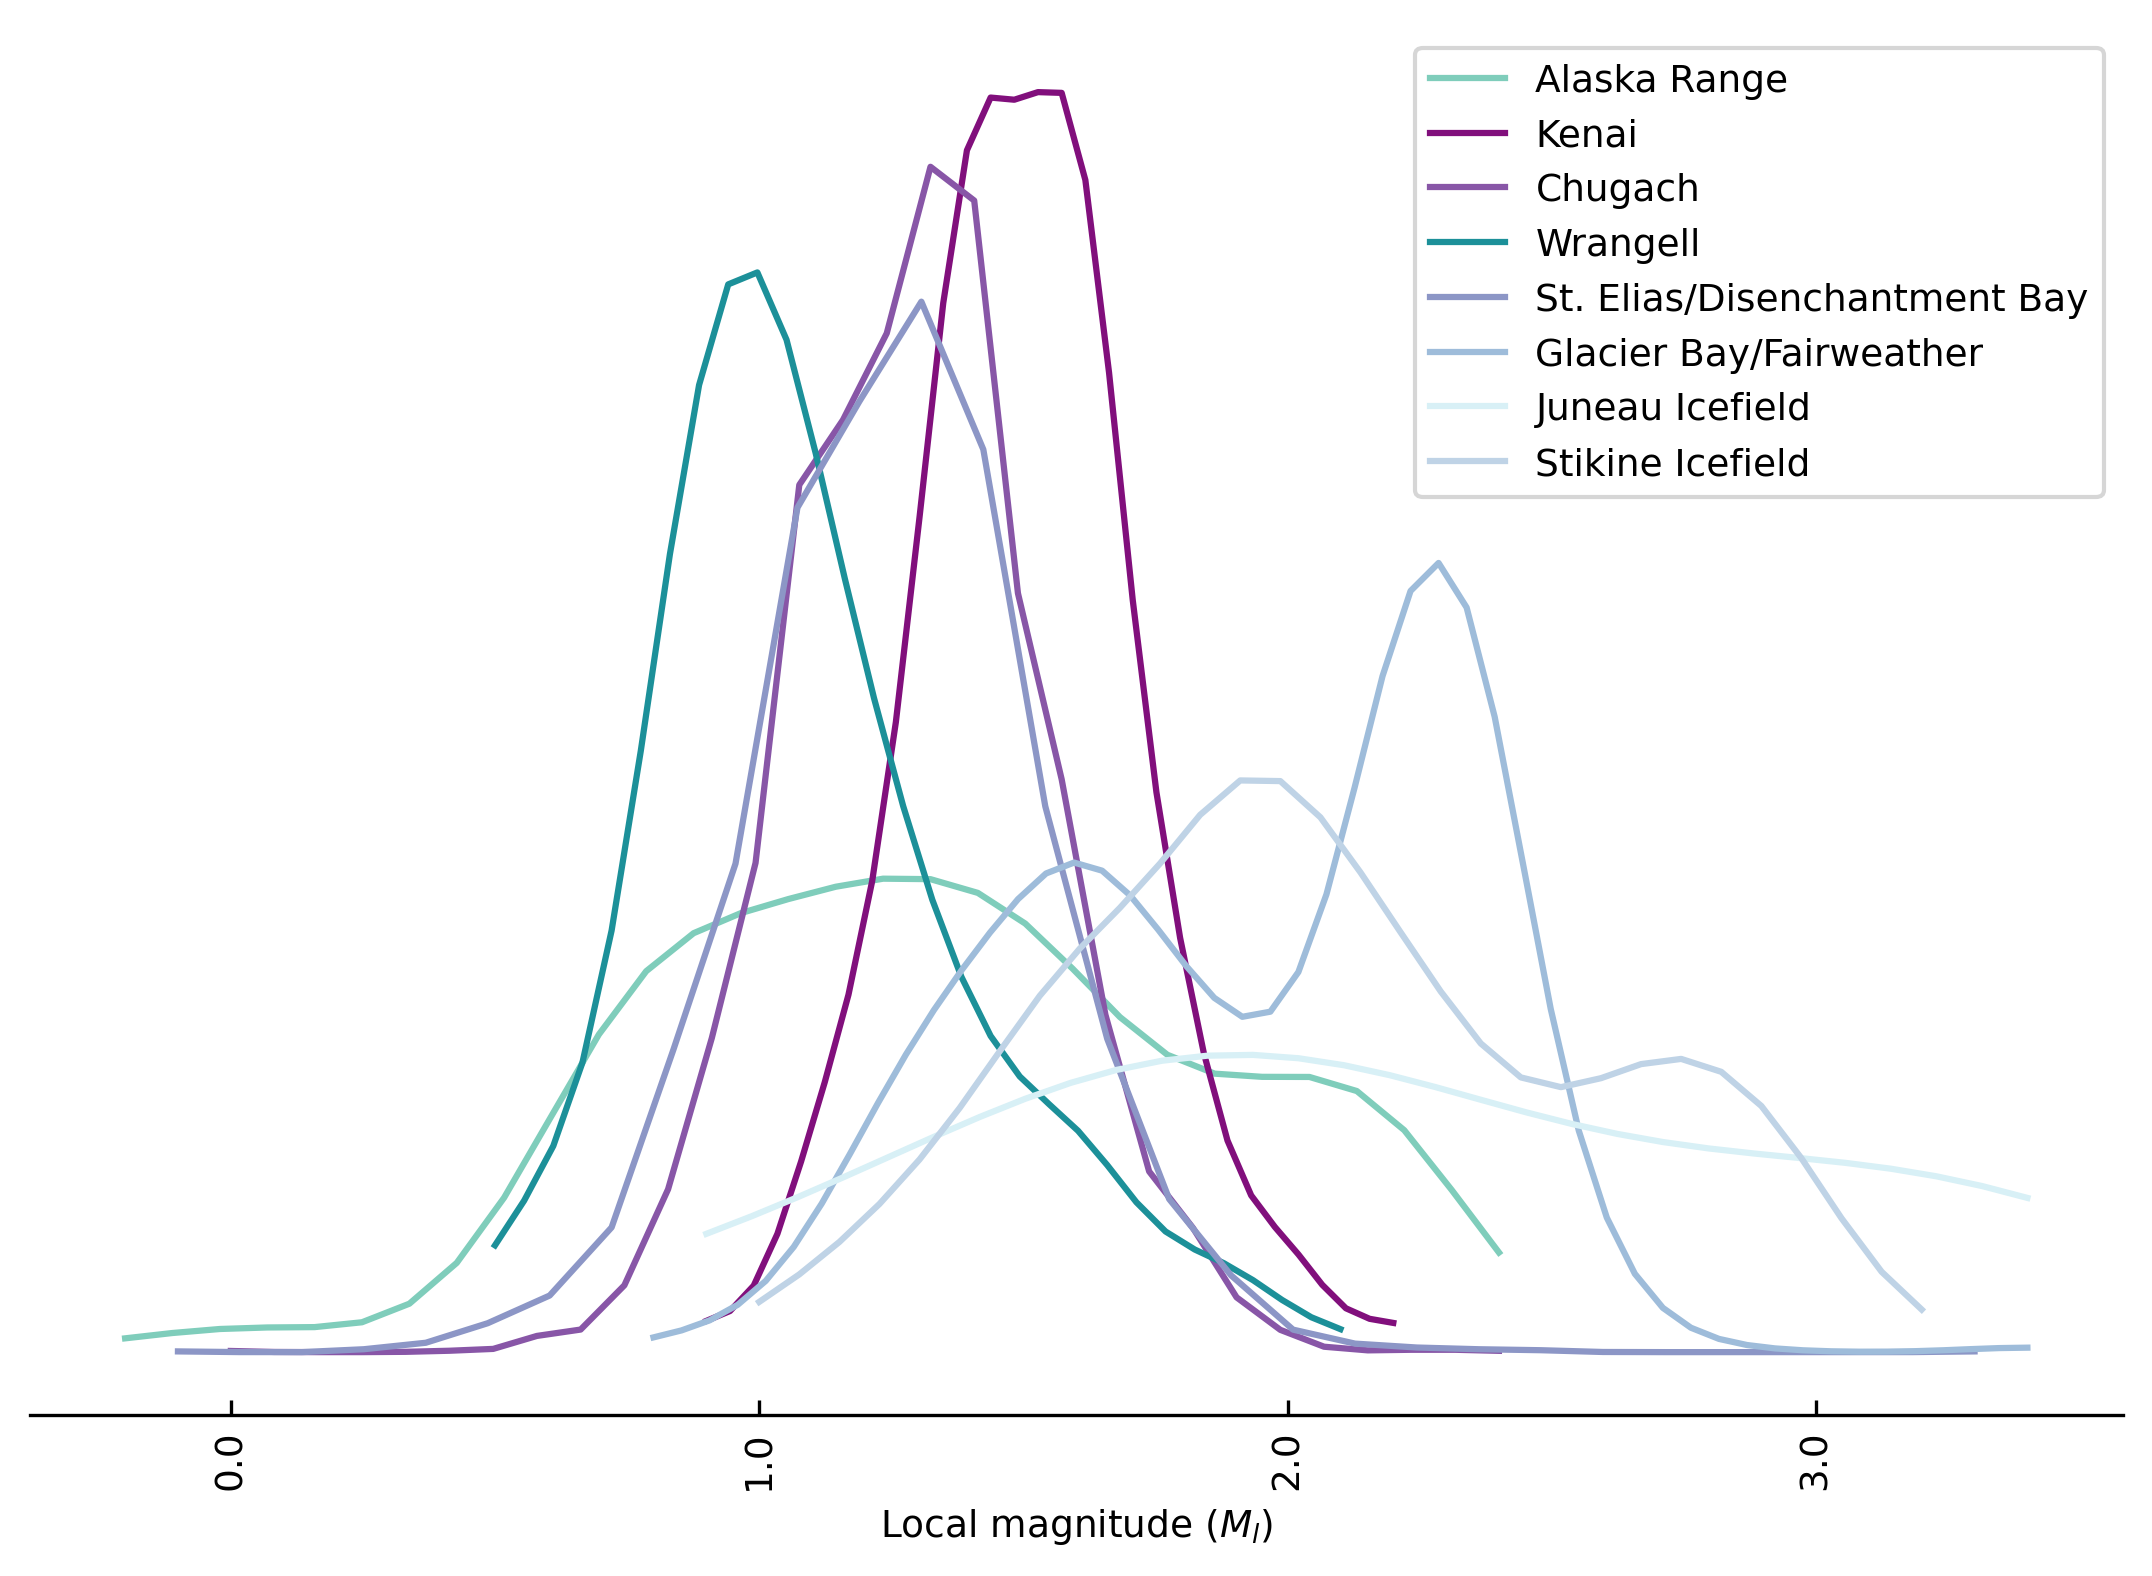

In [19]:
fig, (ax1) = plt.subplots(1, 1, figsize=(9, 6))

ax1.plot(x_kde_AlRngMw, n_kde_AlRngMw(x_kde_AlRngMw), '-', linewidth=1.5, color='#7fcdbb')
ax1.tick_params('x', direction = 'in')
ax1.tick_params('y', left=False, labelleft=False)
ax1.set_yticklabels([])
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.set_xticks([0.0, 1.0, 2.0, 3.0])
ax1.set_xticklabels([0.0, 1.0, 2.0, 3.0])
ax1.tick_params(axis='x', labelrotation=90, direction='in')
ax1.set_xlabel('Local magnitude $(M_l)$')
#ax1.text(0.97, 0.99, 'Med. = 1.3', fontsize='7', horizontalalignment='right', verticalalignment='top', transform=axkde1.transAxes)
#axkde1.patch.set_alpha(0)

ax1.plot(x_kde_KenMw, n_kde_KenMw(x_kde_KenMw), '-', linewidth=1.5, color='#810f7c')
ax1.plot(x_kde_ChugachMw, n_kde_ChugachMw(x_kde_ChugachMw), '-', linewidth=1.5, color='#8856a7')
ax1.plot(x_kde_WranMw, n_kde_WranMw(x_kde_WranMw), '-', linewidth=1.5, color='#1c9099')
ax1.plot(x_kde_StDisMw, n_kde_StDisMw(x_kde_StDisMw), '-', linewidth=1.5, color='#8c96c6')
ax1.plot(x_kde_GlBFairMW, n_kde_GlBFairMw(x_kde_GlBFairMW), '-', linewidth=1.5, color='#9ebcda')
ax1.plot(x_kde_JunIceMw, n_kde_JunIceMw(x_kde_JunIceMw), '-', linewidth=1.5, color='#d8f0f6')
ax1.plot(x_kde_StikMw, n_kde_StikMw(x_kde_StikMw), '-', linewidth=1.5, color='#bfd3e6')

ax1.legend(labels=['Alaska Range', 'Kenai', 'Chugach', 'Wrangell', 'St. Elias/Disenchantment Bay', 'Glacier Bay/Fairweather', 'Juneau Icefield', 'Stikine Icefield'], loc='best')

os.chdir(Figures_folder)
plt.savefig('AKregionsMlKDE.png', bbox_inches='tight')

In [20]:
print(statistics.median(df_AlRng_cl['Mw']))
print(statistics.median(df_Ken_cl['Mw']))
print(statistics.median(df_Chugach_cl['Mw']))
print(statistics.median(df_Wran_cl['Mw']))
print(statistics.median(df_StDis_cl['Mw']))
print(statistics.median(df_GlBFair_cl['Mw']))
print(statistics.median(df_JunIce_cl['Mw']))
print(statistics.median(df_Stik_cl['Mw']))




1.3
1.5
1.3
1.0
1.3
2.0
2.1500000000000004
2.0


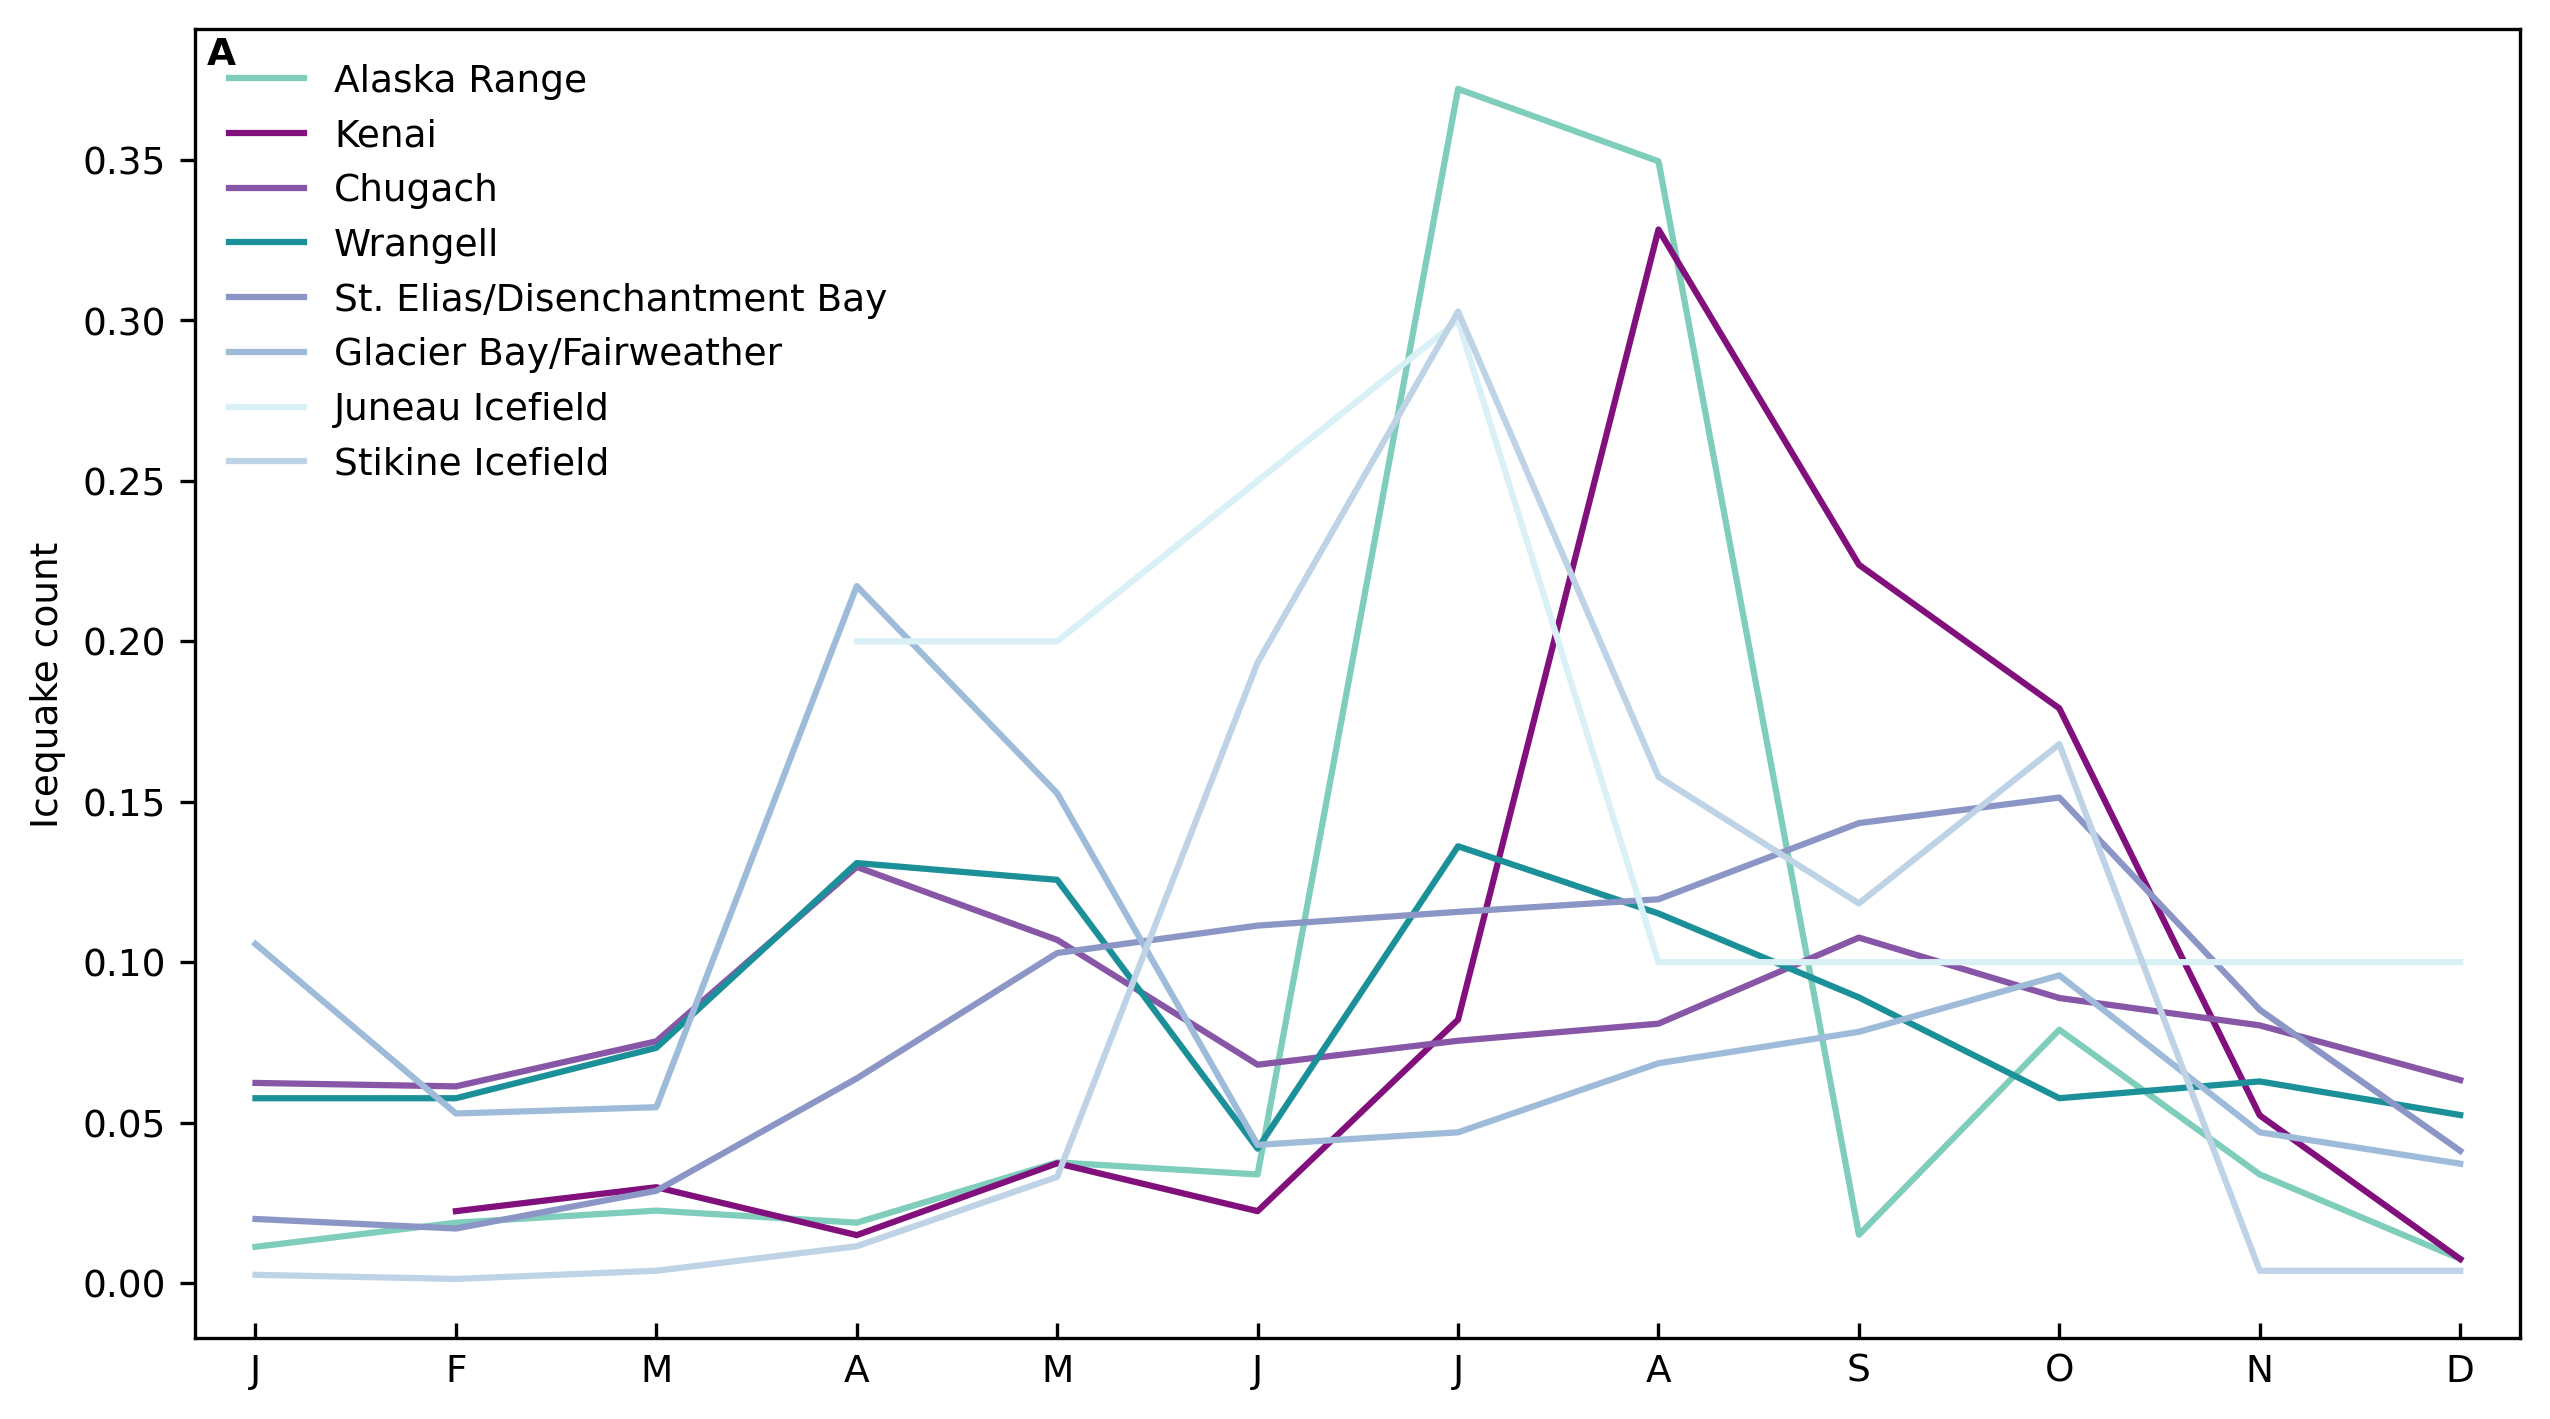

In [21]:
fig, (ax1) = plt.subplots(1, 1, figsize=(10, 17/3))

ax1.plot((df_AlRng.groupby(df_AlRng.index.month).size()/df_AlRng.groupby(df_AlRng.index.month).size().sum()),color='#7fcdbb')
ax1.set_ylabel('Icequake count')
ax1.tick_params(axis='x', direction='in')
#ax1.set_ylim(0,2100)
ax1.set_xlim(0.7,12.3)
ax1.set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
ax1.set_xticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])
#ax1.text(0.97, 0.99, 'Alaskan Icequakes', fontsize='7', horizontalalignment='right', verticalalignment='top', transform=ax1.transAxes)
ax1.text(0.005, 0.995, 'A', weight='bold', horizontalalignment='left', verticalalignment='top', fontsize=9, transform=ax1.transAxes)
ax1.plot(df_Ken.groupby(df_Ken.index.month).size() / df_Ken.groupby(df_Ken.index.month).size().sum(),color='#810f7c')
ax1.plot(df_Chugach.groupby(df_Chugach.index.month).size() / df_Chugach.groupby(df_Chugach.index.month).size().sum(),color='#8856a7')
ax1.plot(df_Wran.groupby(df_Wran.index.month).size() / df_Wran.groupby(df_Wran.index.month).size().sum(),color='#1c9099')
ax1.plot(df_StDis.groupby(df_StDis.index.month).size() / df_StDis.groupby(df_StDis.index.month).size().sum(),color='#8c96c6')
ax1.plot(df_GlBFair.groupby(df_GlBFair.index.month).size() / df_GlBFair.groupby(df_GlBFair.index.month).size().sum(),color='#9ebcda')
ax1.plot(df_JunIce.groupby(df_JunIce.index.month).size() / df_JunIce.groupby(df_JunIce.index.month).size().sum(),color='#d8f0f6')
ax1.plot(df_Stik.groupby(df_Stik.index.month).size() / df_Stik.groupby(df_Stik.index.month).size().sum(),color='#bfd3e6')
ax1.legend(labels=['Alaska Range', 'Kenai', 'Chugach', 'Wrangell', 'St. Elias/Disenchantment Bay', 'Glacier Bay/Fairweather', 'Juneau Icefield', 'Stikine Icefield'], loc='upper left', frameon=False)

os.chdir(Figures_folder)
plt.savefig('AllIQMonth.svg', bbox_inches='tight')

In [22]:
df_AlRnghourly = df_AlRng.resample('h').sum()
df_AlRnghourly['Mwh'] = (np.log10(df_AlRnghourly['M0'])-9.105)/1.5
df_AlRnghourly = df_AlRnghourly.resample('h').sum()
df_AlRnghourly['Mwh'] = df_AlRnghourly['Mwh'].replace(-np.inf, 0)

df_Kenhourly = df_Ken.resample('h').sum()
df_Kenhourly['Mwh'] = (np.log10(df_Kenhourly['M0'])-9.105)/1.5
df_Kenhourly = df_Kenhourly.resample('h').sum()
df_Kenhourly['Mwh'] = df_Kenhourly['Mwh'].replace(-np.inf, 0)

df_Chugachhourly = df_Chugach.resample('h').sum()
df_Chugachhourly['Mwh'] = (np.log10(df_Chugachhourly['M0'])-9.105)/1.5
df_Chugachhourly = df_Chugachhourly.resample('h').sum()
df_Chugachhourly['Mwh'] = df_Chugachhourly['Mwh'].replace(-np.inf, 0)

df_Wranhourly = df_Wran.resample('h').sum()
df_Wranhourly['Mwh'] = (np.log10(df_Wranhourly['M0'])-9.105)/1.5
df_Wranhourly = df_Wranhourly.resample('h').sum()
df_Wranhourly['Mwh'] = df_Wranhourly['Mwh'].replace(-np.inf, 0)

df_StDishourly = df_StDis.resample('h').sum()
df_StDishourly['Mwh'] = (np.log10(df_StDishourly['M0'])-9.105)/1.5
df_StDishourly = df_StDishourly.resample('h').sum()
df_StDishourly['Mwh'] = df_StDishourly['Mwh'].replace(-np.inf, 0)

df_GlBFairhourly = df_GlBFair.resample('h').sum()
df_GlBFairhourly['Mwh'] = (np.log10(df_GlBFairhourly['M0'])-9.105)/1.5
df_GlBFairhourly = df_GlBFairhourly.resample('h').sum()
df_GlBFairhourly['Mwh'] = df_GlBFairhourly['Mwh'].replace(-np.inf, 0)

df_JunIcehourly = df_JunIce.resample('h').sum()
df_JunIcehourly['Mwh'] = (np.log10(df_JunIcehourly['M0'])-9.105)/1.5
df_JunIcehourly = df_JunIcehourly.resample('h').sum()
df_JunIcehourly['Mwh'] = df_JunIcehourly['Mwh'].replace(-np.inf, 0)

df_Stikhourly = df_Stik.resample('h').sum()
df_Stikhourly['Mwh'] = (np.log10(df_Stikhourly['M0'])-9.105)/1.5
df_Stikhourly = df_Stikhourly.resample('h').sum()
df_Stikhourly['Mwh'] = df_Stikhourly['Mwh'].replace(-np.inf, 0)

c:\Users\alexd\anaconda3\envs\Icequake\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\alexd\anaconda3\envs\Icequake\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\alexd\anaconda3\envs\Icequake\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\alexd\anaconda3\envs\Icequake\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\alexd\anaconda3\envs\Icequake\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\alexd\anaconda3\envs\Icequake\l

C:\Users\alexd\AppData\Local\Temp\ipykernel_45080\831383287.py:7: RuntimeWarning: divide by zero encountered in divide
  Maghrw = 1/fwelChugMwh/3600
C:\Users\alexd\AppData\Local\Temp\ipykernel_45080\831383287.py:8: RuntimeWarning: divide by zero encountered in divide
  Magdayw = 1/fwelChugMwh/3600/24
C:\Users\alexd\AppData\Local\Temp\ipykernel_45080\831383287.py:10: RuntimeWarning: divide by zero encountered in divide
  Maghr = 1/freqsChugMwh/3600
C:\Users\alexd\AppData\Local\Temp\ipykernel_45080\831383287.py:11: RuntimeWarning: divide by zero encountered in divide
  Magday = 1/freqsChugMwh/3600/24


(1.0, 365.0)

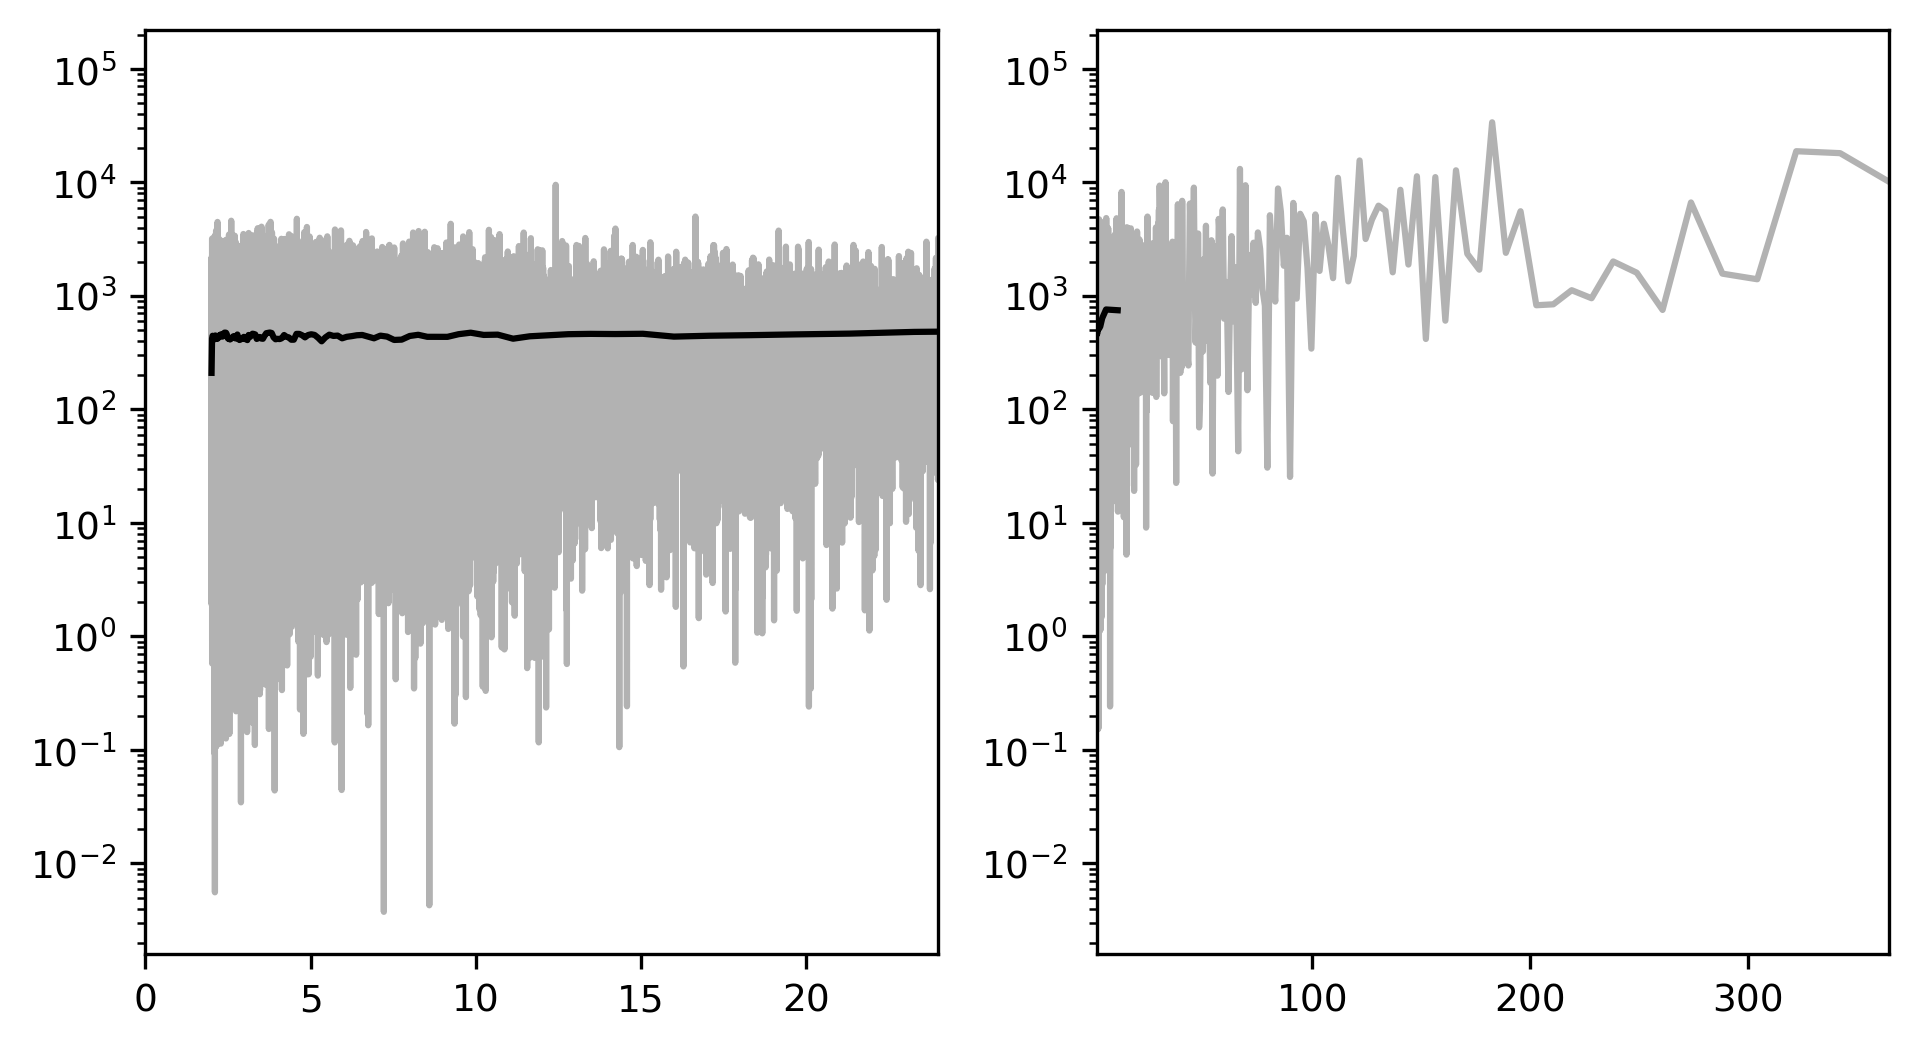

In [23]:
from scipy import signal

df_Chugachhourlyn = df_Chugachhourly[(df_Chugachhourly.index >='2010') & (df_Chugachhourly.index <'2025')]
freqsChugMwh, psdChugMwh = signal.periodogram(df_Chugachhourlyn.Mwh, fs=1/3600)
fwelChugMwh, psdwelChugMwh = signal.welch(df_Chugachhourlyn.Mwh, fs=1/3600)

Maghrw = 1/fwelChugMwh/3600
Magdayw = 1/fwelChugMwh/3600/24

Maghr = 1/freqsChugMwh/3600
Magday = 1/freqsChugMwh/3600/24

fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(7.5, 4))

ax1.plot(Maghr, psdChugMwh, color='grey', alpha=0.6)
ax1.plot(Maghrw, psdwelChugMwh, color='black')
ax1.set_yscale('log')
ax1.set_xlim(0,24)

ax2.plot(Magday, psdChugMwh, color='grey', alpha=0.6)
ax2.plot(Magdayw, psdwelChugMwh, color='black')
ax2.set_yscale('log')
ax2.set_xlim(1,365)

C:\Users\alexd\AppData\Local\Temp\ipykernel_45080\1237250496.py:5: RuntimeWarning: divide by zero encountered in divide
  Maghrw = 1/fwelStDisMwh/3600
C:\Users\alexd\AppData\Local\Temp\ipykernel_45080\1237250496.py:6: RuntimeWarning: divide by zero encountered in divide
  Magdayw = 1/fwelStDisMwh/3600/24
C:\Users\alexd\AppData\Local\Temp\ipykernel_45080\1237250496.py:7: RuntimeWarning: divide by zero encountered in divide
  Maghr = 1/freqsStDisMwh/3600
C:\Users\alexd\AppData\Local\Temp\ipykernel_45080\1237250496.py:8: RuntimeWarning: divide by zero encountered in divide
  Magday = 1/freqsStDisMwh/3600/24


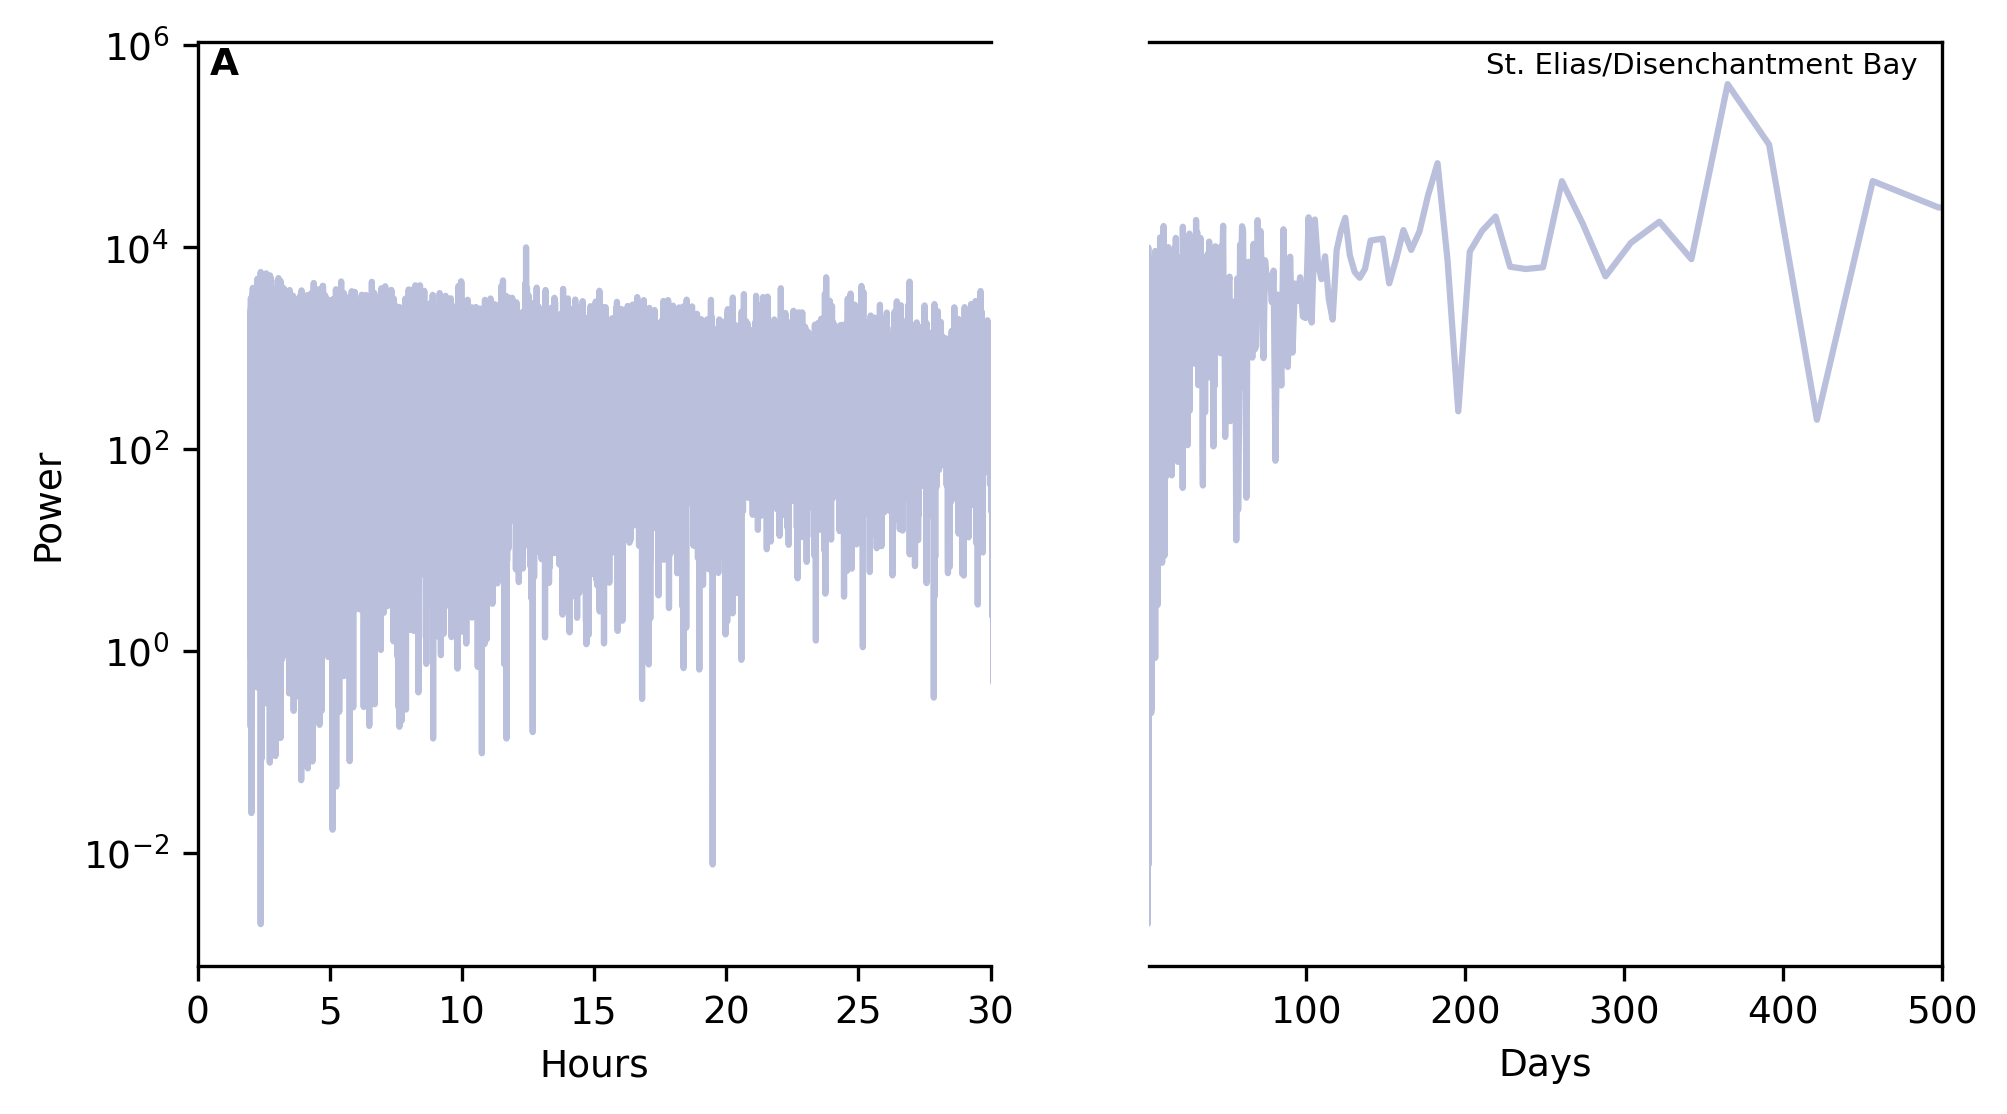

In [24]:
df_StDishourlyn = df_StDishourly[(df_StDishourly.index >='2010') & (df_StDishourly.index <'2025')]
freqsStDisMwh, psdStDisMwh = signal.periodogram(df_StDishourlyn.Mwh, fs=1/3600)
fwelStDisMwh, psdwelStDisMwh = signal.welch(df_StDishourlyn.Mwh, fs=1/3600)

Maghrw = 1/fwelStDisMwh/3600
Magdayw = 1/fwelStDisMwh/3600/24
Maghr = 1/freqsStDisMwh/3600
Magday = 1/freqsStDisMwh/3600/24

fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(7.5, 4))

ax1.plot(Maghr, psdStDisMwh, color='#8c96c6', alpha=0.6)
#ax1.plot(Maghrw, psdwelStDisMwh, color='black')
ax1.set_yscale('log')
ax1.set_xlim(0,30)
ax1.set_xlabel('Hours')
ax1.set_ylabel('Power')
ax1.spines['right'].set_visible(False)
ax1.text(0.015, 0.995, 'A', weight='bold', horizontalalignment='left', verticalalignment='top', fontsize=9, transform=ax1.transAxes)

ax2.plot(Magday, psdStDisMwh, color='#8c96c6', alpha=0.6)
#ax2.plot(Magdayw, psdwelStDisMwh, color='black')
ax2.set_yscale('log')
ax2.set_xlim(1,500)
ax2.set_xlabel('Days')
ax2.spines['left'].set_visible(False)
ax2.tick_params('y', left=False, labelleft=False)
ax2.text(0.97, 0.99, 'St. Elias/Disenchantment Bay', fontsize='7', horizontalalignment='right', verticalalignment='top', transform=ax2.transAxes)

os.chdir(Figures_folder)
plt.savefig('StEliasDisenchantmentPowerspectra.png', bbox_inches='tight')

C:\Users\alexd\AppData\Local\Temp\ipykernel_45080\135204191.py:5: RuntimeWarning: divide by zero encountered in divide
  Maghrw = 1/fwelStDisMwh/3600
C:\Users\alexd\AppData\Local\Temp\ipykernel_45080\135204191.py:6: RuntimeWarning: divide by zero encountered in divide
  Magdayw = 1/fwelStDisMwh/3600/24
C:\Users\alexd\AppData\Local\Temp\ipykernel_45080\135204191.py:7: RuntimeWarning: divide by zero encountered in divide
  Maghr = 1/freqsStDisMwh/3600
C:\Users\alexd\AppData\Local\Temp\ipykernel_45080\135204191.py:8: RuntimeWarning: divide by zero encountered in divide
  Magday = 1/freqsStDisMwh/3600/24
C:\Users\alexd\AppData\Local\Temp\ipykernel_45080\135204191.py:16: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax1.set_xlim(0,500)


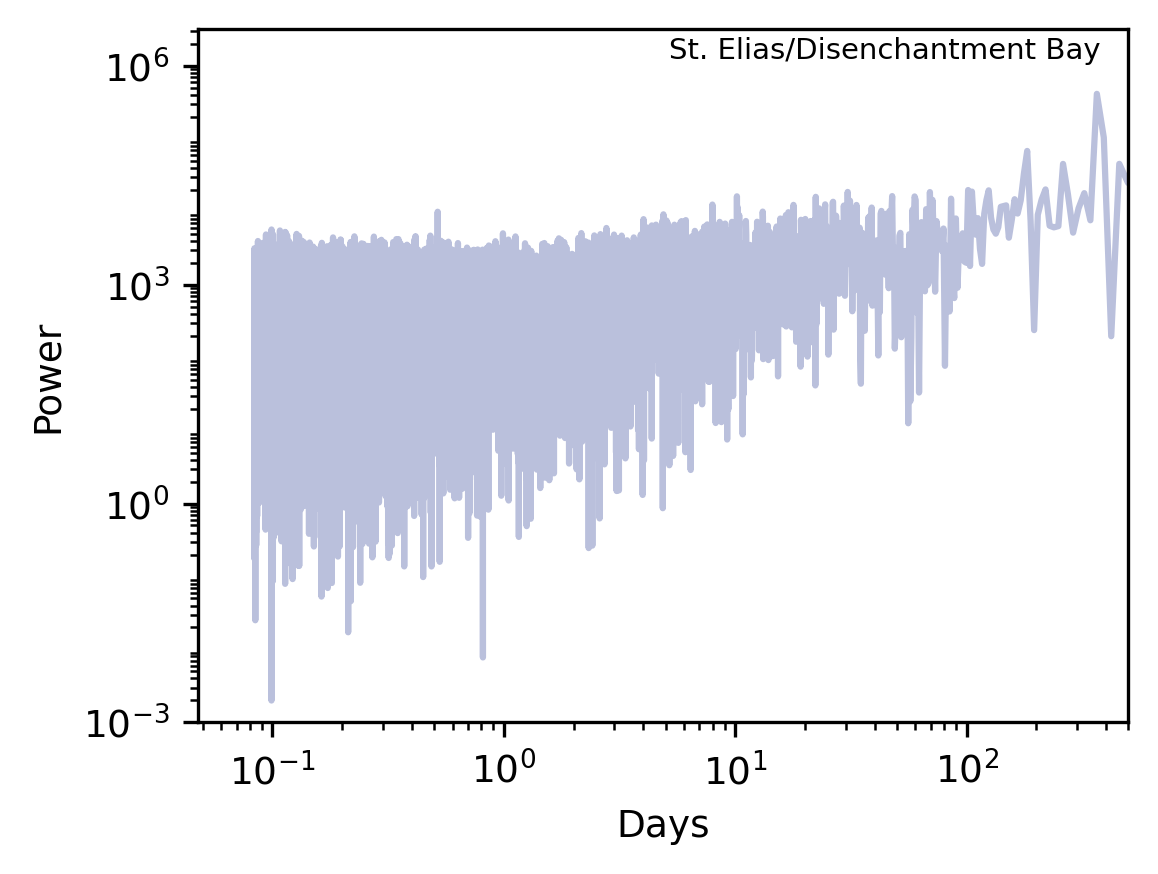

In [25]:
df_StDishourlyn = df_StDishourly[(df_StDishourly.index >='2010') & (df_StDishourly.index <'2025')]
freqsStDisMwh, psdStDisMwh = signal.periodogram(df_StDishourlyn.Mwh, fs=1/3600)
fwelStDisMwh, psdwelStDisMwh = signal.welch(df_StDishourlyn.Mwh, fs=1/3600)

Maghrw = 1/fwelStDisMwh/3600
Magdayw = 1/fwelStDisMwh/3600/24
Maghr = 1/freqsStDisMwh/3600
Magday = 1/freqsStDisMwh/3600/24

fig, (ax1) = plt.subplots(1,1, figsize=(4, 3))

ax1.plot(Magday, psdStDisMwh, color='#8c96c6', alpha=0.6)
#ax1.plot(Maghrw, psdwelStDisMwh, color='black')
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_xlim(0,500)
ax1.set_ylim(0.001,3162277)
ax1.set_yticks([0.001, 1, 1000, 1000000])
ax1.set_xlabel('Days')
ax1.set_ylabel('Power')
#ax1.text(0.015, 0.995, 'A', weight='bold', horizontalalignment='left', verticalalignment='top', fontsize=9, transform=ax1.transAxes)
ax1.text(0.97, 0.99, 'St. Elias/Disenchantment Bay', fontsize='7', horizontalalignment='right', verticalalignment='top', transform=ax1.transAxes)

os.chdir(Figures_folder)
plt.savefig('StElDisPowerContin.svg', bbox_inches='tight')

C:\Users\alexd\AppData\Local\Temp\ipykernel_45080\2217750660.py:5: RuntimeWarning: divide by zero encountered in divide
  Maghrw = 1/fwelStikMwh/3600
C:\Users\alexd\AppData\Local\Temp\ipykernel_45080\2217750660.py:6: RuntimeWarning: divide by zero encountered in divide
  Magdayw = 1/fwelStikMwh/3600/24
C:\Users\alexd\AppData\Local\Temp\ipykernel_45080\2217750660.py:8: RuntimeWarning: divide by zero encountered in divide
  Maghr = 1/freqsStikMwh/3600
C:\Users\alexd\AppData\Local\Temp\ipykernel_45080\2217750660.py:9: RuntimeWarning: divide by zero encountered in divide
  Magday = 1/freqsStikMwh/3600/24


(1.0, 365.0)

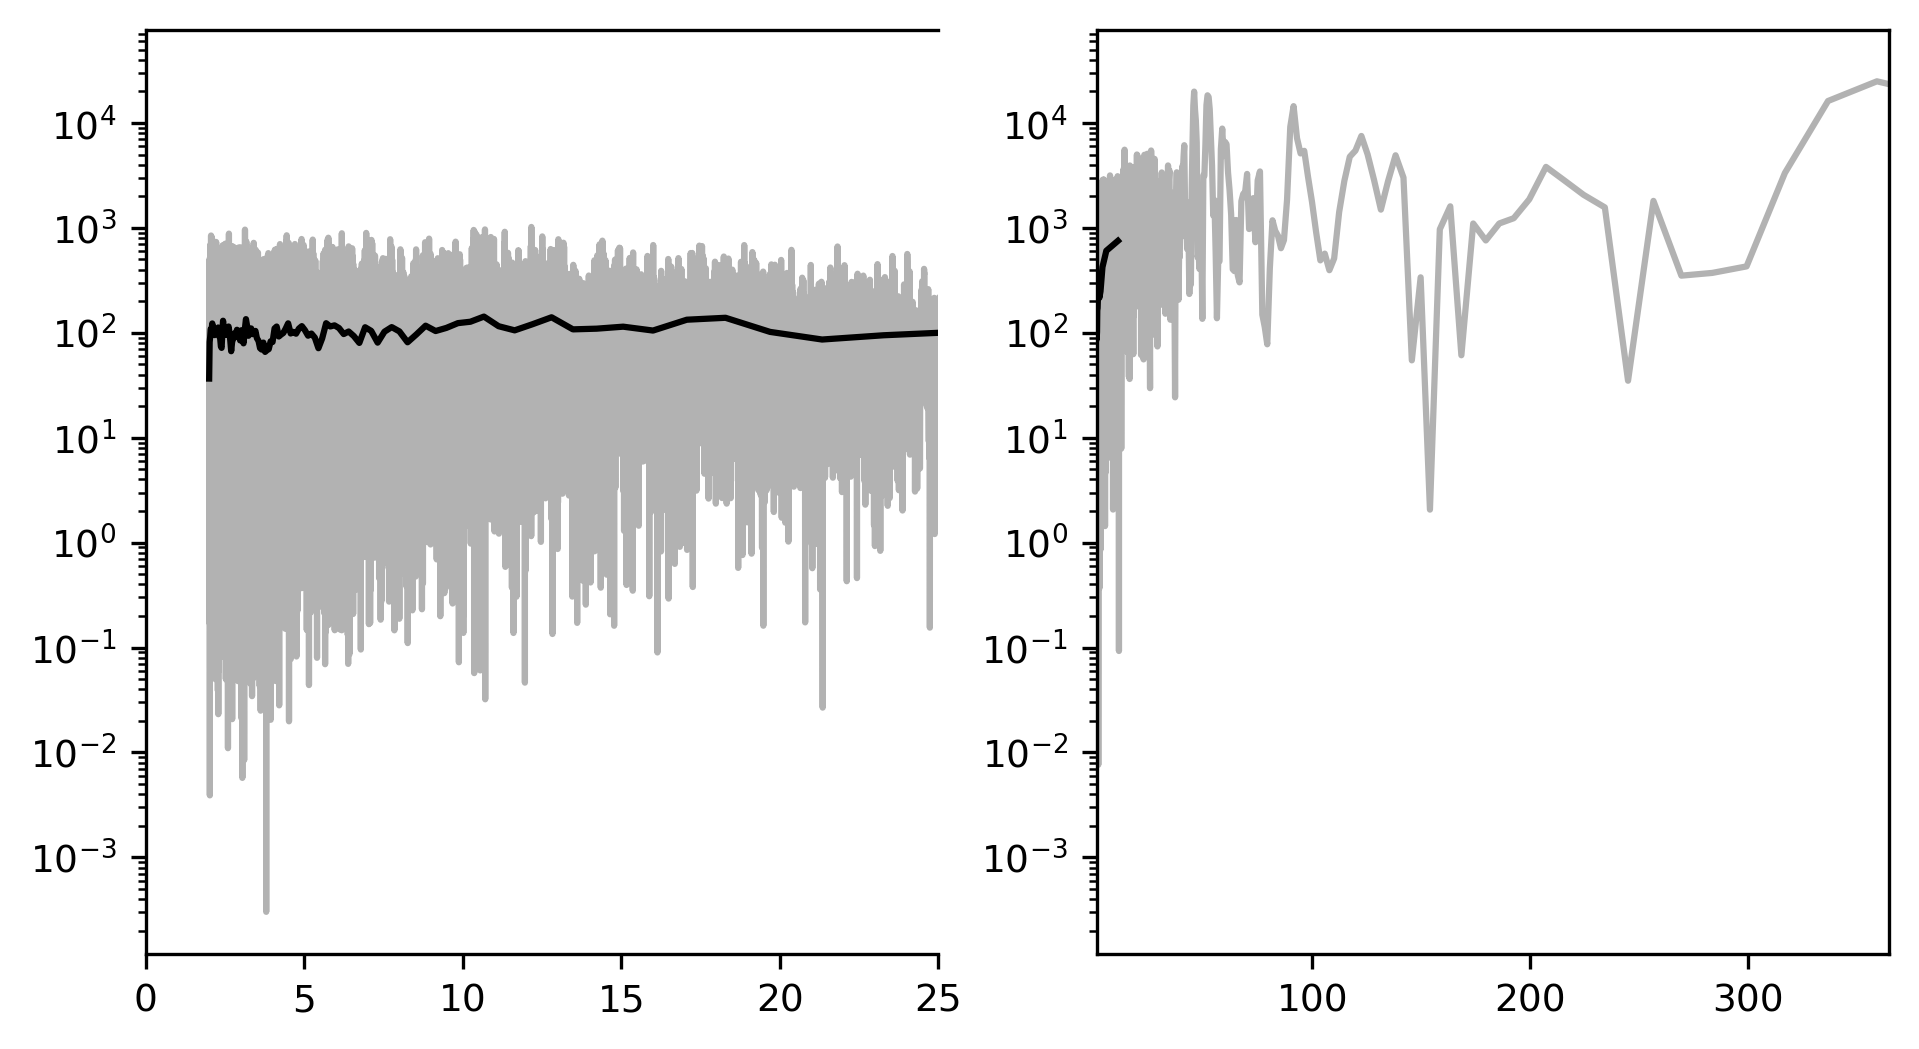

In [26]:
df_Stikhourlyn = df_Stikhourly[(df_Stikhourly.index >='2010') & (df_Stikhourly.index <'2025')]
freqsStikMwh, psdStikMwh = signal.periodogram(df_Stikhourlyn.Mwh, fs=1/3600)
fwelStikMwh, psdwelStikMwh = signal.welch(df_Stikhourlyn.Mwh, fs=1/3600)

Maghrw = 1/fwelStikMwh/3600
Magdayw = 1/fwelStikMwh/3600/24

Maghr = 1/freqsStikMwh/3600
Magday = 1/freqsStikMwh/3600/24

fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(7.5, 4))

ax1.plot(Maghr, psdStikMwh, color='grey', alpha=0.6)
ax1.plot(Maghrw, psdwelStikMwh, color='black')
ax1.set_yscale('log')
ax1.set_xlim(0,25)
ax1.spines['right'].set_visible(False)

ax2.plot(Magday, psdStikMwh, color='grey', alpha=0.6)
ax2.plot(Magdayw, psdwelStikMwh, color='black')
ax2.set_yscale('log')
ax2.set_xlim(1,365)

C:\Users\alexd\AppData\Local\Temp\ipykernel_45080\3321568709.py:5: RuntimeWarning: divide by zero encountered in divide
  Maghrw = 1/fwelAKRngMwh/3600
C:\Users\alexd\AppData\Local\Temp\ipykernel_45080\3321568709.py:6: RuntimeWarning: divide by zero encountered in divide
  Magdayw = 1/fwelAKRngMwh/3600/24
C:\Users\alexd\AppData\Local\Temp\ipykernel_45080\3321568709.py:7: RuntimeWarning: divide by zero encountered in divide
  Maghr = 1/freqsAKRngMwh/3600
C:\Users\alexd\AppData\Local\Temp\ipykernel_45080\3321568709.py:8: RuntimeWarning: divide by zero encountered in divide
  Magday = 1/freqsAKRngMwh/3600/24


(1.0, 365.0)

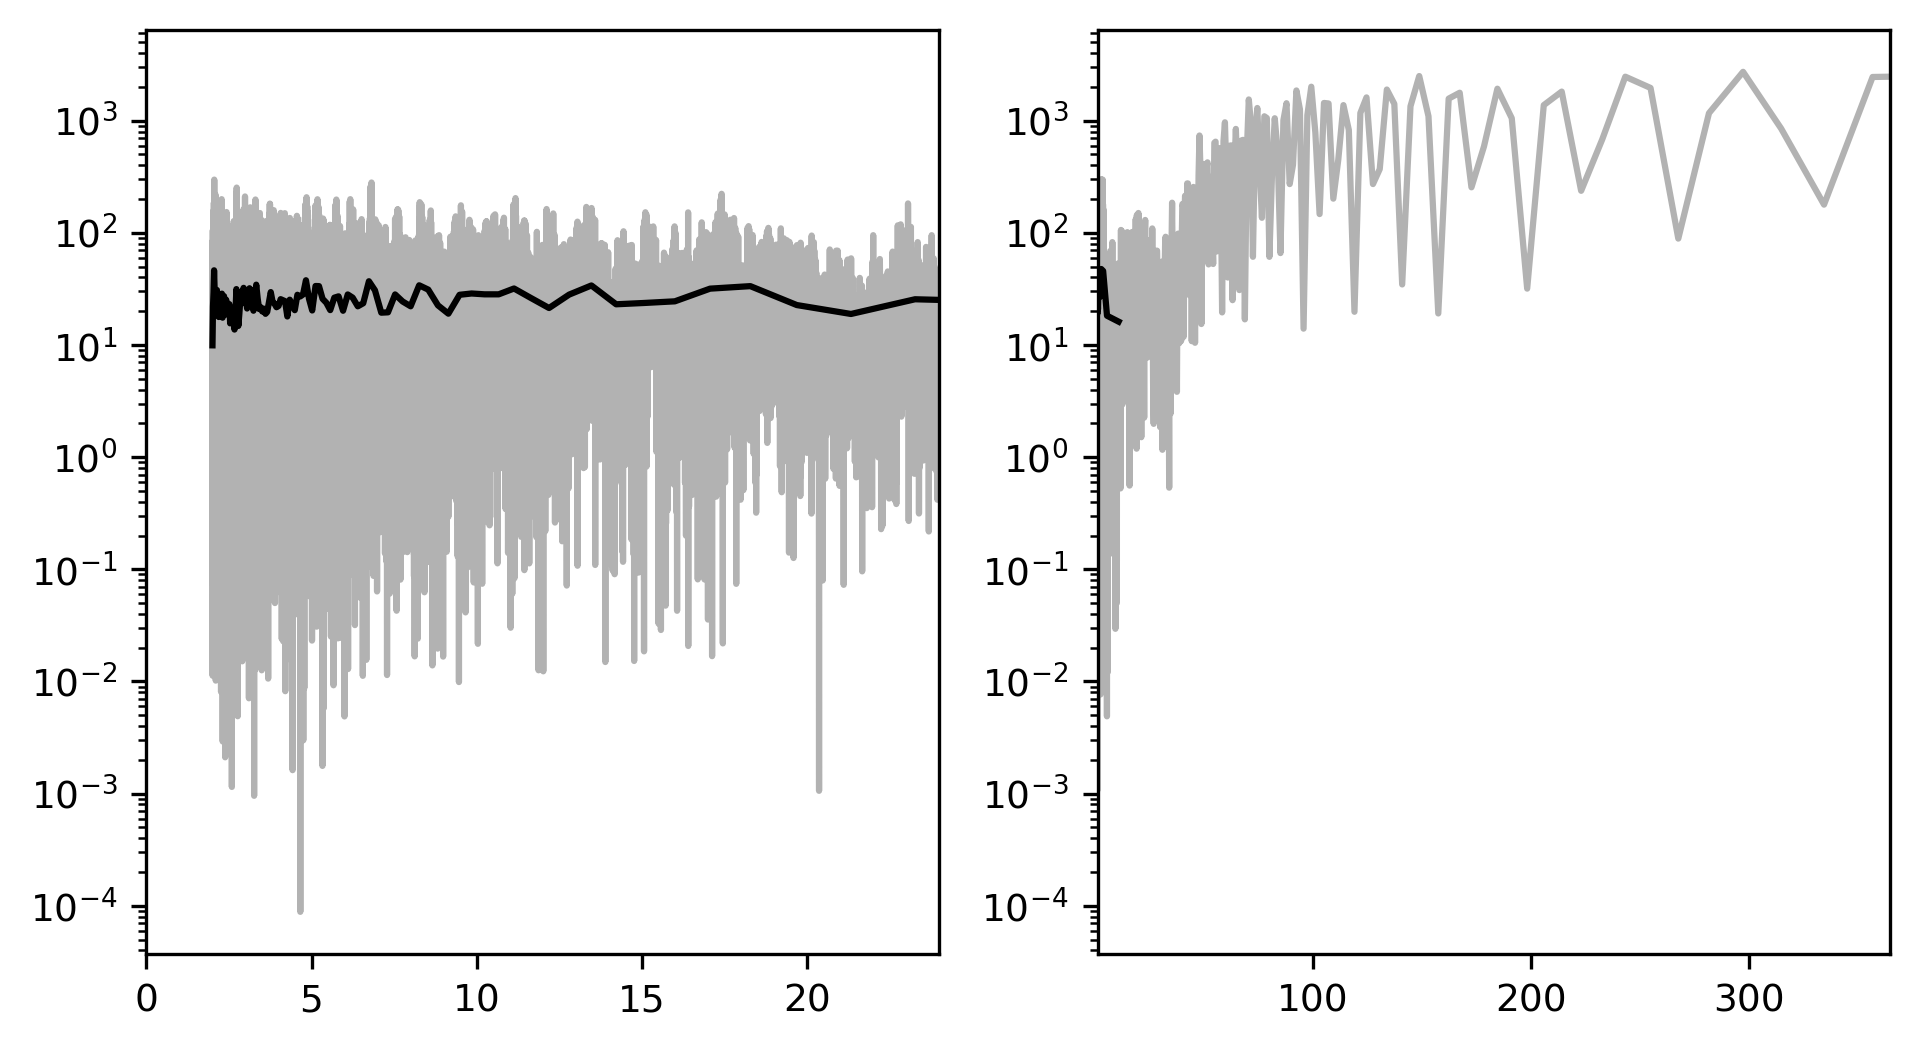

In [27]:
df_AKRnghourlyn = df_AlRnghourly[(df_AlRnghourly.index >='2010') & (df_AlRnghourly.index <'2025')]
freqsAKRngMwh, psdAKRngMwh = signal.periodogram(df_AKRnghourlyn.Mwh, fs=1/3600)
fwelAKRngMwh, psdwelAKRngMwh = signal.welch(df_AKRnghourlyn.Mwh, fs=1/3600)

Maghrw = 1/fwelAKRngMwh/3600
Magdayw = 1/fwelAKRngMwh/3600/24
Maghr = 1/freqsAKRngMwh/3600
Magday = 1/freqsAKRngMwh/3600/24

fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(7.5, 4))
ax1.plot(Maghr, psdAKRngMwh, color='grey', alpha=0.6)
ax1.plot(Maghrw, psdwelAKRngMwh, color='black')
ax1.set_yscale('log')
ax1.set_xlim(0,24)
ax2.plot(Magday, psdAKRngMwh, color='grey', alpha=0.6)
ax2.plot(Magdayw, psdwelAKRngMwh, color='black')
ax2.set_yscale('log')
ax2.set_xlim(1,365)

C:\Users\alexd\AppData\Local\Temp\ipykernel_45080\3339167357.py:5: RuntimeWarning: divide by zero encountered in divide
  Maghrw = 1/fwelWranMwh/3600
C:\Users\alexd\AppData\Local\Temp\ipykernel_45080\3339167357.py:6: RuntimeWarning: divide by zero encountered in divide
  Magdayw = 1/fwelWranMwh/3600/24
C:\Users\alexd\AppData\Local\Temp\ipykernel_45080\3339167357.py:7: RuntimeWarning: divide by zero encountered in divide
  Maghr = 1/freqsWranMwh/3600
C:\Users\alexd\AppData\Local\Temp\ipykernel_45080\3339167357.py:8: RuntimeWarning: divide by zero encountered in divide
  Magday = 1/freqsWranMwh/3600/24


(1.0, 365.0)

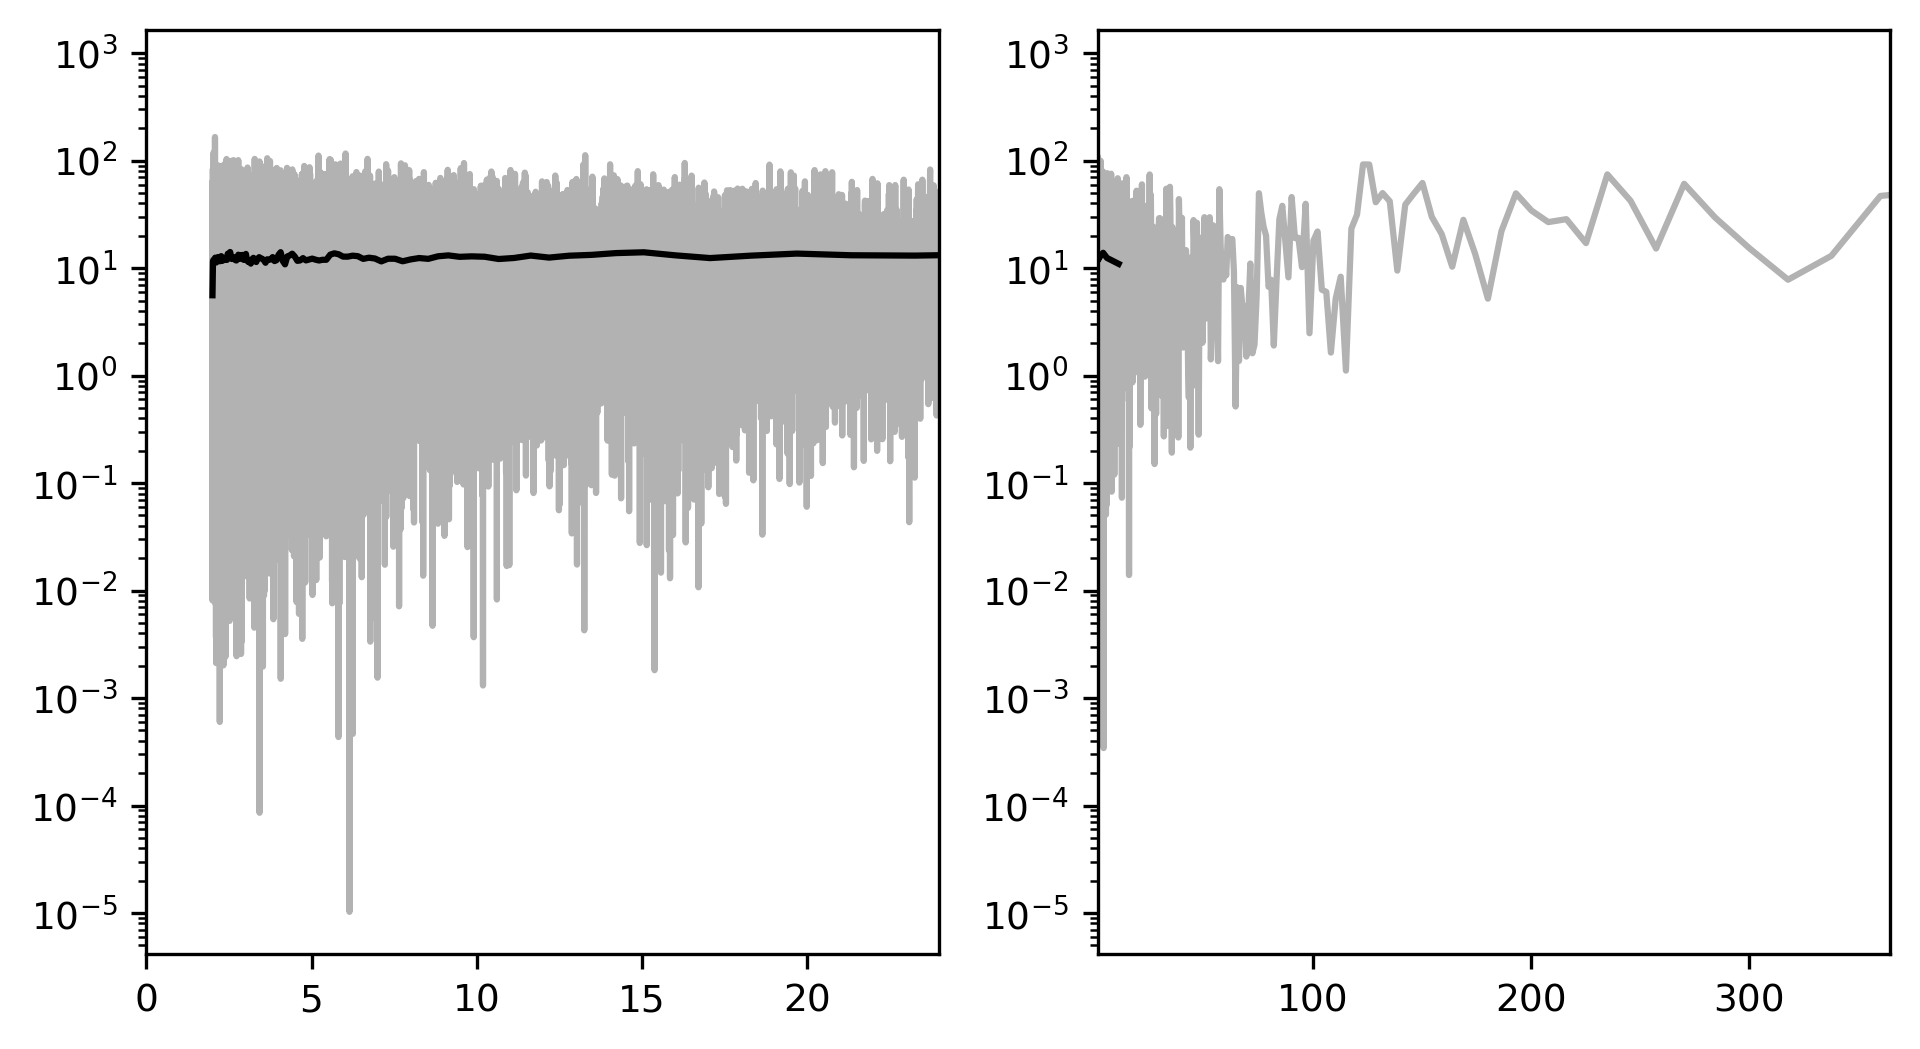

In [28]:
df_Wranhourlyn = df_Wranhourly[(df_Wranhourly.index >='2010') & (df_Wranhourly.index <'2025')]
freqsWranMwh, psdWranMwh = signal.periodogram(df_Wranhourlyn.Mwh, fs=1/3600)
fwelWranMwh, psdwelWranMwh = signal.welch(df_Wranhourlyn.Mwh, fs=1/3600)

Maghrw = 1/fwelWranMwh/3600
Magdayw = 1/fwelWranMwh/3600/24
Maghr = 1/freqsWranMwh/3600
Magday = 1/freqsWranMwh/3600/24

fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(7.5, 4))
ax1.plot(Maghr, psdWranMwh, color='grey', alpha=0.6)
ax1.plot(Maghrw, psdwelWranMwh, color='black')
ax1.set_yscale('log')
ax1.set_xlim(0,24)

ax2.plot(Magday, psdWranMwh, color='grey', alpha=0.6)
ax2.plot(Magdayw, psdwelWranMwh, color='black')
ax2.set_yscale('log')
ax2.set_xlim(1,365)

C:\Users\alexd\AppData\Local\Temp\ipykernel_45080\3928313906.py:1: FutureWarning: 'w' is deprecated and will be removed in a future version, please use 'W' instead.
  df_StDisweekly = df_StDis.resample('w').sum()
C:\Users\alexd\AppData\Local\Temp\ipykernel_45080\3928313906.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_StDisweeklyk['time_s']=pd.to_timedelta(df_StDisweeklyk.index.values-df_StDisweeklyk.index.values.min(), unit='s').total_seconds()


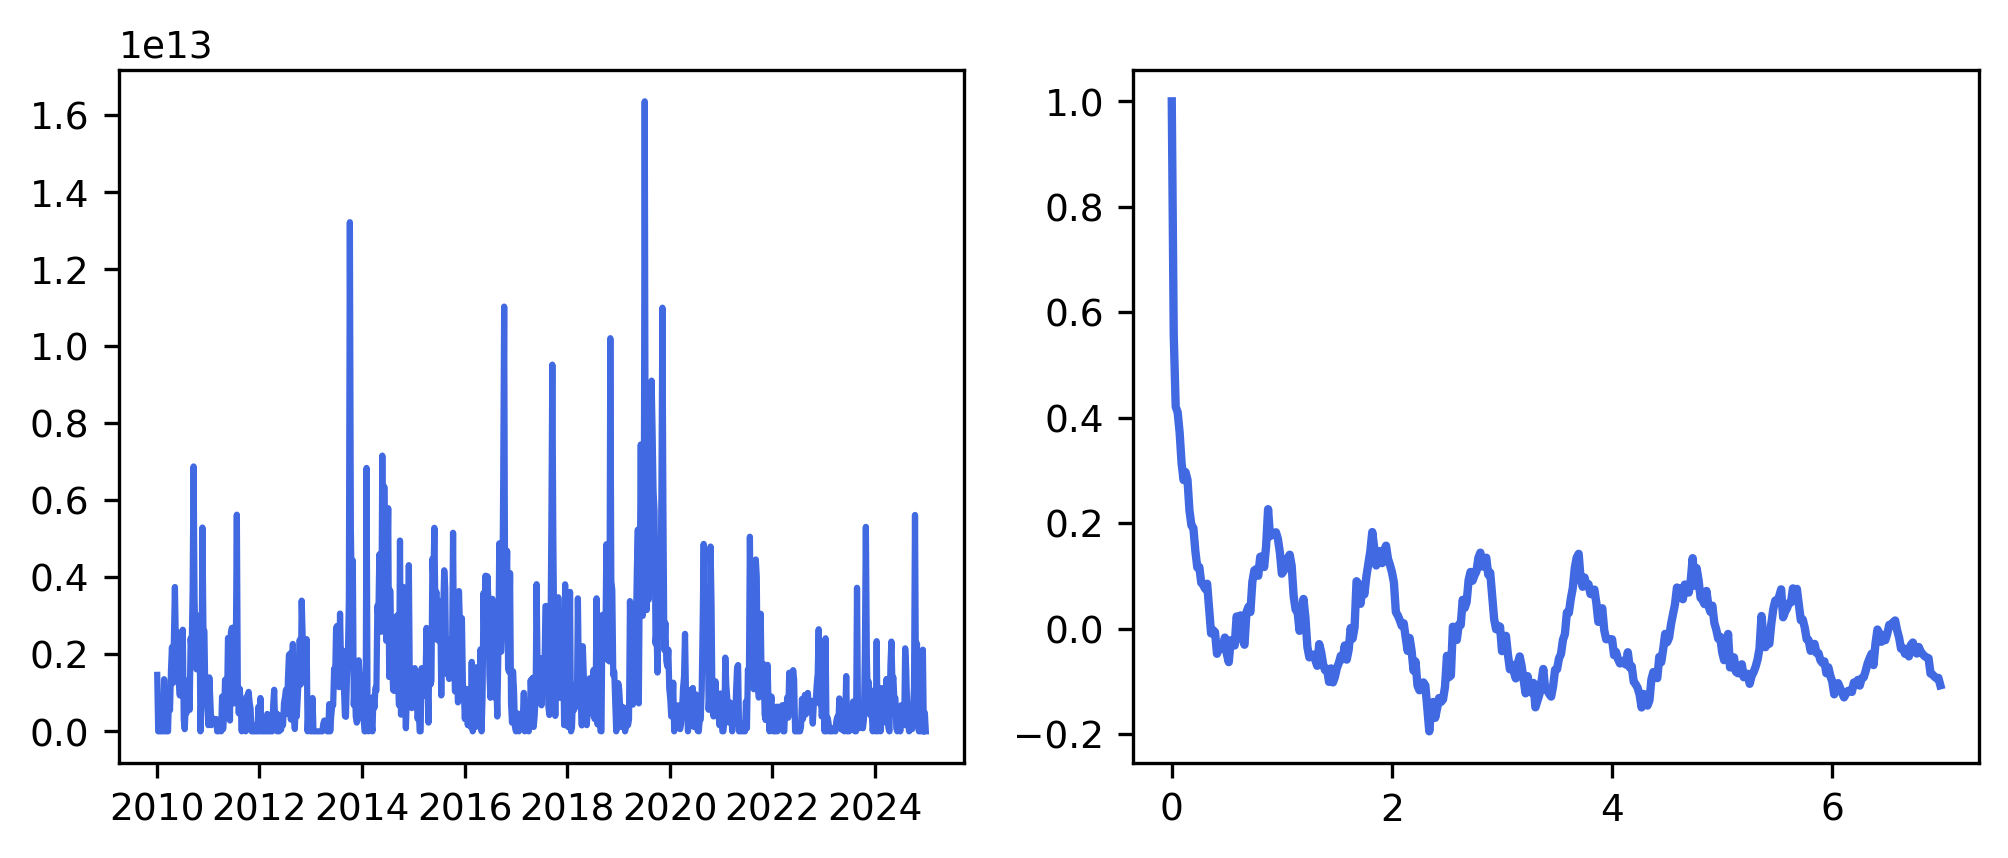

In [29]:
df_StDisweekly = df_StDis.resample('w').sum()
df_StDisweeklyk = df_StDisweekly[(df_StDisweekly.index >='2010') & (df_StDisweekly.index <'2025')]
df_StDisweeklyk.index = df_StDisweeklyk.index.tz_localize(None)

df_StDisweeklyk['time_s']=pd.to_timedelta(df_StDisweeklyk.index.values-df_StDisweeklyk.index.values.min(), unit='s').total_seconds()

acorrStDisweekly = sm.tsa.acf(df_StDisweeklyk.M0, nlags = int(len(df_StDisweeklyk.M0)/2),fft=True)
x_corrStDisweekly = np.arange(0,int((len(df_StDisweeklyk))/2)+1,1)/56

fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(8, 3))

ax1.plot(df_StDisweeklyk.M0,'-',color='royalblue')
ax2.plot(x_corrStDisweekly,acorrStDisweekly,'-',color='royalblue',linewidth=2)

C:\Users\alexd\AppData\Local\Temp\ipykernel_45080\2891804793.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_StDishourlyk['time_s']=pd.to_timedelta(df_StDishourlyk.index.values-df_StDishourlyk.index.values.min(), unit='s').total_seconds()
C:\Users\alexd\AppData\Local\Temp\ipykernel_45080\2891804793.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_StDishourlyless['time_s']=pd.to_timedelta(df_StDishourlyless.index.values-df_StDishourlyless.index.values.min(), unit='s').total_seconds()


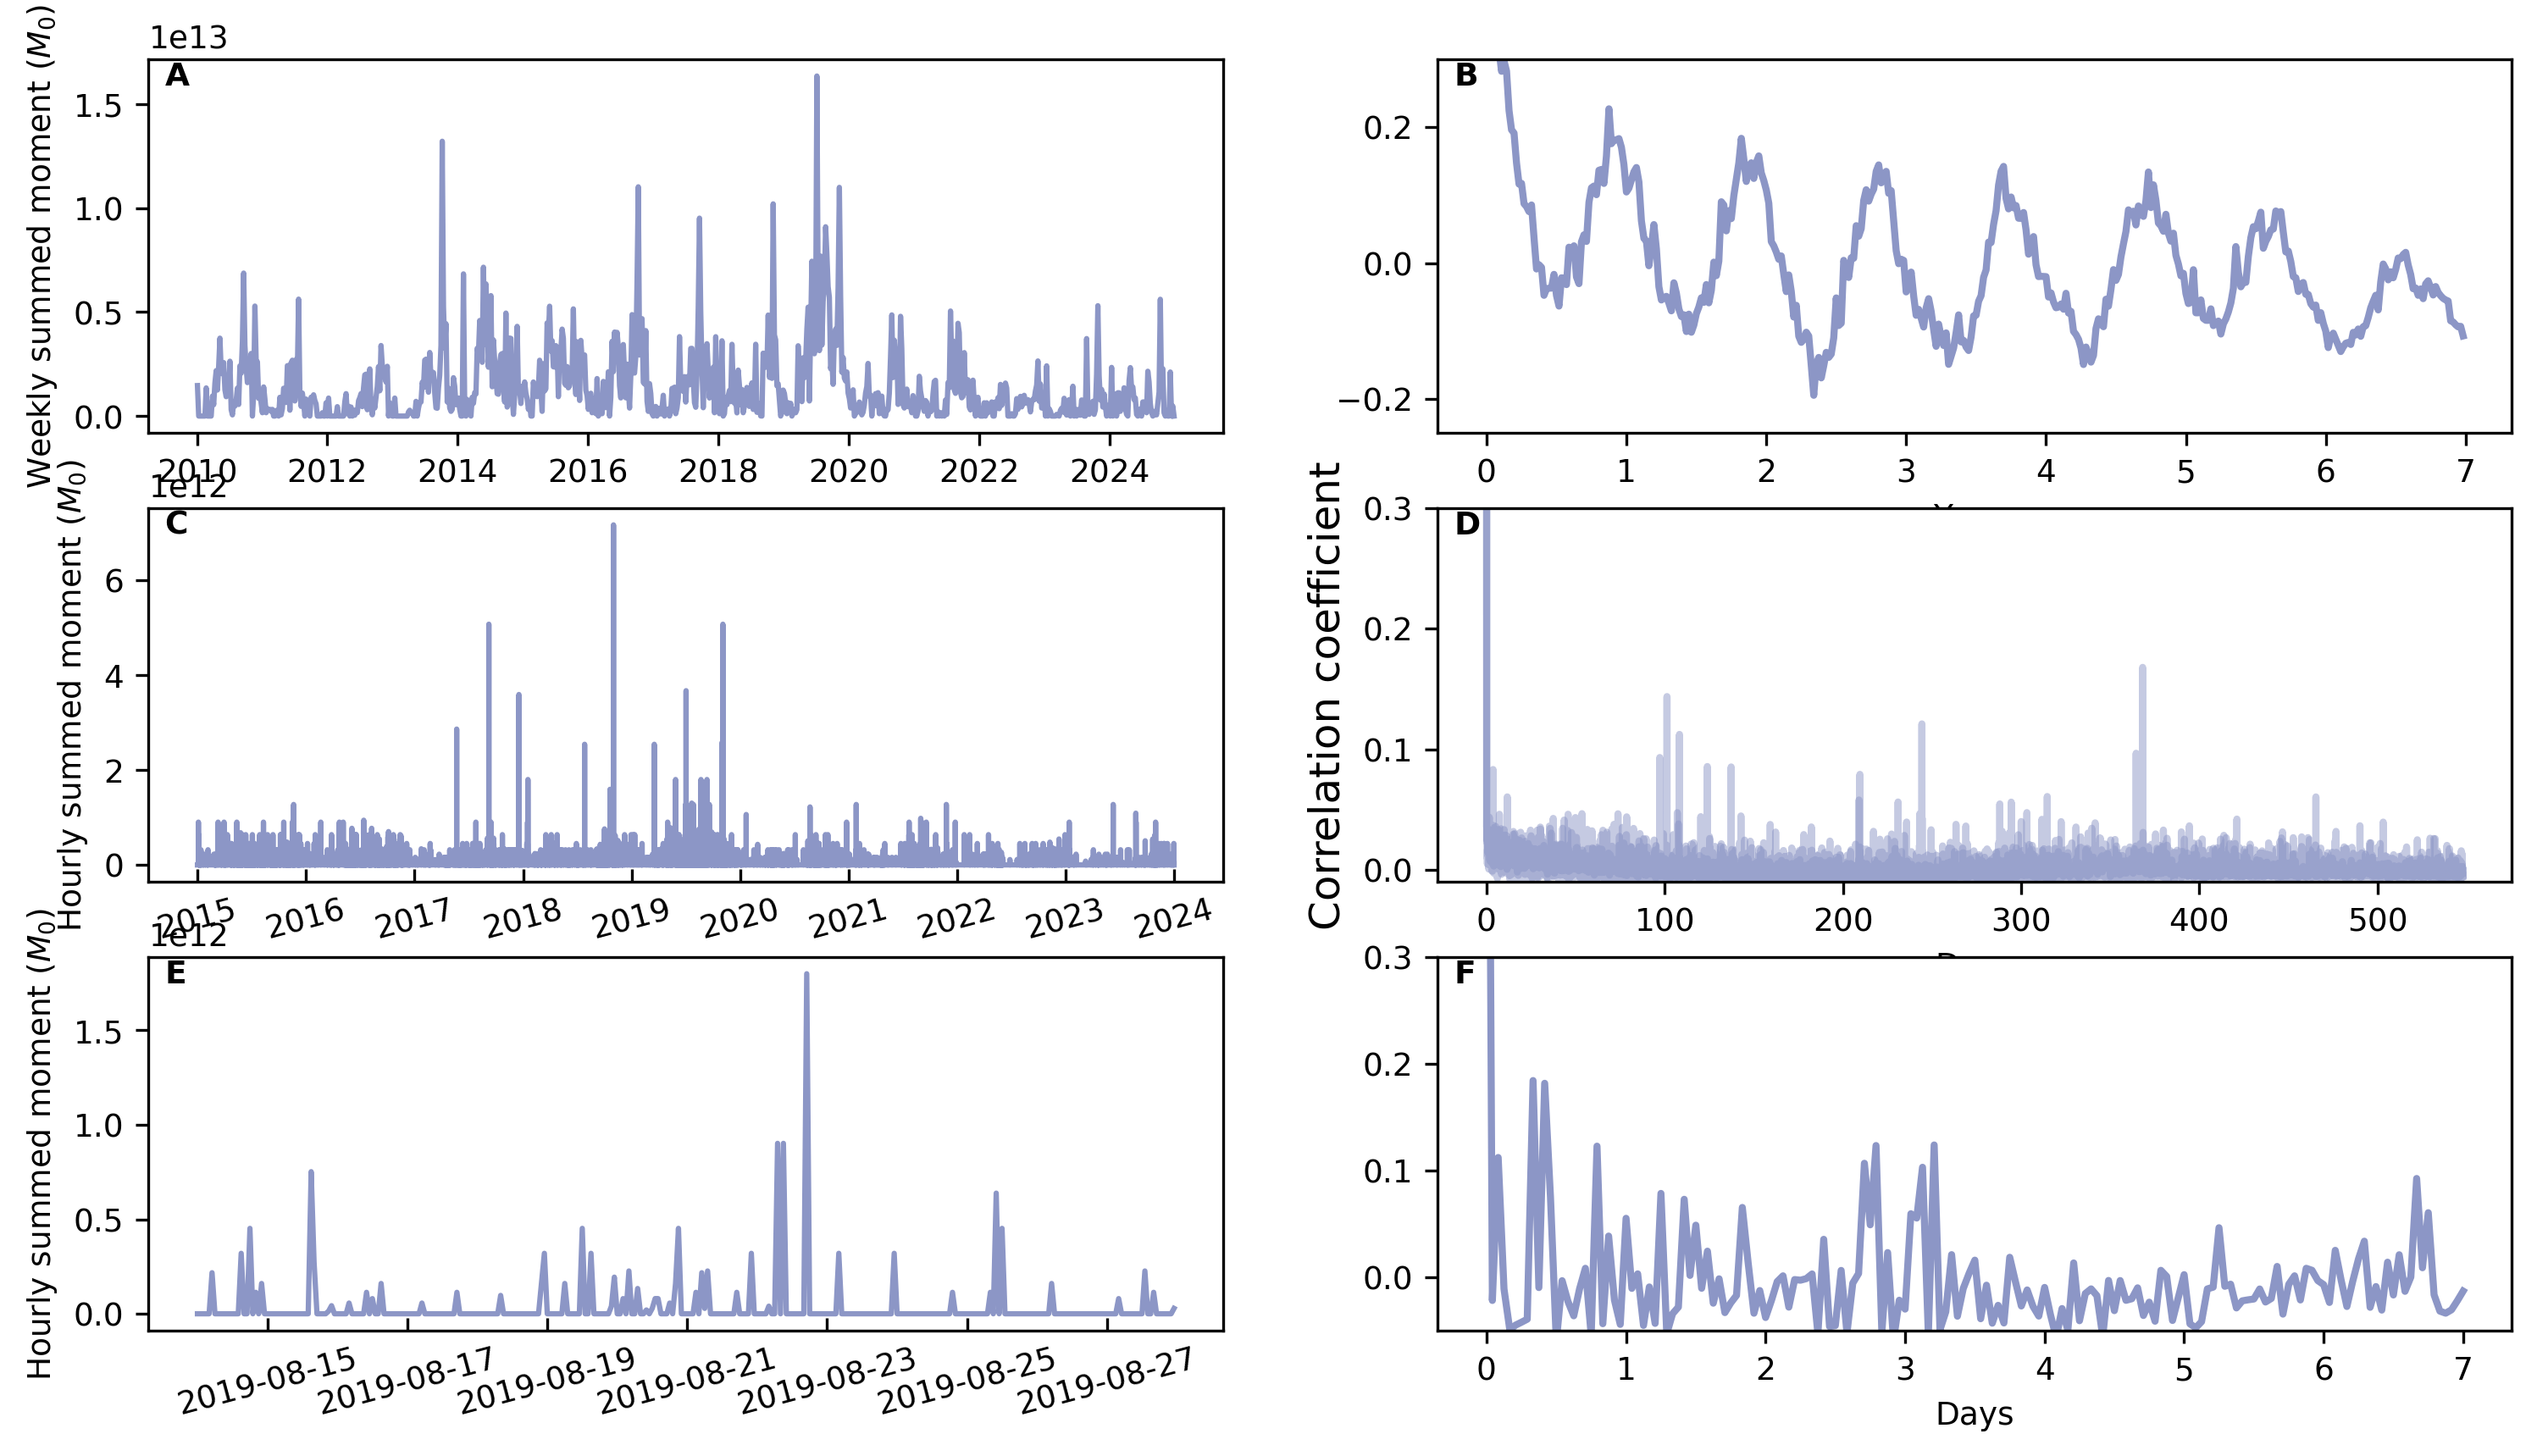

In [30]:
df_StDishourly = df_StDis.resample('h').sum()
df_StDishourlyk = df_StDishourly[(df_StDishourly.index >='2018') & (df_StDishourly.index <'2021')]
df_StDishourlyk.index = df_StDishourlyk.index.tz_localize(None)
df_StDishourlyless = df_StDishourly[(df_StDishourly.index >='2019-08-14') & (df_StDishourly.index <'2019-08-28')]
df_StDishourlyless.index = df_StDishourlyless.index.tz_localize(None)
df_StDishourlykk = df_StDishourly[(df_StDishourly.index >='2015') & (df_StDishourly.index <'2018')]
df_StDishourlykk.index = df_StDishourlykk.index.tz_localize(None)
df_StDishourlykkk = df_StDishourly[(df_StDishourly.index >='2021') & (df_StDishourly.index <'2024')]


df_StDishourlyk['time_s']=pd.to_timedelta(df_StDishourlyk.index.values-df_StDishourlyk.index.values.min(), unit='s').total_seconds()
df_StDishourlyless['time_s']=pd.to_timedelta(df_StDishourlyless.index.values-df_StDishourlyless.index.values.min(), unit='s').total_seconds()

acorrStDishourly = sm.tsa.acf(df_StDishourlyk.M0, nlags = int(len(df_StDishourlyk.M0)/2),fft=True)
x_corrStDishourly = np.arange(0,int((len(df_StDishourlyk))/2)+1,1)/24
acorrStDishourlykk = sm.tsa.acf(df_StDishourlykk.M0, nlags = int(len(df_StDishourlykk.M0)/2),fft=True)
x_corrStDishourlykk = np.arange(0,int((len(df_StDishourlykk))/2)+1,1)/24
acorrStDishourlyless = sm.tsa.acf(df_StDishourlyless.M0, nlags = int(len(df_StDishourlyless.M0)/2),fft=True)
x_corrStDishourlyless = np.arange(0,int((len(df_StDishourlyless))/2)+1,1)/24
acorrStDishourlykkk = sm.tsa.acf(df_StDishourlykkk.M0, nlags = int(len(df_StDishourlykkk.M0)/2),fft=True)
x_corrStDishourlykkk = np.arange(0,int((len(df_StDishourlykkk))/2)+1,1)/24

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(12, 6.5))


ax1.plot(df_StDisweeklyk.M0,'-',color='#8c96c6')
ax1.text(0.015, 0.995, 'A', weight='bold', horizontalalignment='left', verticalalignment='top', fontsize=9, transform=ax1.transAxes)
ax1.set_ylabel('Weekly summed moment $(M_0)$')
ax2.plot(x_corrStDisweekly,acorrStDisweekly,'-',color='#8c96c6',linewidth=2)
ax2.set_xlabel('Years')
ax2.text(0.015, 0.995, 'B', weight='bold', horizontalalignment='left', verticalalignment='top', fontsize=9, transform=ax2.transAxes)
ax2.set_ylim(-0.25,0.3)

ax3.plot(df_StDishourlyk.M0,'-',color='#8c96c6')
ax3.plot(df_StDishourlykk.M0,'-',color='#8c96c6')
ax3.plot(df_StDishourlykkk.M0,'-',color='#8c96c6')
ax3.set_ylabel('Hourly summed moment $(M_0)$')
ax3.text(0.015, 0.995, 'C', weight='bold', horizontalalignment='left', verticalalignment='top', fontsize=9, transform=ax3.transAxes)
ax3.tick_params(axis='x', labelrotation=15, direction='in')
ax4.plot(x_corrStDishourly,acorrStDishourly,'-',color='#8c96c6',alpha=0.5, linewidth=2)
ax4.plot(x_corrStDishourlykk,acorrStDishourlykk,'-',color='#8c96c6', alpha=0.5,linewidth=2)
ax4.plot(x_corrStDishourlykkk,acorrStDishourlykkk,'-',color='#8c96c6', alpha=0.5, linewidth=2)
ax4.set_ylabel('Correlation coefficient', fontsize=12)
ax4.set_xlabel('Days')
ax4.text(0.015, 0.995, 'D', weight='bold', horizontalalignment='left', verticalalignment='top', fontsize=9, transform=ax4.transAxes)
ax4.set_ylim(-0.01,0.3)

ax5.plot(df_StDishourlyless.M0,'-',color='#8c96c6')
ax5.tick_params(axis='x', labelrotation=15, direction='in')
ax5.set_ylabel('Hourly summed moment $(M_0)$')
ax5.text(0.015, 0.995, 'E', weight='bold', horizontalalignment='left', verticalalignment='top', fontsize=9, transform=ax5.transAxes)
ax6.plot(x_corrStDishourlyless,acorrStDishourlyless,'-',color='#8c96c6',linewidth=2)
ax6.set_xlabel('Days')
ax6.text(0.015, 0.995, 'F', weight='bold', horizontalalignment='left', verticalalignment='top', fontsize=9, transform=ax6.transAxes)
ax6.set_ylim(-0.05,0.3)

os.chdir(Figures_folder)
plt.savefig('StElDisBayAutoCorr.png', bbox_inches='tight')

C:\Users\alexd\AppData\Local\Temp\ipykernel_45080\2219632273.py:5: RuntimeWarning: divide by zero encountered in divide
  Maghrw = 1/fwelStDisMwh/3600
C:\Users\alexd\AppData\Local\Temp\ipykernel_45080\2219632273.py:6: RuntimeWarning: divide by zero encountered in divide
  Magdayw = 1/fwelStDisMwh/3600/24
C:\Users\alexd\AppData\Local\Temp\ipykernel_45080\2219632273.py:7: RuntimeWarning: divide by zero encountered in divide
  Maghr = 1/freqsStDisMwh/3600
C:\Users\alexd\AppData\Local\Temp\ipykernel_45080\2219632273.py:8: RuntimeWarning: divide by zero encountered in divide
  Magday = 1/freqsStDisMwh/3600/24


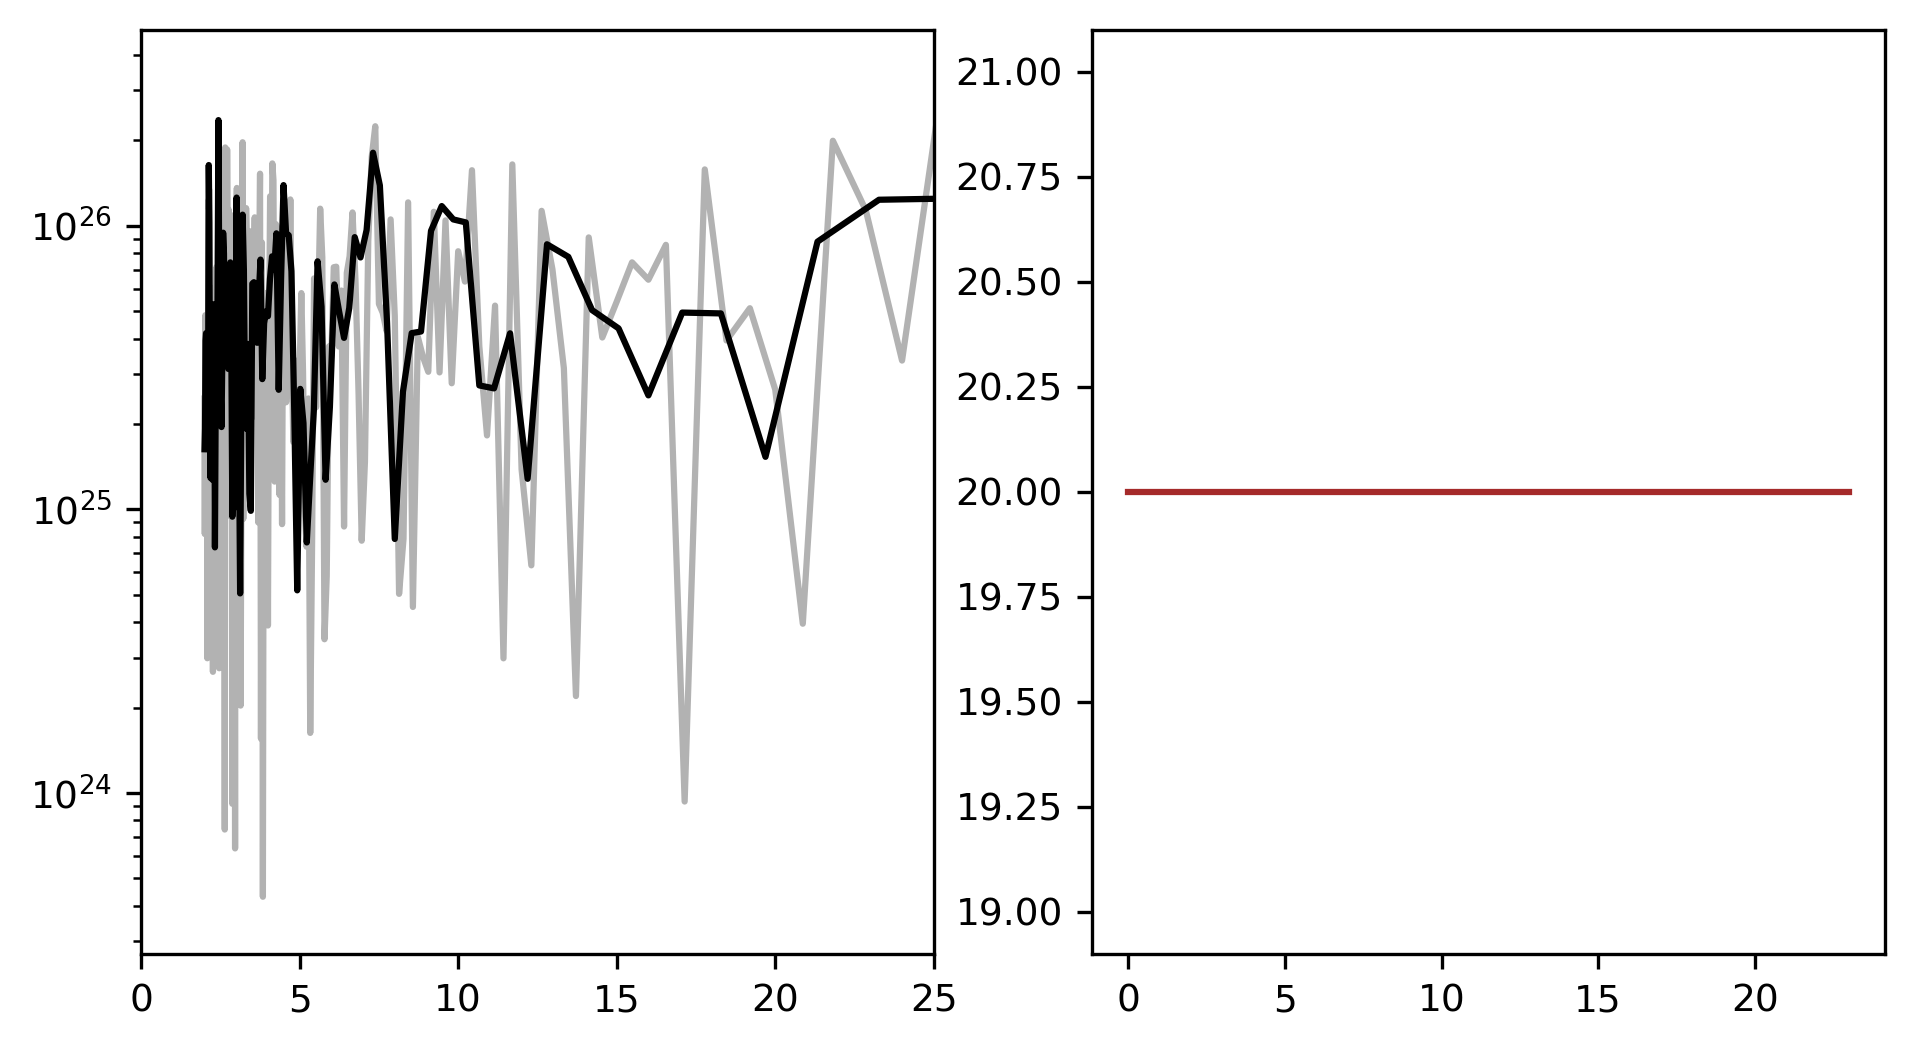

In [31]:
df_StDishourlyn = df_StDishourly[(df_StDishourly.index >='2019-08-01') & (df_StDishourly.index <'2019-08-21')]
freqsStDisMwh, psdStDisMwh = signal.periodogram(df_StDishourlyn.M0, fs=1/3600)
fwelStDisMwh, psdwelStDisMwh = signal.welch(df_StDishourlyn.M0, fs=1/3600)

Maghrw = 1/fwelStDisMwh/3600
Magdayw = 1/fwelStDisMwh/3600/24
Maghr = 1/freqsStDisMwh/3600
Magday = 1/freqsStDisMwh/3600/24

fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(7.5, 4))

ax1.plot(Maghr, psdStDisMwh, color='grey', alpha=0.6)
ax1.plot(Maghrw, psdwelStDisMwh, color='black')
ax1.set_yscale('log')
ax1.set_xlim(0,25)

#ax2.plot(Magday, psdStDisMwh, color='grey', alpha=0.6)
#ax2.plot(Magdayw, psdwelStDisMwh, color='black')
#ax2.set_yscale('log')
#ax2.set_xlim(1,90)

ax2.plot(df_StDishourlyn.groupby(df_StDishourlyn.index.hour).size(),color='brown')

In [32]:
gdf_AlRng = gpd.GeoDataFrame(df_AlRng, geometry=gpd.points_from_xy(df_AlRng.longitude, df_AlRng.latitude), crs='epsg:32662')
gdf_Ken = gpd.GeoDataFrame(df_Ken, geometry=gpd.points_from_xy(df_Ken.longitude, df_Ken.latitude), crs='epsg:32662')
gdf_Chugach = gpd.GeoDataFrame(df_Chugach, geometry=gpd.points_from_xy(df_Chugach.longitude, df_Chugach.latitude), crs='epsg:32662')
gdf_Wran = gpd.GeoDataFrame(df_Wran, geometry=gpd.points_from_xy(df_Wran.longitude, df_Wran.latitude), crs='epsg:32662')
gdf_StDis = gpd.GeoDataFrame(df_StDis, geometry=gpd.points_from_xy(df_StDis.longitude, df_StDis.latitude), crs='epsg:32662')
gdf_GlBFair = gpd.GeoDataFrame(df_GlBFair, geometry=gpd.points_from_xy(df_GlBFair.longitude, df_GlBFair.latitude), crs='epsg:32662')
gdf_JunIce = gpd.GeoDataFrame(df_JunIce, geometry=gpd.points_from_xy(df_JunIce.longitude, df_JunIce.latitude), crs='epsg:32662')
gdf_Stik = gpd.GeoDataFrame(df_Stik, geometry=gpd.points_from_xy(df_Stik.longitude, df_Stik.latitude), crs='epsg:32662')


Text(0.01, 0.995, 'A')

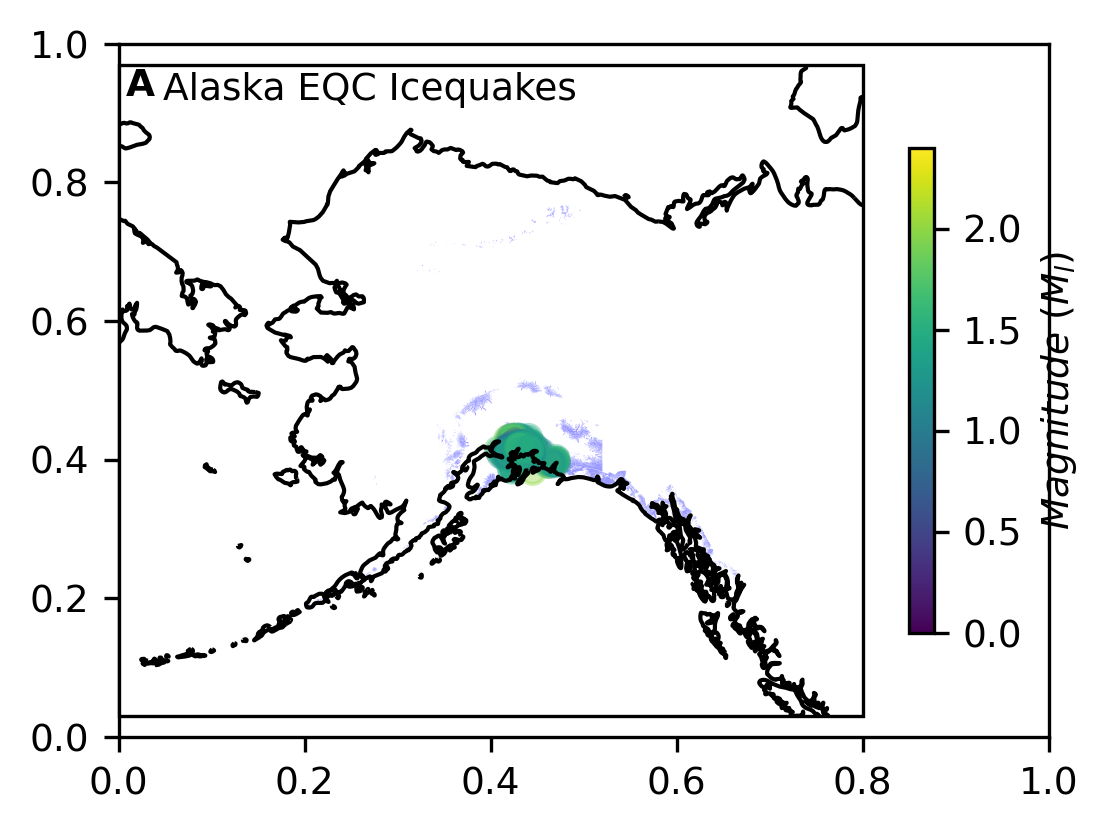

In [33]:
fig, ((axAK)) = plt.subplots(1, 1, figsize=(4, 3))

axAK = fig.add_subplot(projection=ccrs.Mercator())
axAK.coastlines()
AKs.plot(ax=axAK, transform=ccrs.Mercator(), alpha=1, marker = 's', color='#9999FF')
gdf_Chugach.plot(ax=axAK, transform=ccrs.PlateCarree(), column='Mw', cmap='viridis', legend=True, alpha=0.4, legend_kwds={'label': '$Magnitude$ $(M_l)$', 'shrink':0.7})
axAK.set_extent([-180, -120, 49, 73], crs=ccrs.PlateCarree())
axAK.text(0.06, 0.99, 'Alaska EQC Icequakes', horizontalalignment='left', verticalalignment='top', fontsize=9, transform=axAK.transAxes)
axAK.text(0.01, 0.995, 'A', weight='bold', horizontalalignment='left', verticalalignment='top', fontsize=9, transform=axAK.transAxes)

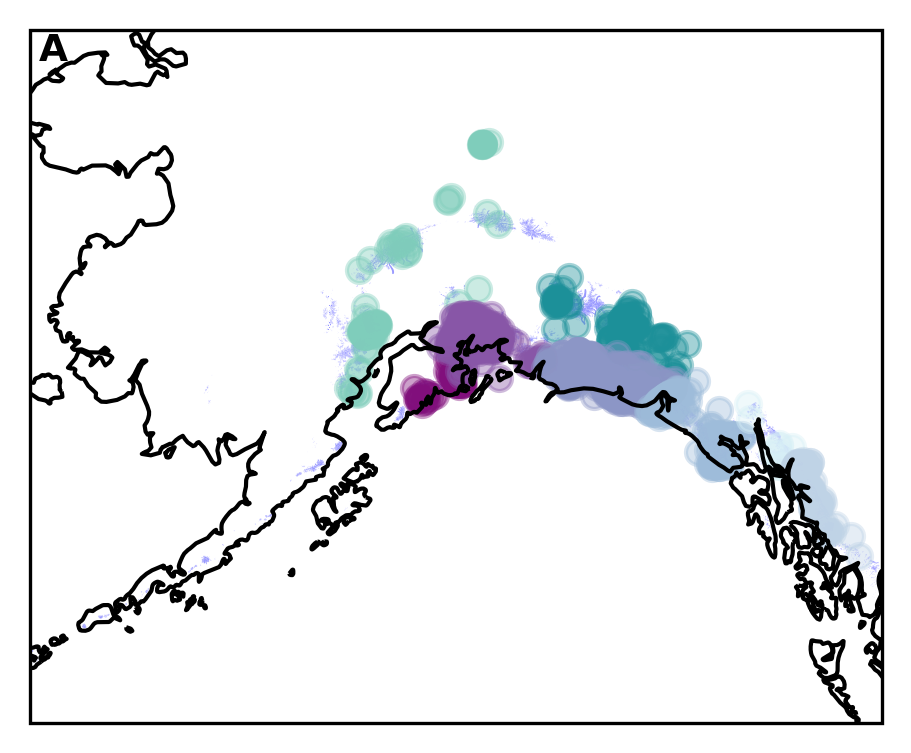

In [34]:
from matplotlib.colors import ListedColormap

gdf_AKBC = gpd.GeoDataFrame(df_AKBC, geometry=gpd.points_from_xy(df_AKBC.longitude, df_AKBC.latitude), crs='epsg:32662')

regions = gdf_AKBC['Region'].unique()
num_regions = len(regions)
#cmap = ListedColormap(plt.cm.get_cmap('Dark2', num_regions).colors)

region_color_map = {
    'Alaska Range': '#7fcdbb',
    'Kenai': '#810f7c',
    'Chugach': '#8856a7',
    'Wrangell': '#1c9099',
    'St. Elias/Disenchantment Bay': '#8c96c6',
    'Glacier Bay/Fairweather': '#9ebcda',
    'Juneau Icefield': '#d8f0f6',
    'Stikine Icefield': '#bfd3e6',
    }

gdf_AKBC['Color'] = gdf_AKBC['Region'].map(region_color_map)

fig = plt.figure(figsize=(4, 3))

axCo = fig.add_subplot(projection=ccrs.Mercator())
axCo.coastlines()

AKs.plot(ax=axCo, transform=ccrs.Mercator(), alpha=1, marker='s', color='#9999FF')

#gdf_AKBC.plot(ax=axCo, transform=ccrs.PlateCarree(), color=gdf_AKBC['Color'].tolist(), alpha=0.4)
for region, color in region_color_map.items():
    subset = gdf_AKBC[gdf_AKBC['Region'] == region]
    subset.plot(ax=axCo, transform=ccrs.PlateCarree(), color=color, alpha=0.4, label=region)


axCo.set_extent([-167, -130, 52, 67], crs=ccrs.PlateCarree())
axCo.text(0.01, 0.995, 'A', weight='bold', horizontalalignment='left', verticalalignment='top', fontsize=9, transform=axCo.transAxes)

os.chdir(Figures_folder)
plt.savefig('AKIcequakeRegions.png', bbox_inches='tight')



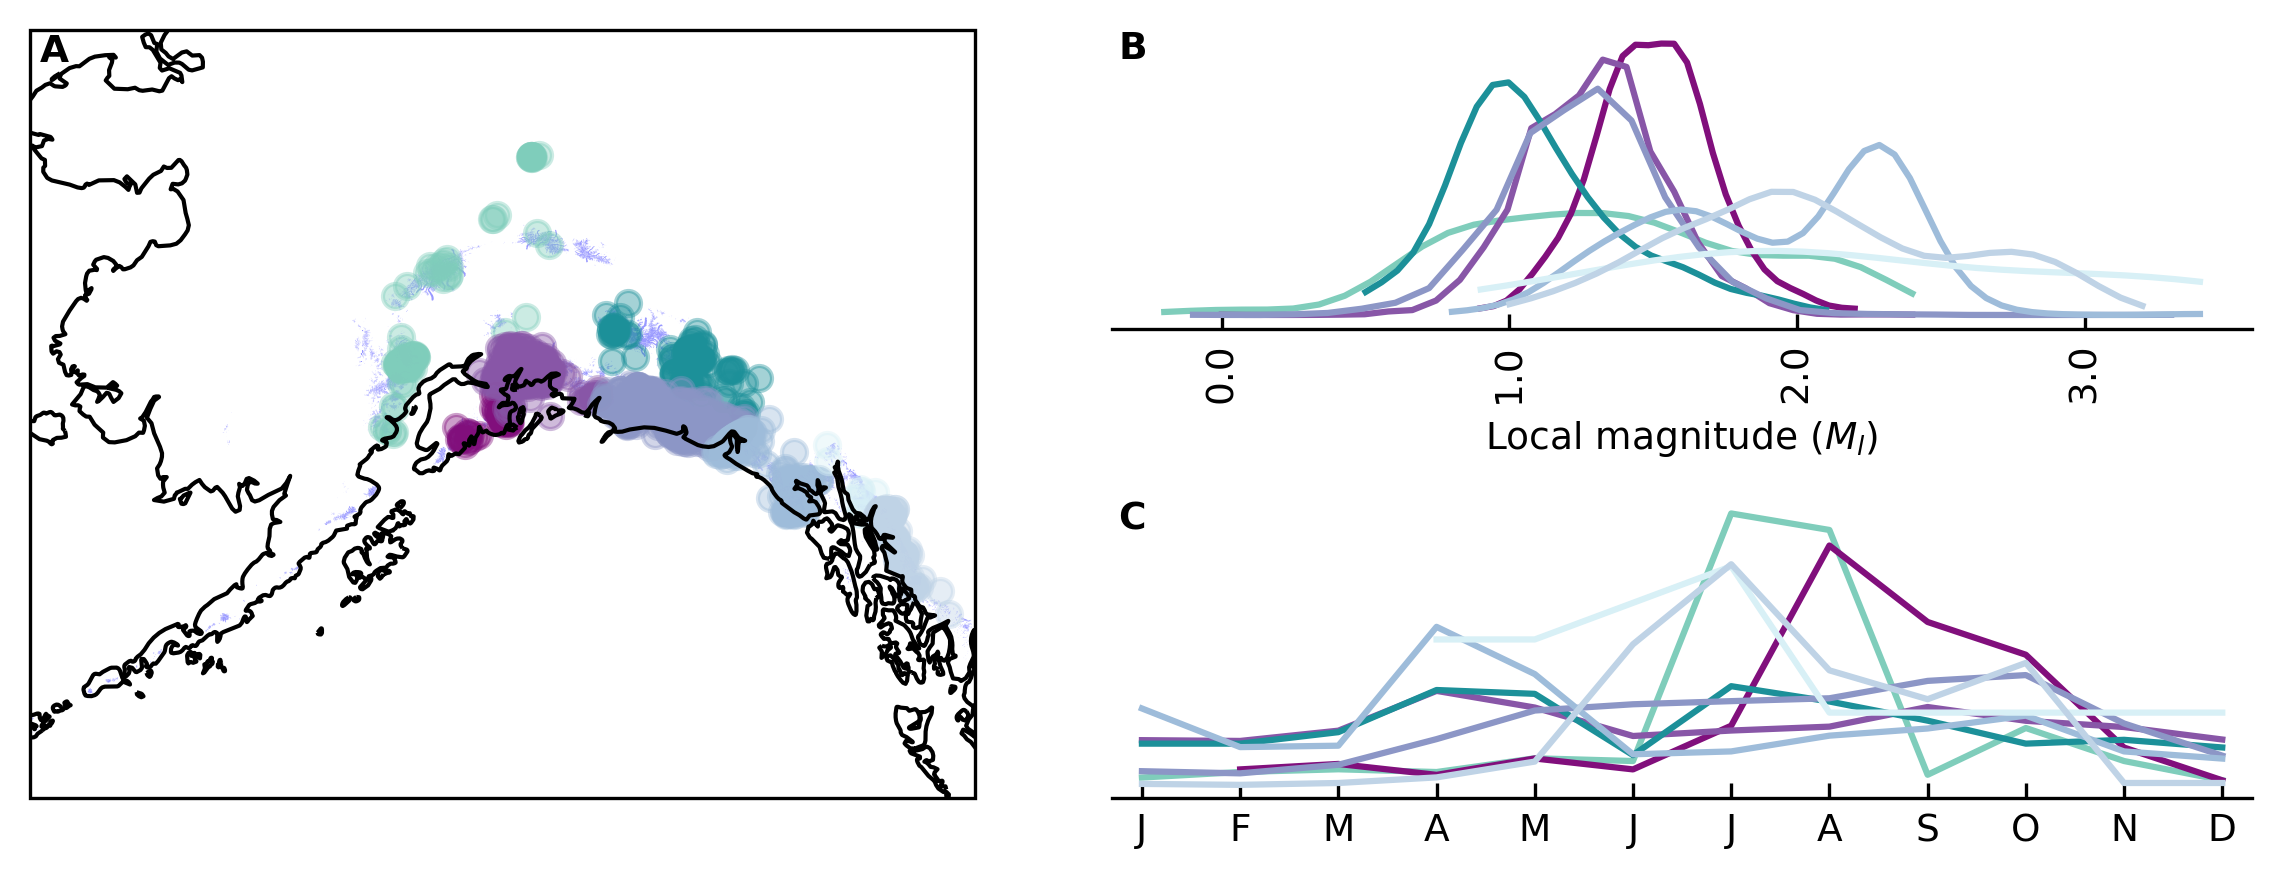

In [35]:
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(8, 3))
gs = GridSpec(2, 2, figure=fig, height_ratios=[1, 1], width_ratios=[1, 1])

axCo = fig.add_subplot(gs[:, 0], projection=ccrs.Mercator())
axCo.coastlines()
AKs.plot(ax=axCo, transform=ccrs.Mercator(), alpha=1, marker='s', color='#9999FF')
#gdf_AKBC.plot(ax=axCo, transform=ccrs.PlateCarree(), color=gdf_AKBC['Color'].tolist(), alpha=0.4)
for region, color in region_color_map.items():
    subset = gdf_AKBC[gdf_AKBC['Region'] == region]
    subset.plot(ax=axCo, transform=ccrs.PlateCarree(), color=color, alpha=0.4, label=region)
axCo.set_extent([-167, -130, 52, 67], crs=ccrs.PlateCarree())
axCo.text(0.01, 0.995, 'A', weight='bold', horizontalalignment='left', verticalalignment='top', fontsize=9, transform=axCo.transAxes)

ax1 = fig.add_subplot(gs[0, 1])
ax1.plot(x_kde_AlRngMw, n_kde_AlRngMw(x_kde_AlRngMw), '-', linewidth=1.5, color='#7fcdbb')
ax1.tick_params('x', direction = 'in')
ax1.tick_params('y', left=False, labelleft=False)
ax1.set_yticklabels([])
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.set_xticks([0.0, 1.0, 2.0, 3.0])
ax1.set_xticklabels([0.0, 1.0, 2.0, 3.0])
ax1.tick_params(axis='x', labelrotation=90, direction='in')
ax1.set_xlabel('Local magnitude $(M_l)$')
ax1.plot(x_kde_KenMw, n_kde_KenMw(x_kde_KenMw), '-', linewidth=1.5, color='#810f7c')
ax1.plot(x_kde_ChugachMw, n_kde_ChugachMw(x_kde_ChugachMw), '-', linewidth=1.5, color='#8856a7')
ax1.plot(x_kde_WranMw, n_kde_WranMw(x_kde_WranMw), '-', linewidth=1.5, color='#1c9099')
ax1.plot(x_kde_StDisMw, n_kde_StDisMw(x_kde_StDisMw), '-', linewidth=1.5, color='#8c96c6')
ax1.plot(x_kde_GlBFairMW, n_kde_GlBFairMw(x_kde_GlBFairMW), '-', linewidth=1.5, color='#9ebcda')
ax1.plot(x_kde_JunIceMw, n_kde_JunIceMw(x_kde_JunIceMw), '-', linewidth=1.5, color='#d8f0f6')
ax1.plot(x_kde_StikMw, n_kde_StikMw(x_kde_StikMw), '-', linewidth=1.5, color='#bfd3e6')
ax1.text(0.005, 0.995, 'B', weight='bold', horizontalalignment='left', verticalalignment='top', fontsize=9, transform=ax1.transAxes)
#ax1.legend(labels=['Alaska Range', 'Kenai', 'Chugach', 'Wrangell', 'St. Elias/Disenchantment Bay', 'Glacier Bay/Fairweather', 'Juneau Icefield', 'Stikine Icefield'], loc='best')

ax2 = fig.add_subplot(gs[1, 1])
ax2.plot((df_AlRng.groupby(df_AlRng.index.month).size()/df_AlRng.groupby(df_AlRng.index.month).size().sum()),color='#7fcdbb')
#ax2.set_ylabel('Icequake count')
ax2.tick_params(axis='x', direction='in')
#ax1.set_ylim(0,2100)
ax2.set_xlim(0.7,12.3)
ax2.set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
ax2.set_xticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])
ax2.set_yticklabels([])
ax2.spines['right'].set_visible(False)
ax2.tick_params('y', left=False, labelleft=False)
ax2.spines['top'].set_visible(False)
ax2.spines['left'].set_visible(False)
#ax1.text(0.97, 0.99, 'Alaskan Icequakes', fontsize='7', horizontalalignment='right', verticalalignment='top', transform=ax1.transAxes)
ax2.text(0.005, 0.995, 'C', weight='bold', horizontalalignment='left', verticalalignment='top', fontsize=9, transform=ax2.transAxes)
ax2.plot(df_Ken.groupby(df_Ken.index.month).size() / df_Ken.groupby(df_Ken.index.month).size().sum(),color='#810f7c')
ax2.plot(df_Chugach.groupby(df_Chugach.index.month).size() / df_Chugach.groupby(df_Chugach.index.month).size().sum(),color='#8856a7')
ax2.plot(df_Wran.groupby(df_Wran.index.month).size() / df_Wran.groupby(df_Wran.index.month).size().sum(),color='#1c9099')
ax2.plot(df_StDis.groupby(df_StDis.index.month).size() / df_StDis.groupby(df_StDis.index.month).size().sum(),color='#8c96c6')
ax2.plot(df_GlBFair.groupby(df_GlBFair.index.month).size() / df_GlBFair.groupby(df_GlBFair.index.month).size().sum(),color='#9ebcda')
ax2.plot(df_JunIce.groupby(df_JunIce.index.month).size() / df_JunIce.groupby(df_JunIce.index.month).size().sum(),color='#d8f0f6')
ax2.plot(df_Stik.groupby(df_Stik.index.month).size() / df_Stik.groupby(df_Stik.index.month).size().sum(),color='#bfd3e6')

plt.tight_layout()

os.chdir(Figures_folder)
plt.savefig('AKIcequakeRegStat.svg', bbox_inches='tight')


In [36]:
WeatherStation_folder = os.path.join(Raw_data_folder,'WeatherStation')
os.chdir(WeatherStation_folder)

df_AKCor1 = pd.read_csv('3939637.csv', na_values=['', 'T'])
df_AKCor2 = pd.read_csv('3939641.csv', na_values=['', 'T'])
df_AKCor3 = pd.read_csv('3939645.csv', na_values=['', 'T'])
df_AKCor4 = pd.read_csv('3939646.csv', na_values=['', 'T'])
df_AKCor5 = pd.read_csv('3939706.csv', na_values=['', 'T'])
df_AKCor6 = pd.read_csv('3939703.csv', na_values=['', 'T'])

def NCEIpr(df):
    df['time'] = pd.to_datetime((df['time']))
    df.set_index('time',inplace=True)
    df.sort_index(inplace=True)
    return df

df_AKCor_list = [df_AKCor1, df_AKCor2, df_AKCor3, df_AKCor4, df_AKCor5, df_AKCor6]
df_AKCor_list = [NCEIpr(df) for df in df_AKCor_list]
df_AKCor = pd.concat(df_AKCor_list)

def NCEIcom(df):
    df['Temp'] = pd.to_numeric(df['Temp'], errors='coerce')
    df['Pr'] = pd.to_numeric(df['Pr'], errors='coerce')
    df['Precip'] = pd.to_numeric(df['Precip'], errors='coerce')
    df['Precip'] = df['Precip']*25.4
    df['WS'] = pd.to_numeric(df['WS'], errors='coerce')
    df['TempC'] = (df['Temp']-32)*(5/9)
    df.sort_index(inplace=True)
    return df


df_AKCor = NCEIcom(df_AKCor)

In [37]:
os.chdir(WeatherStation_folder)

df_AKYak1 = pd.read_csv('3945477.csv', na_values=['', 'T'])
df_AKYak2 = pd.read_csv('3945481.csv', na_values=['', 'T'])
df_AKYak3 = pd.read_csv('3945484.csv', na_values=['', 'T'], low_memory=False)
df_AKYak4 = pd.read_csv('3945487.csv', na_values=['', 'T'])
df_AKYak5 = pd.read_csv('3945488.csv', na_values=['', 'T'])
df_AKYak6 = pd.read_csv('3945492.csv', na_values=['', 'T'])

df_AKYak_list = [df_AKYak1, df_AKYak2, df_AKYak3, df_AKYak4, df_AKYak5, df_AKYak6]
df_AKYak_list = [NCEIpr(df) for df in df_AKYak_list]
df_AKYak = pd.concat(df_AKYak_list)

df_AKYak = NCEIcom(df_AKYak)

In [38]:
os.chdir(WeatherStation_folder)

df_AKJun1 = pd.read_csv('4001410.csv', na_values=['', 'T'])
df_AKJun2 = pd.read_csv('4001411.csv', na_values=['', 'T'])
df_AKJun3 = pd.read_csv('4001412.csv', na_values=['', 'T'])
df_AKJun4 = pd.read_csv('4001413.csv', na_values=['', 'T'])
df_AKJun5 = pd.read_csv('4001415.csv', na_values=['', 'T'])
df_AKJun6 = pd.read_csv('4001416.csv', na_values=['', 'T'])

df_AKJun_list = [df_AKJun1, df_AKJun2, df_AKJun3, df_AKJun4, df_AKJun5, df_AKJun6]
df_AKJun_list = [NCEIpr(df) for df in df_AKJun_list]
df_AKJun = pd.concat(df_AKJun_list)

df_AKJun = NCEIcom(df_AKJun)

C:\Users\alexd\AppData\Local\Temp\ipykernel_45080\3367295525.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_CorGlacdiscompare['cumulative_discharge'] = cumulative_discharge
C:\Users\alexd\AppData\Local\Temp\ipykernel_45080\3367295525.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_CorGlacdiscompare['cumulative_discharge_norm'] = cumulative_discharge_norm
C:\Users\alexd\AppData\Local\Temp\ipykernel_45080\3367295525.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

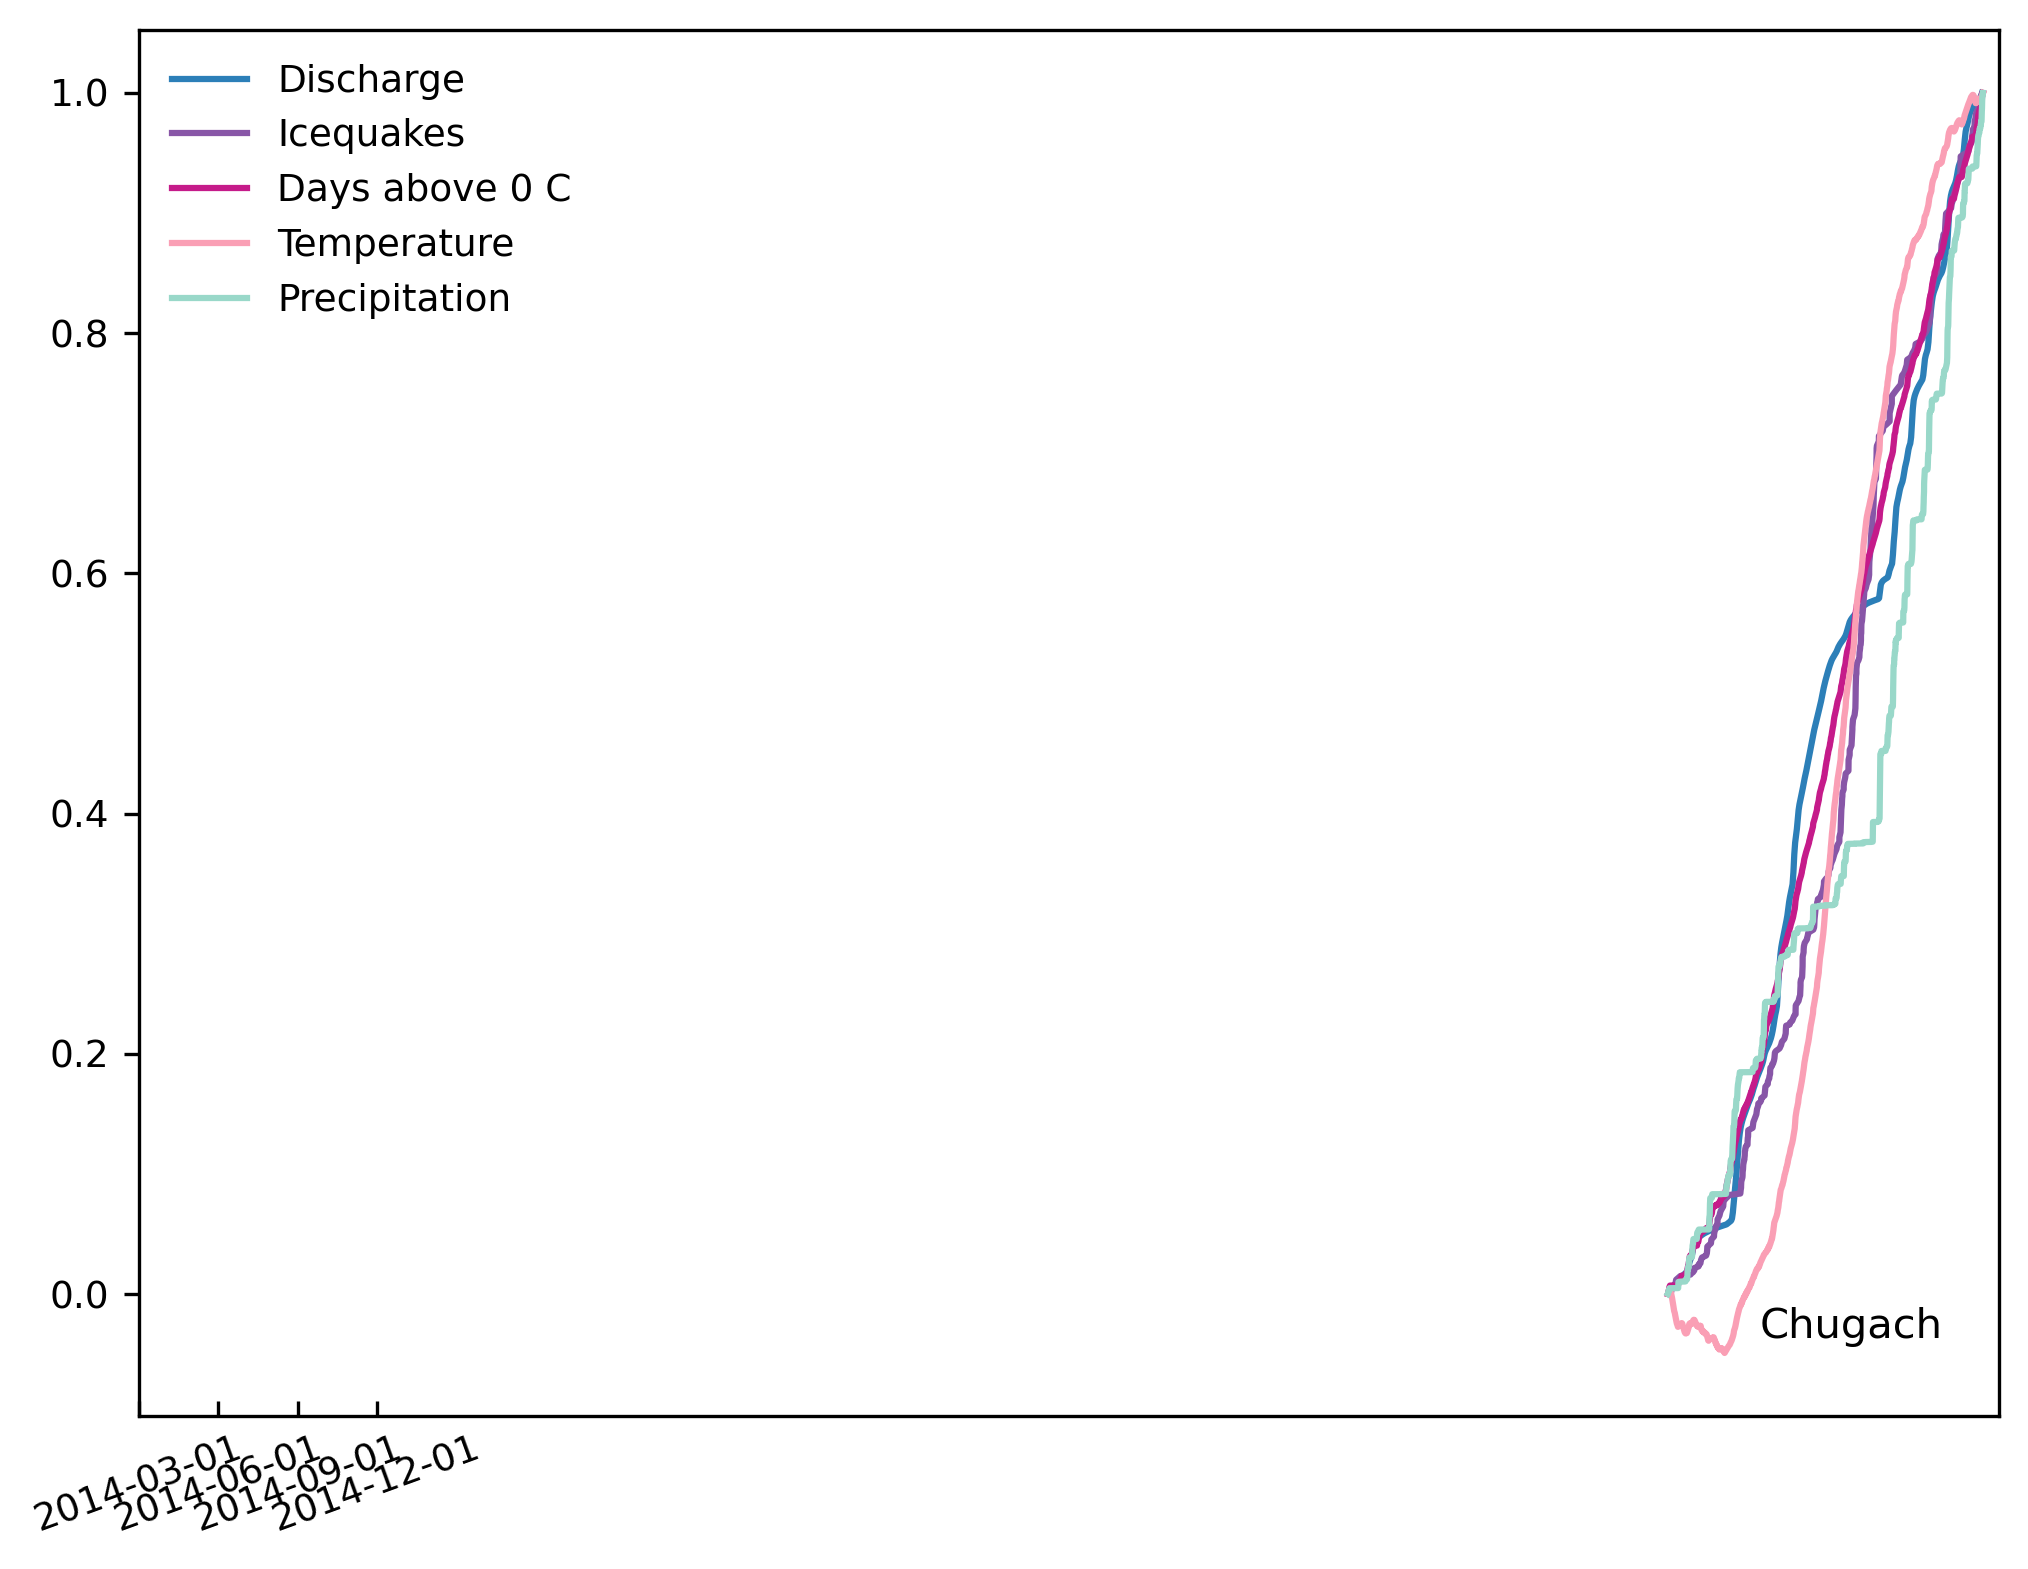

In [82]:
from scipy import integrate

Stream_folder = os.path.join(Raw_data_folder,'StreamGauge')
os.chdir(Stream_folder)

df_CorGlacdis=pd.read_csv('CordGlacDis.csv', na_values=('ice', 'Ice'))
df_CorGlacdis['time'] = pd.to_datetime((df_CorGlacdis['datetime']))
df_CorGlacdis.set_index('time',inplace=True)
df_CorGlacdis.sort_index(inplace=True)
df_CorGlacdis = df_CorGlacdis.drop(columns=['discharge_cd', 'datetime'])
df_CorGlacdis = df_CorGlacdis.dropna()
df_CorGlacdis['discharge'] = pd.to_numeric(df_CorGlacdis['discharge'])

df_CorGlacdiscompare = df_CorGlacdis[(df_CorGlacdis.index >='2019-01-01') & (df_CorGlacdis.index <'2019-12-31')]
cumulative_discharge = integrate.cumulative_trapezoid(df_CorGlacdiscompare['discharge'], dx=1, initial=0)
df_CorGlacdiscompare['cumulative_discharge'] = cumulative_discharge
cumulative_discharge_norm = cumulative_discharge/np.max(cumulative_discharge)
df_CorGlacdiscompare['cumulative_discharge_norm'] = cumulative_discharge_norm

df_Chugachcompare = df_Chugach[(df_Chugach.index >='2019-01-01') & (df_Chugach.index <'2019-12-31')]
Chugicequakes = integrate.cumulative_trapezoid(df_Chugachcompare['M0'], dx=1, initial=0)
Chugicequakesnorm = Chugicequakes/np.max(Chugicequakes)
df_Chugachcompare['cumulativeicequakesnorm'] = Chugicequakesnorm

df_AKCorcompare = df_AKCor[(df_AKCor.index >='2019-01-01') & (df_AKCor.index <'2019-12-31')]
df_AKCorcompare['Precip'] = df_AKCorcompare['Precip'].fillna(0)
cumulative_precip = integrate.cumulative_trapezoid(df_AKCorcompare['Precip'], dx=1, initial=0)
df_AKCorcompare['cumulative_precip'] = cumulative_precip
cumulative_precip_norm = cumulative_precip/np.max(cumulative_precip)
df_AKCorcompare['cumulative_precip_norm'] = cumulative_precip_norm

df_AKCorcompare['TempAboveZero'] = (df_AKCorcompare['TempC'] > 0).astype(int)
cumulative_temp_days = integrate.cumulative_trapezoid(df_AKCorcompare['TempAboveZero'], dx=1, initial=0)
df_AKCorcompare['cumulative_temp_days'] = cumulative_temp_days
df_AKCorcompare['cumulative_temp_days_norm'] = cumulative_temp_days / np.max(cumulative_temp_days)

df_AKCorcompare['TempC'] = df_AKCorcompare['TempC'].fillna(0)

#Cortempd = df_AKCorcompare['TempC'].resample('w').mean(numeric_only=True)
#Cortempd = Cortempd.dropna()
#CorTempdeld = np.gradient(Cortempd, 1)

cumulative_temp = integrate.cumulative_trapezoid(df_AKCorcompare['TempC'], dx=1, initial=0)
#cumulative_temp = integrate.cumulative_trapezoid(CorTempdeld, dx=1, initial=0)
df_AKCorcompare['cumulative_temp'] = cumulative_temp
cumulative_temp_norm = cumulative_temp/np.max(cumulative_temp)
df_AKCorcompare['cumulative_temp_norm'] = cumulative_temp_norm

fig, ((ax1)) = plt.subplots(1, 1, figsize=(8, 6))

ax1.plot(df_CorGlacdiscompare.cumulative_discharge_norm, color = '#2c7fb8')
ax1.plot(df_Chugachcompare.cumulativeicequakesnorm, color = '#8856a7')
ax1.plot(df_AKCorcompare.cumulative_temp_days_norm, color = '#c51b8a')
ax1.plot(df_AKCorcompare.cumulative_temp_norm, color = '#fa9fb5')
#plt.plot(cumulative_temp_norm, color = 'pink')
ax1.plot(df_AKCorcompare.cumulative_precip_norm, color = '#99d8c9')

ax1.legend(labels=['Discharge', 'Icequakes', 'Days above 0 C', 'Temperature', 'Precipitation'], loc='upper left', frameon=False)
ax1.set_xticks(['2014-03-01', '2014-06-01', '2014-09-01', '2014-12-01'])
ax1.tick_params(axis='x', labelrotation=20, direction='in')
ax1.text(0.97, 0.05, 'Chugach', fontsize='10', horizontalalignment='right', verticalalignment='bottom', transform=ax1.transAxes)
#print(df_AKCorcompare.TempC)

os.chdir(Figures_folder)
plt.savefig('CordGlacIcequakeAtmos.png', bbox_inches='tight')

C:\Users\alexd\AppData\Local\Temp\ipykernel_45080\1541701965.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Chugachcompare['Mwh'] = np.log10(df_Chugachcompare['M0'].replace(-np.inf, 0))
C:\Users\alexd\AppData\Local\Temp\ipykernel_45080\1541701965.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Chugachcompare['Mwh'] = df_Chugachcompare['Mwh'].replace(-np.inf, 0)
C:\Users\alexd\AppData\Local\Temp\ipykernel_45080\1541701965.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

time
2019-01-03 23:59:11.092000+00:00     4
2019-01-04 22:08:54.079000+00:00     4
2019-01-05 17:31:34.357000+00:00     4
2019-01-09 16:31:03.391000+00:00     2
2019-01-10 12:15:38.379000+00:00     2
2019-01-15 09:09:53.887000+00:00     1
2019-01-27 01:18:18.857000+00:00     2
2019-01-27 21:47:22.374000+00:00     2
2019-01-30 01:00:12.328000+00:00     4
2019-01-31 09:12:13.126000+00:00     4
2019-01-31 09:15:40.369000+00:00     4
2019-01-31 09:36:01.806000+00:00     4
2019-02-05 08:59:14.469000+00:00     6
2019-02-05 11:41:24.217000+00:00     6
2019-02-07 12:18:45.551000+00:00     6
2019-02-07 17:12:22.889000+00:00     6
2019-02-08 07:18:07.951000+00:00     6
2019-02-09 10:08:15.484000+00:00     6
2019-02-14 02:22:29.070000+00:00     4
2019-02-14 23:10:05.361000+00:00     4
2019-02-15 08:27:10.441000+00:00     4
2019-02-15 12:21:24.418000+00:00     4
2019-02-19 16:34:30.089000+00:00     6
2019-02-20 04:57:29.255000+00:00     6
2019-02-23 05:21:53.739000+00:00     6
2019-02-23 07:55:10.

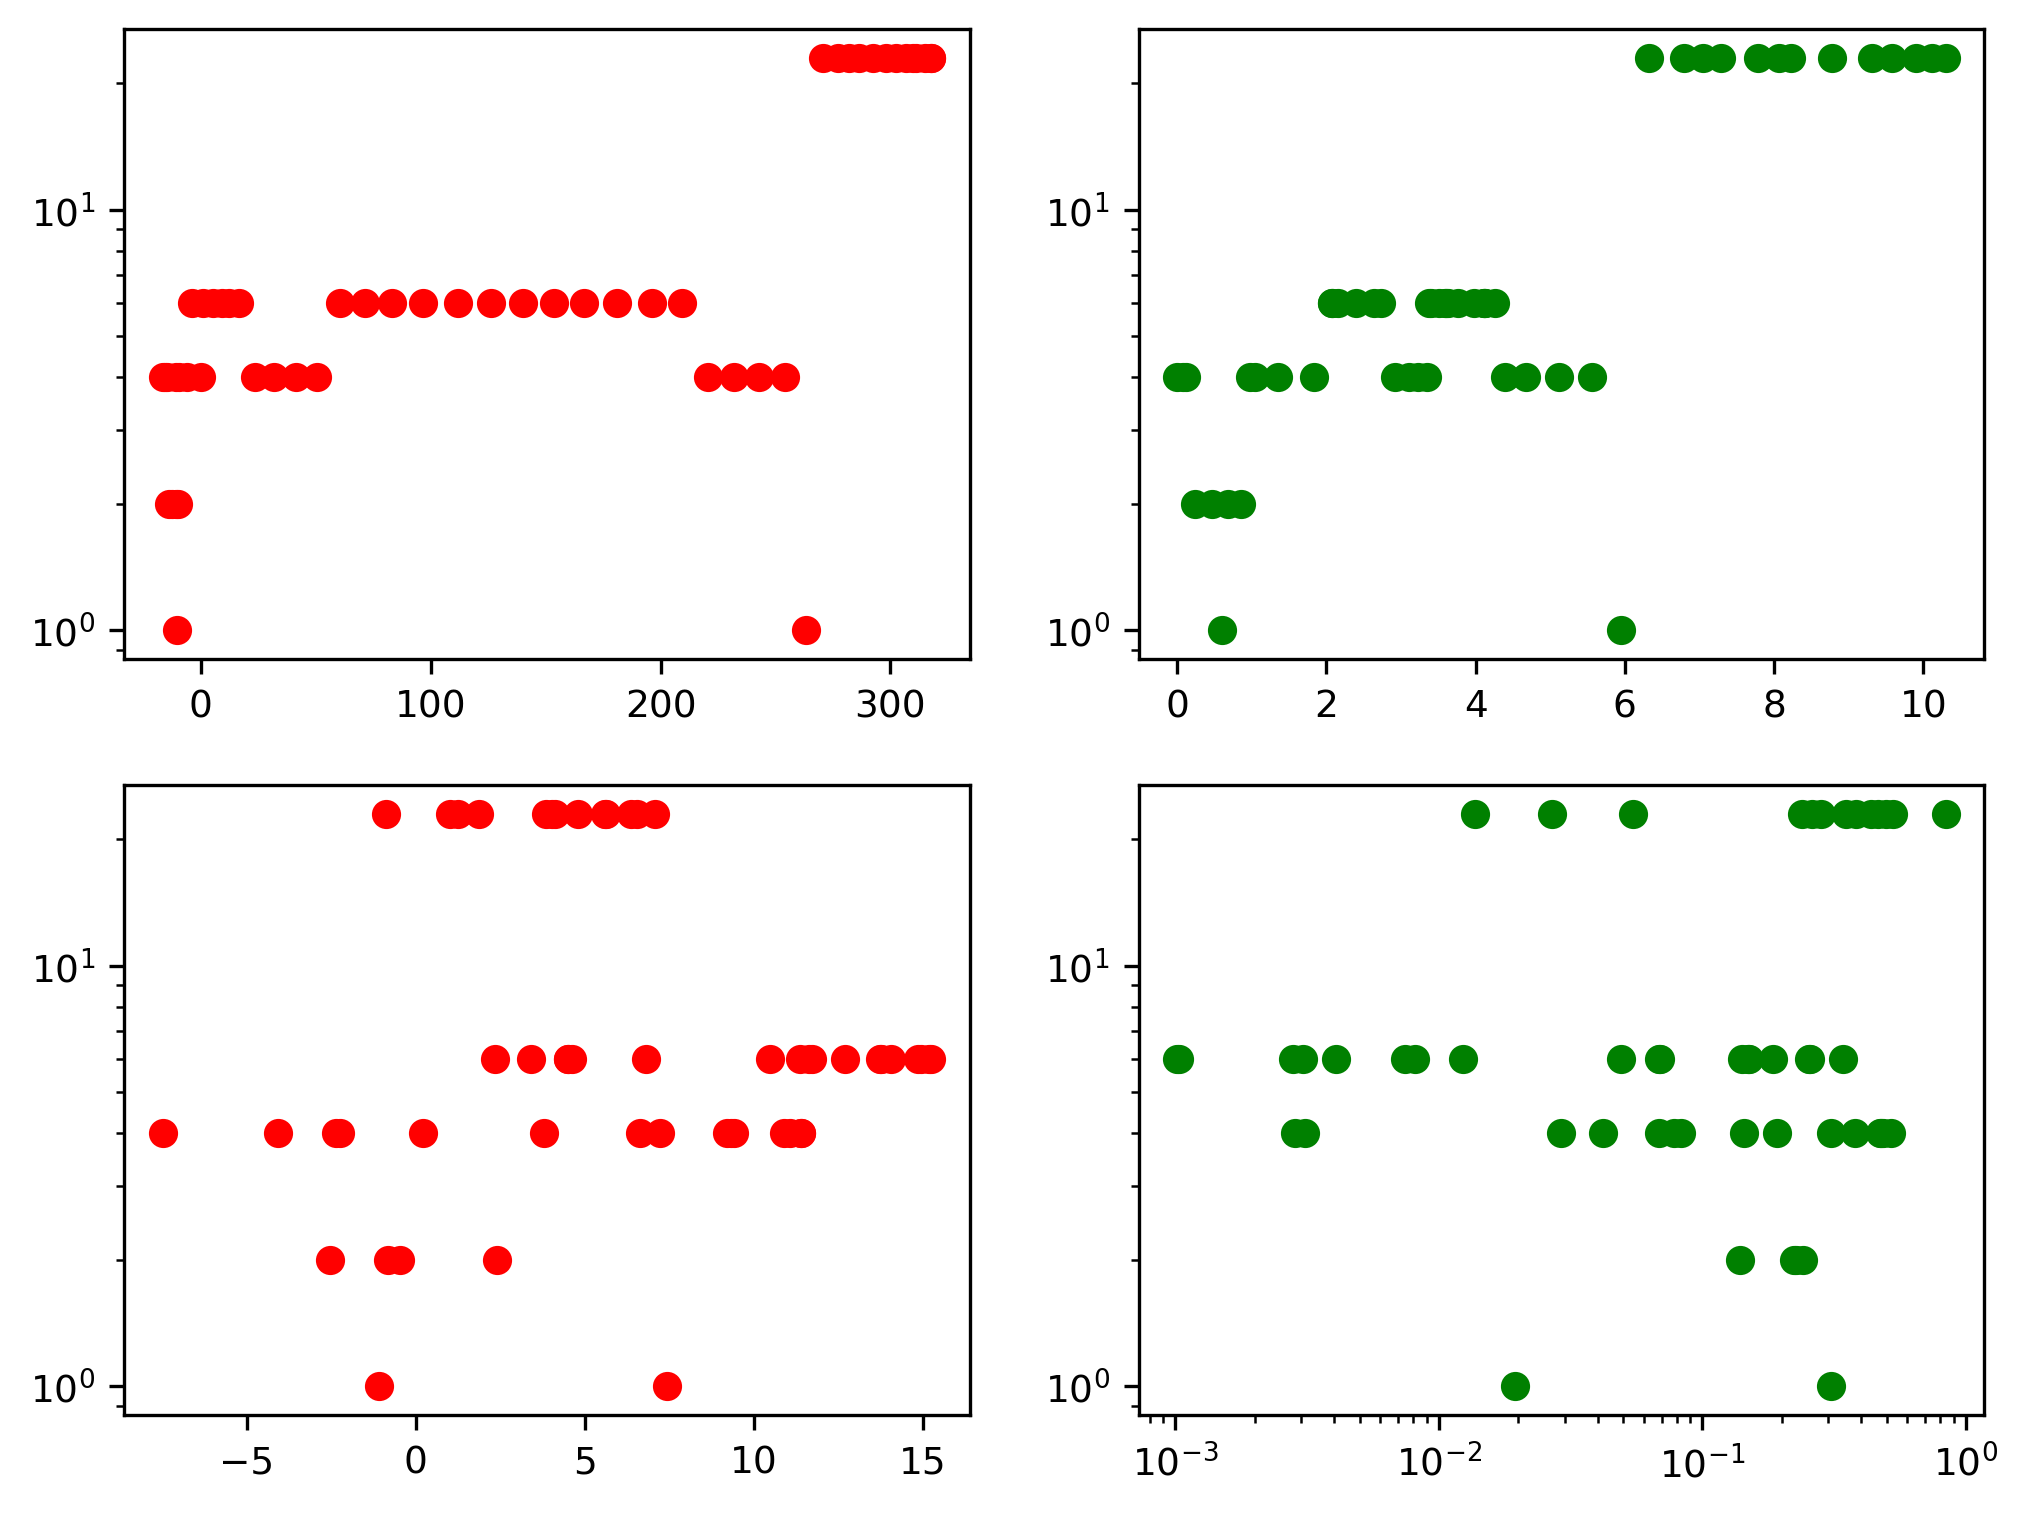

In [93]:
df_Chugachcompare = df_Chugach[(df_Chugach.index >='2019-01-01') & (df_Chugach.index <'2019-12-31')]
df_Chugachcompare['Mwh'] = np.log10(df_Chugachcompare['M0'].replace(-np.inf, 0))
#df_Chugachcompare = df_Chugachcompare.resample('w').sum()
df_Chugachcompare['Mwh'] = df_Chugachcompare['Mwh'].replace(-np.inf, 0)
df_Chugachcompare['Mwh'] = df_Chugachcompare['Mwh'].fillna(0)
df_Chugachcompare['weeklycount'] = df_Chugachcompare.groupby(df_Chugachcompare.index.isocalendar().week)['Mwh'].transform('size')
df_Chugachcompare = df_Chugachcompare.iloc[:52]
print(df_Chugachcompare['weeklycount'])

###note this does not work right now. wouldh ave to go back to weekly sum resample and then use mwh as the y-axis for all the plots or try to get thi
##count thing to work by summing the weekly count - note that there are 56 weeks, but 52 iloc

df_AKCorcompare = df_AKCorcompare[(df_AKCorcompare.index >='2019-01-01') & (df_AKCorcompare.index <'2019-12-31')]
df_AKCorcompare = df_AKCorcompare.resample('w').mean()
df_AKCorcompare['TempC'] = df_AKCorcompare['TempC'].fillna(0)
df_AKCorcompare = df_AKCorcompare.iloc[:52]

df_AKCorprecip = df_AKCorcompare.resample('w').sum()
df_AKCorprecip['Precip'] = df_AKCorprecip['Precip'].fillna(0)
df_AKCorprecip = df_AKCorprecip.iloc[:52]

df_CorGlacdiscompare = df_CorGlacdis[(df_CorGlacdis.index >='2019-01-01') & (df_CorGlacdis.index <'2019-12-31')]
df_CorGlacdiscompare = df_CorGlacdiscompare.resample('w').mean()
df_CorGlacdiscompare['discharge'] = df_CorGlacdiscompare['discharge'].fillna(0)
df_CorGlacdiscompare = df_CorGlacdiscompare.iloc[:52]

print(len(df_CorGlacdiscompare))
print(len(df_Chugachcompare))
print(len(df_AKCorcompare))
print(len(df_AKCorprecip))
#fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(12, 6))
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(8, 6))


ax1.scatter(integrate.cumulative_trapezoid(df_AKCorcompare['TempC'], initial = 0), df_Chugachcompare.weeklycount, color='red')
ax1.set_yscale('log')
ax2.scatter(integrate.cumulative_trapezoid(df_AKCorprecip['Precip'], initial = 0), df_Chugachcompare.weeklycount, color = 'green')
ax2.set_yscale('log')
#ax2.set_xscale('log')
#ax3.scatter(integrate.cumulative_trapezoid(df_CorGlacdiscompare['discharge'], initial = 0), df_Chugachcompare.Mwh, color = 'blue')
ax3.scatter(df_AKCorcompare.TempC, df_Chugachcompare.weeklycount, color='red')
ax3.set_yscale('log')
ax4.scatter(df_AKCorprecip.Precip, df_Chugachcompare.weeklycount, color = 'green')
ax4.set_xscale('log')
ax4.set_yscale('log')
#ax4.set_xscale('log')
#ax6.scatter(df_CorGlacdiscompare.discharge, df_Chugachcompare.Mwh, color = 'blue')


C:\Users\alexd\AppData\Local\Temp\ipykernel_45080\2209606184.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Yakcompare['cumulativeicequakesnorm'] = Yakicequakesnorm
C:\Users\alexd\AppData\Local\Temp\ipykernel_45080\2209606184.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_AKYakcompare['Precip'] = df_AKYakcompare['Precip'].fillna(0)
C:\Users\alexd\AppData\Local\Temp\ipykernel_45080\2209606184.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Tr

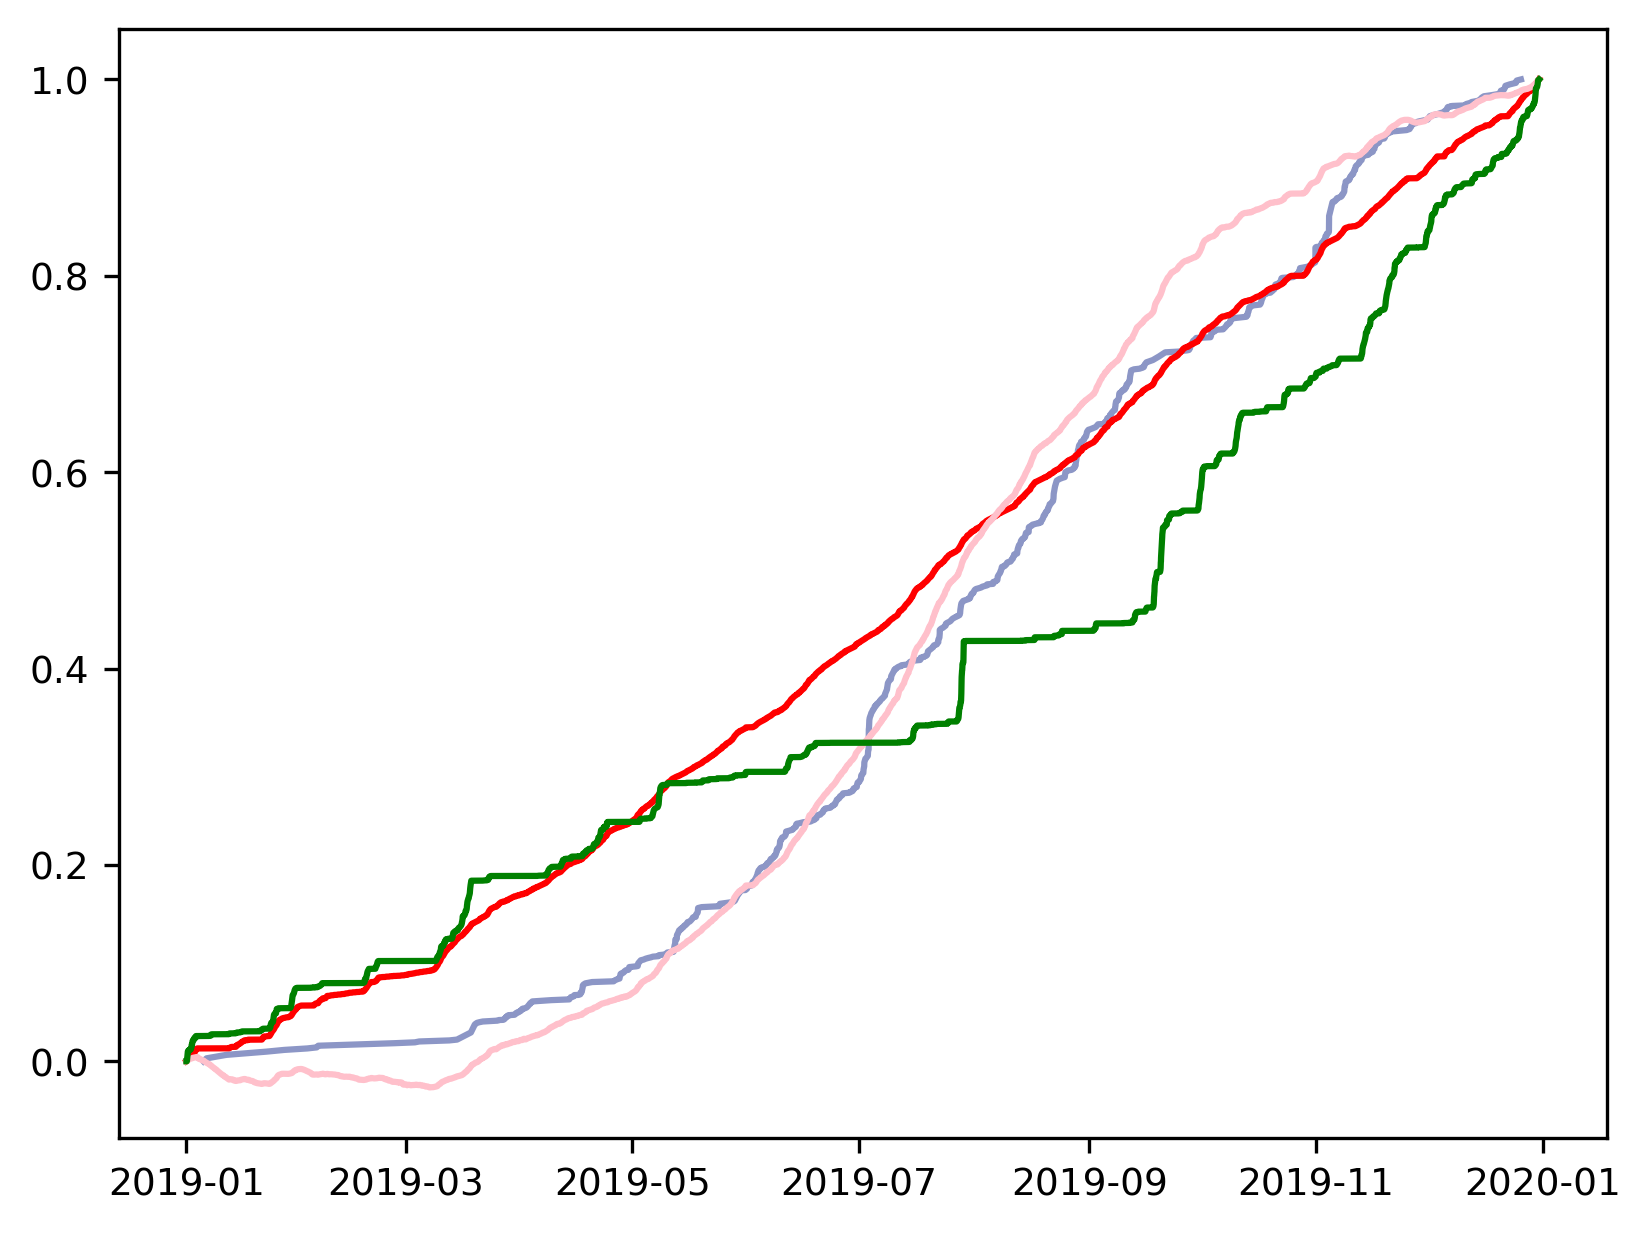

In [41]:
from scipy import integrate

df_Yakcompare = df_StDis[(df_StDis.index >='2019-01-01') & (df_StDis.index <'2019-12-31')]
Yakicequakes = integrate.cumulative_trapezoid(df_Yakcompare['M0'], dx=1, initial=0)
Yakicequakesnorm = Yakicequakes/np.max(Yakicequakes)
df_Yakcompare['cumulativeicequakesnorm'] = Yakicequakesnorm

df_AKYakcompare = df_AKYak[(df_AKYak.index >='2019-01-01') & (df_AKYak.index <'2019-12-31')]
df_AKYakcompare['Precip'] = df_AKYakcompare['Precip'].fillna(0)
cumulative_precip = integrate.cumulative_trapezoid(df_AKYakcompare['Precip'], dx=1, initial=0)
df_AKYakcompare['cumulative_precip'] = cumulative_precip
cumulative_precip_norm = cumulative_precip/np.max(cumulative_precip)
df_AKYakcompare['cumulative_precip_norm'] = cumulative_precip_norm

df_AKYakcompare['TempAboveZero'] = (df_AKYakcompare['TempC'] > 0).astype(int)
cumulative_temp_days = integrate.cumulative_trapezoid(df_AKYakcompare['TempAboveZero'], dx=1, initial=0)
df_AKYakcompare['cumulative_temp_days'] = cumulative_temp_days
df_AKYakcompare['cumulative_temp_days_norm'] = cumulative_temp_days / np.max(cumulative_temp_days)

df_AKYakcompare['TempC'] = df_AKYakcompare['TempC'].fillna(0)

#Cortempd = df_AKCorcompare['TempC'].resample('w').mean(numeric_only=True)
#Cortempd = Cortempd.dropna()
#CorTempdeld = np.gradient(Cortempd, 1)

cumulative_temp = integrate.cumulative_trapezoid(df_AKYakcompare['TempC'], dx=1, initial=0)
#cumulative_temp = integrate.cumulative_trapezoid(CorTempdeld, dx=1, initial=0)
df_AKYakcompare['cumulative_temp'] = cumulative_temp
cumulative_temp_norm = cumulative_temp/np.max(cumulative_temp)
df_AKYakcompare['cumulative_temp_norm'] = cumulative_temp_norm

plt.plot(df_Yakcompare.cumulativeicequakesnorm, color = '#8c96c6')
plt.plot(df_AKYakcompare.cumulative_temp_days_norm, color = 'red')
plt.plot(df_AKYakcompare.cumulative_temp_norm, color = 'pink')
#plt.plot(cumulative_temp_norm, color = 'pink')
plt.plot(df_AKYakcompare.cumulative_precip_norm, color = 'green')

#print(df_AKYakcompare)


C:\Users\alexd\AppData\Local\Temp\ipykernel_45080\4171787103.py:1: FutureWarning: 'w' is deprecated and will be removed in a future version, please use 'W' instead.
  df_Yakcompare2 = df_Yakcompare.resample('w').sum()
c:\Users\alexd\anaconda3\envs\Icequake\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\alexd\AppData\Local\Temp\ipykernel_45080\4171787103.py:7: FutureWarning: 'w' is deprecated and will be removed in a future version, please use 'W' instead.
  df_AKYakcompare2 = df_AKYakcompare.resample('w').mean()
C:\Users\alexd\AppData\Local\Temp\ipykernel_45080\4171787103.py:11: FutureWarning: 'w' is deprecated and will be removed in a future version, please use 'W' instead.
  df_AKYakprecip2 = df_AKYakcompare.resample('w').sum()


48
48
48


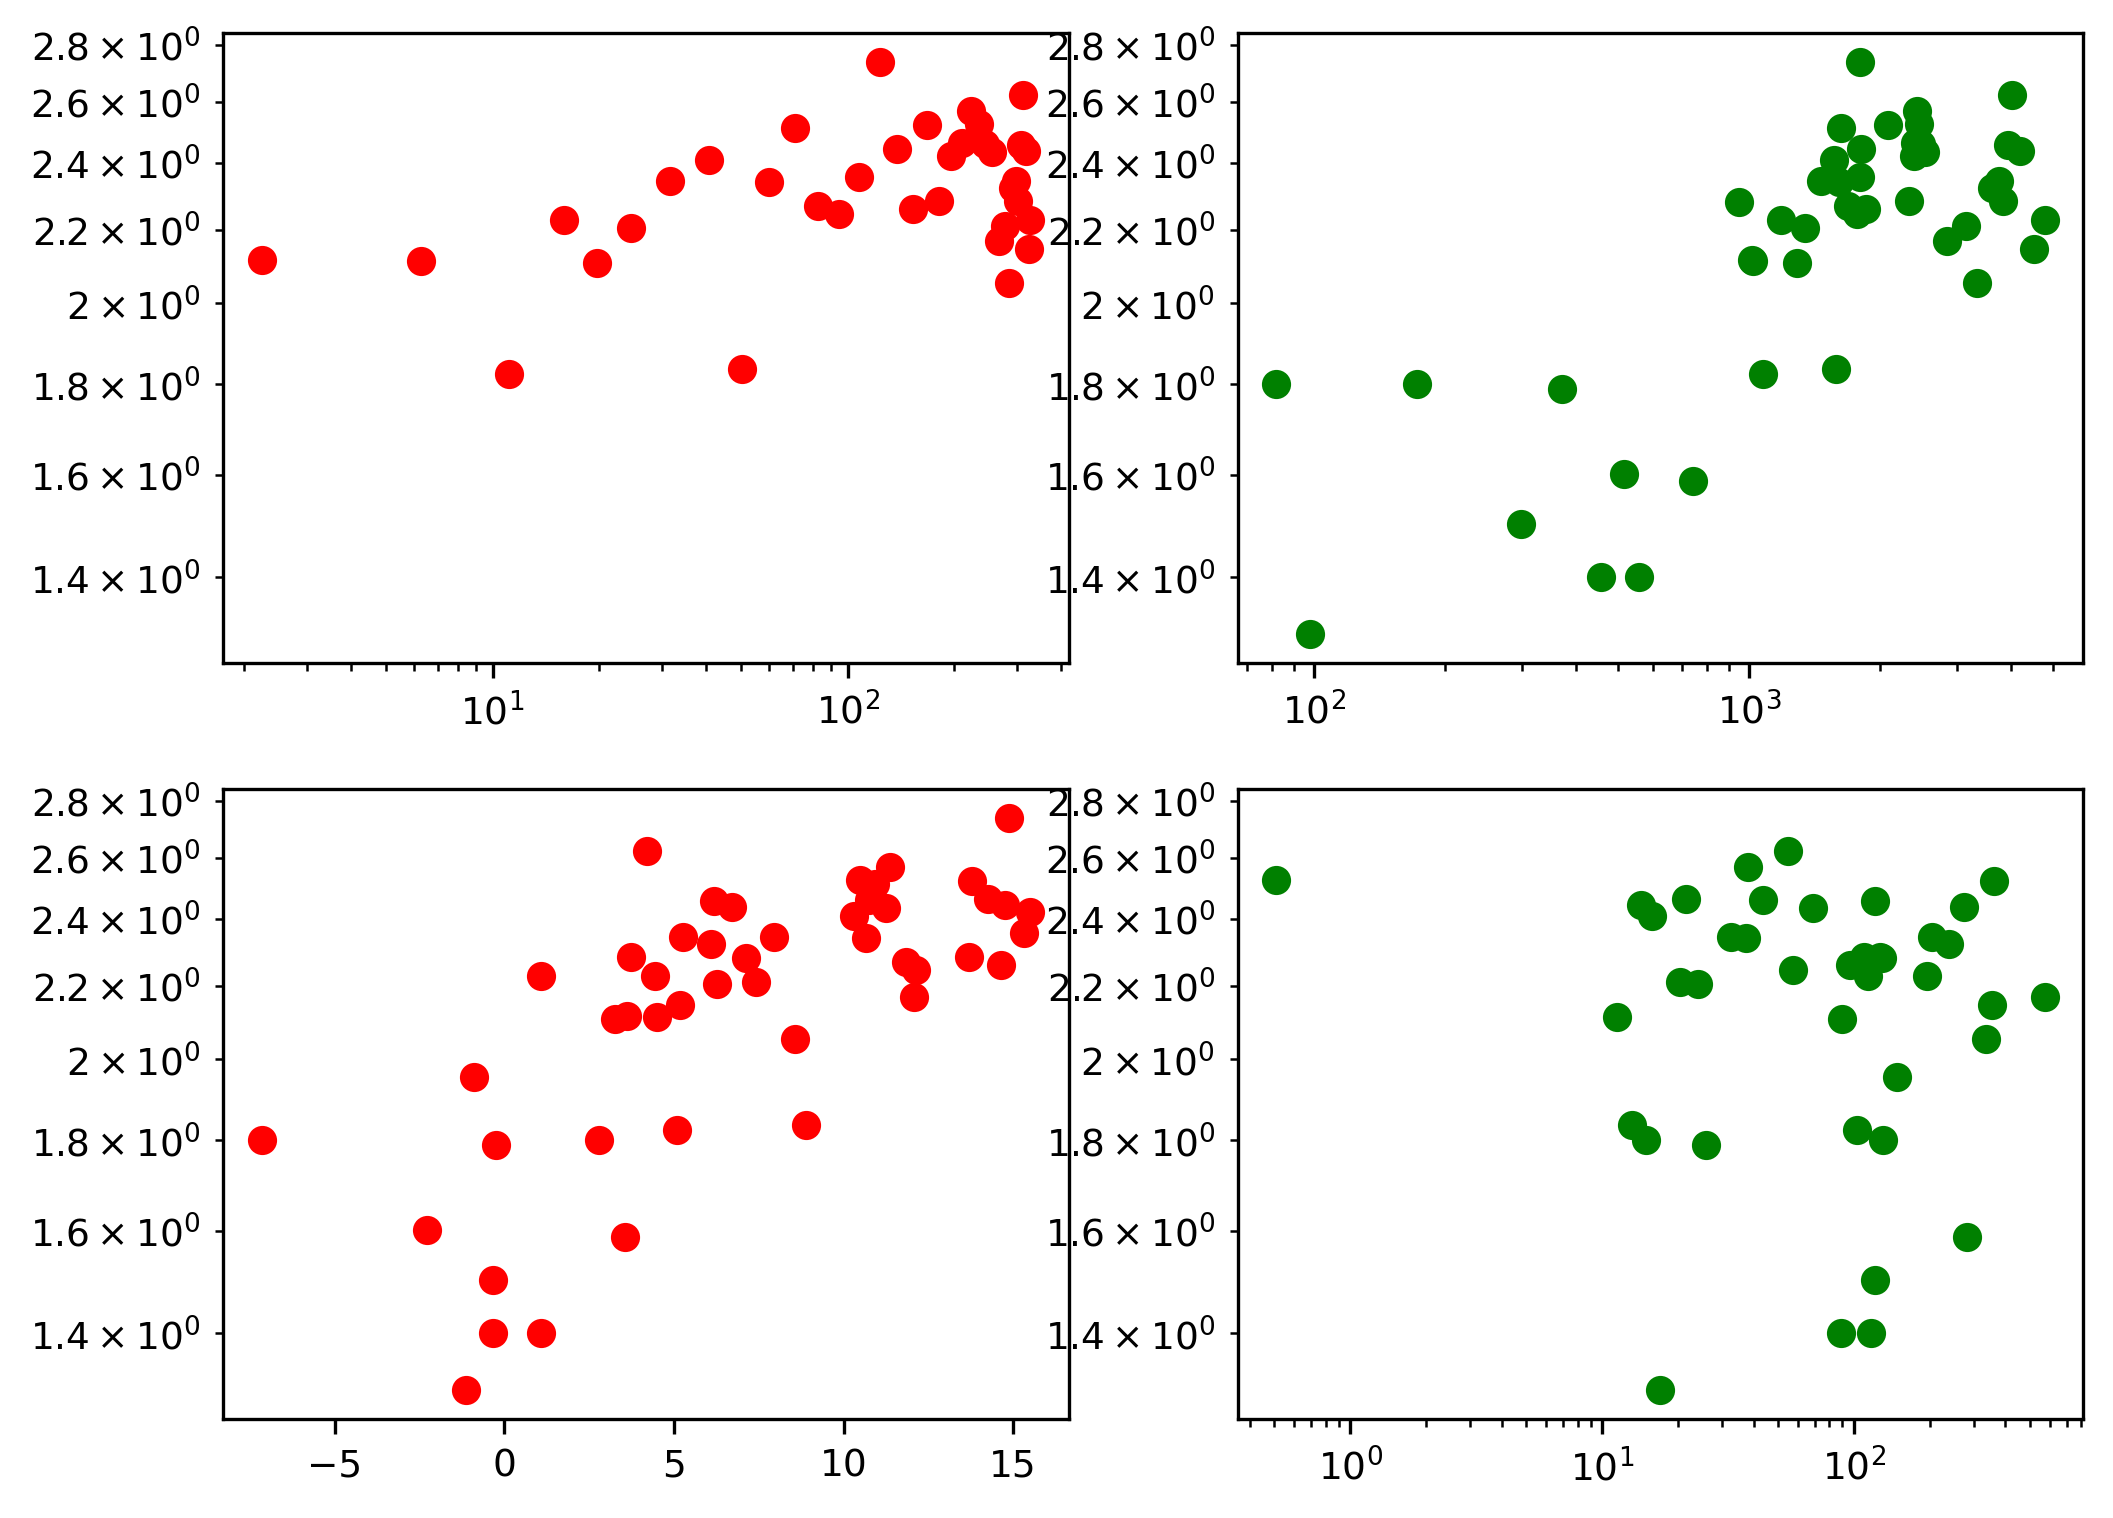

In [70]:
df_Yakcompare2 = df_Yakcompare.resample('w').sum()
df_Yakcompare2['Mwh'] = (np.log10(df_Yakcompare2['M0'])-9.105)/1.5
df_Yakcompare2['Mwh'] = df_Yakcompare2['Mwh'].replace(-np.inf, 0)
df_Yakcompare2['Mwh'] = df_Yakcompare2['Mwh'].fillna(0)
df_Yakcompare2 = df_Yakcompare2.iloc[:48]

df_AKYakcompare2 = df_AKYakcompare.resample('w').mean()
df_AKYakcompare2['TempC'] = df_AKYakcompare2['TempC'].dropna()
df_AKYakcompare2 = df_AKYakcompare2.iloc[:48]

df_AKYakprecip2 = df_AKYakcompare.resample('w').sum()
df_AKYakprecip2['Precip'] = df_AKYakprecip2['Precip'].dropna()
df_AKYakprecip2 = df_AKYakprecip2.iloc[:48]

print(len(df_AKYakcompare2))
print(len(df_Yakcompare2))
print(len(df_AKYakprecip2))

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(8, 6))

ax1.scatter(integrate.cumulative_trapezoid(df_AKYakcompare2['TempC'], initial = 0), df_Yakcompare2.Mwh, color='red')
ax1.set_yscale('log')
ax1.set_xscale('log')
ax2.scatter(integrate.cumulative_trapezoid(df_AKYakprecip2['Precip'], initial = 0), df_Yakcompare2.Mwh, color = 'green')
ax2.set_yscale('log')
ax2.set_xscale('log')

ax3.scatter(df_AKYakcompare2.TempC, df_Yakcompare2.Mwh, color='red')
ax3.set_yscale('log')
ax4.scatter(df_AKYakprecip2.Precip, df_Yakcompare2.Mwh, color = 'green')
ax4.set_yscale('log')
ax4.set_xscale('log')

#print(df_AKYakcompare.TempC)

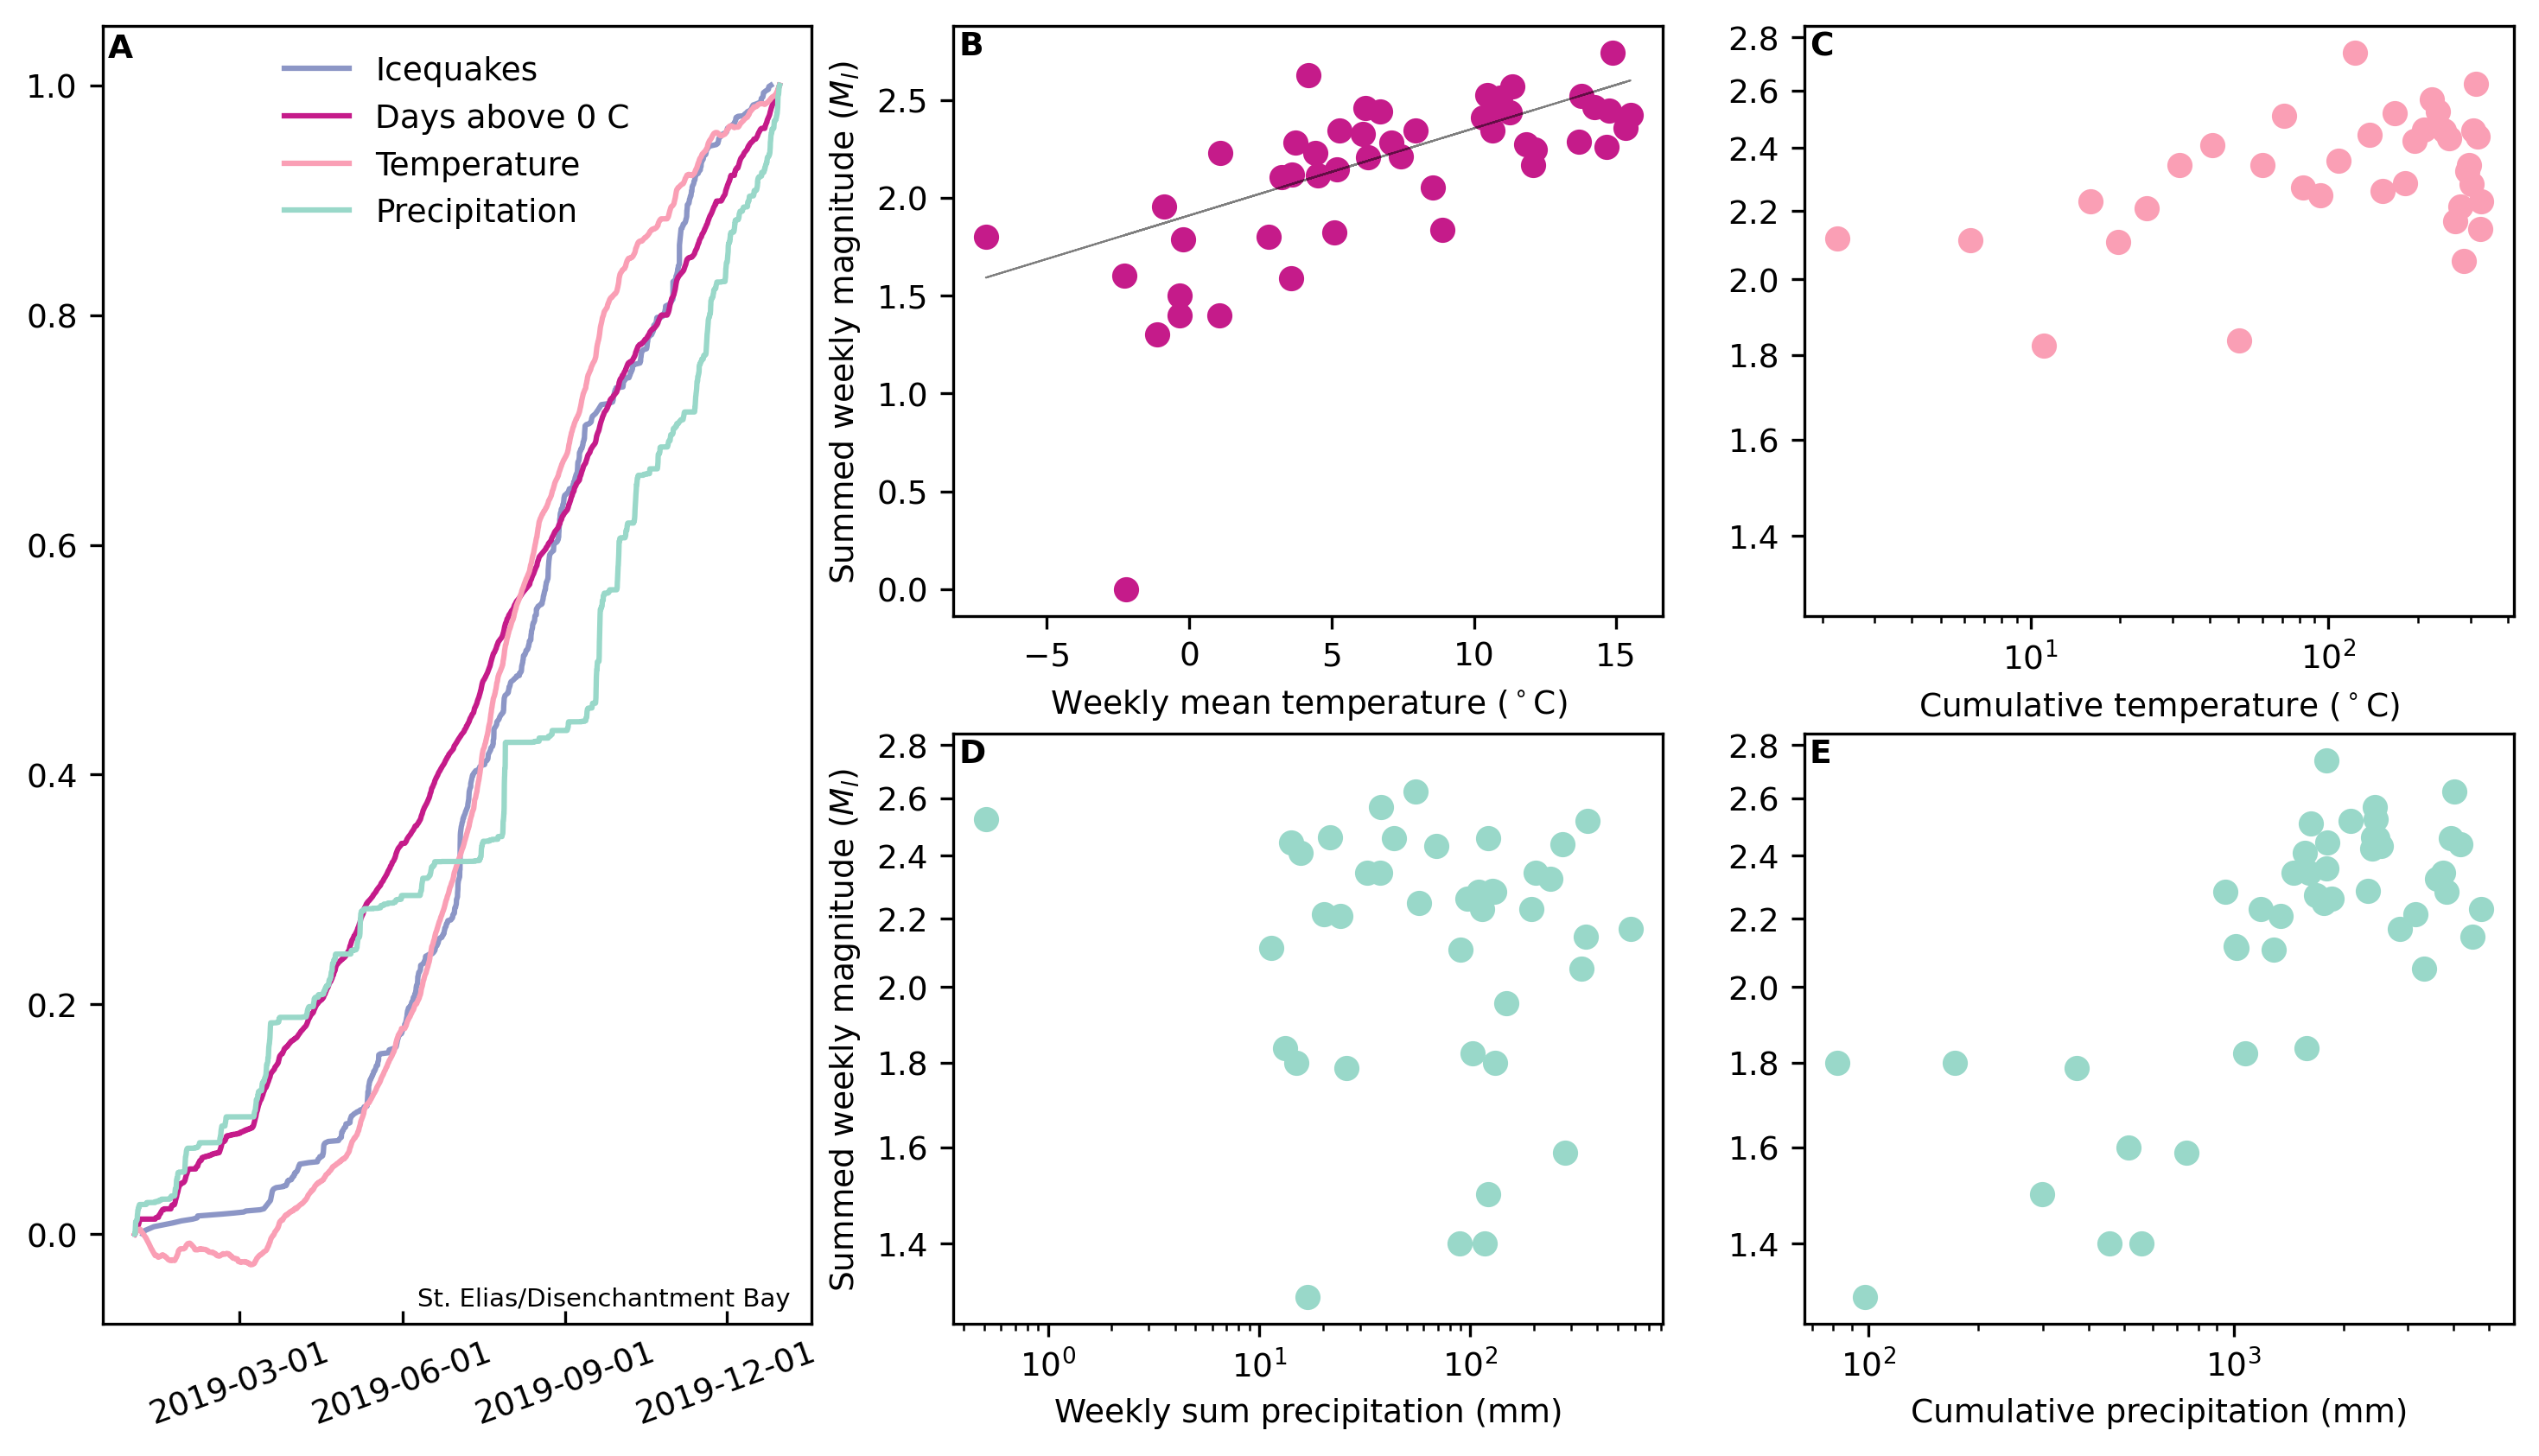

In [43]:
from matplotlib.gridspec import GridSpec

TempMagnYak = stats.theilslopes(df_Yakcompare2.Mwh, df_AKYakcompare2.TempC, 0.95, method='joint')

fig = plt.figure(figsize=(12, 6.5))
gs = GridSpec(2, 3, figure=fig, height_ratios=[1, 1], width_ratios=[1, 1, 1])

ax1 = fig.add_subplot(gs[:, 0])
ax1.plot(df_Yakcompare.cumulativeicequakesnorm, color = '#8c96c6')
ax1.plot(df_AKYakcompare.cumulative_temp_days_norm, color = '#c51b8a')
ax1.plot(df_AKYakcompare.cumulative_temp_norm, color = '#fa9fb5')
ax1.plot(df_AKYakcompare.cumulative_precip_norm, color = '#99d8c9')
ax1.legend(labels=['Icequakes', 'Days above 0 C', 'Temperature', 'Precipitation'], loc='upper center', frameon=False)
ax1.set_xticks(['2019-03-01', '2019-06-01', '2019-09-01', '2019-12-01'])
ax1.tick_params(axis='x', labelrotation=20, direction='in')
ax1.text(0.007, 0.995, 'A', weight='bold', horizontalalignment='left', verticalalignment='top', fontsize=9, transform=ax1.transAxes)
ax1.text(0.97, 0.01, 'St. Elias/Disenchantment Bay', fontsize='7', horizontalalignment='right', verticalalignment='bottom', transform=ax1.transAxes)

ax2 = fig.add_subplot(gs[0,2])
ax2.scatter(integrate.cumulative_trapezoid(df_AKYakcompare2['TempC'], initial = 0), df_Yakcompare2.Mwh, color='#fa9fb5')
ax2.set_xlabel('Cumulative temperature $(^\circ$C)')
ax2.text(0.007, 0.993, 'C', weight='bold', horizontalalignment='left', verticalalignment='top', fontsize=9, transform=ax2.transAxes)
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_yticks([1.4, 1.6, 1.8, 2.0, 2.2, 2.4, 2.6, 2.8])
ax2.set_yticklabels(['1.4', '1.6', '1.8', '2.0', '2.2', '2.4', '2.6', '2.8'])
                     
ax3 = fig.add_subplot(gs[1,2])
ax3.scatter(integrate.cumulative_trapezoid(df_AKYakprecip2['Precip'], initial = 0), df_Yakcompare2.Mwh, color = '#99d8c9')
ax3.set_xlabel('Cumulative precipitation (mm)')
ax3.text(0.007, 0.993, 'E', weight='bold', horizontalalignment='left', verticalalignment='top', fontsize=9, transform=ax3.transAxes)
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.set_yticks([1.4, 1.6, 1.8, 2.0, 2.2, 2.4, 2.6, 2.8])
ax3.set_yticklabels(['1.4', '1.6', '1.8', '2.0', '2.2', '2.4', '2.6', '2.8'])
#ax2.set_yscale('log')
ax4 = fig.add_subplot(gs[0,1])
ax4.scatter(df_AKYakcompare2.TempC, df_Yakcompare2.Mwh, color='#c51b8a')
ax4.plot(df_AKYakcompare2.TempC, TempMagnYak[0] * df_AKYakcompare2.TempC + TempMagnYak[1], color='black', alpha=0.5, linewidth=0.5)
ax4.set_ylabel('Summed weekly magnitude $(M_l)$')
ax4.set_xlabel('Weekly mean temperature $(^\circ$C)')
ax4.text(0.007, 0.993, 'B', weight='bold', horizontalalignment='left', verticalalignment='top', fontsize=9, transform=ax4.transAxes)

#ax3.set_yscale('log')
ax5 = fig.add_subplot(gs[1,1])
ax5.scatter(df_AKYakprecip2.Precip, df_Yakcompare2.Mwh, color = '#99d8c9')
#ax4.set_yscale('log')
ax5.set_ylabel('Summed weekly magnitude $(M_l)$')
ax5.set_xlabel('Weekly sum precipitation (mm)')
ax5.text(0.007, 0.993, 'D', weight='bold', horizontalalignment='left', verticalalignment='top', fontsize=9, transform=ax5.transAxes)
ax5.set_xscale('log')
ax5.set_yscale('log')
ax5.set_yticks([1.4, 1.6, 1.8, 2.0, 2.2, 2.4, 2.6, 2.8])
ax5.set_yticklabels(['1.4', '1.6', '1.8', '2.0', '2.2', '2.4', '2.6', '2.8'])

os.chdir(Figures_folder)
plt.savefig('YakutatIcequakesAtmoscor.png' , bbox_inches='tight')

C:\Users\alexd\AppData\Local\Temp\ipykernel_45080\2933594934.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Stikcompare['cumulativeicequakesnorm'] = Stikicequakesnorm
C:\Users\alexd\AppData\Local\Temp\ipykernel_45080\2933594934.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_AKJuncompare['Precip'] = df_AKJuncompare['Precip'].fillna(0)
C:\Users\alexd\AppData\Local\Temp\ipykernel_45080\2933594934.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


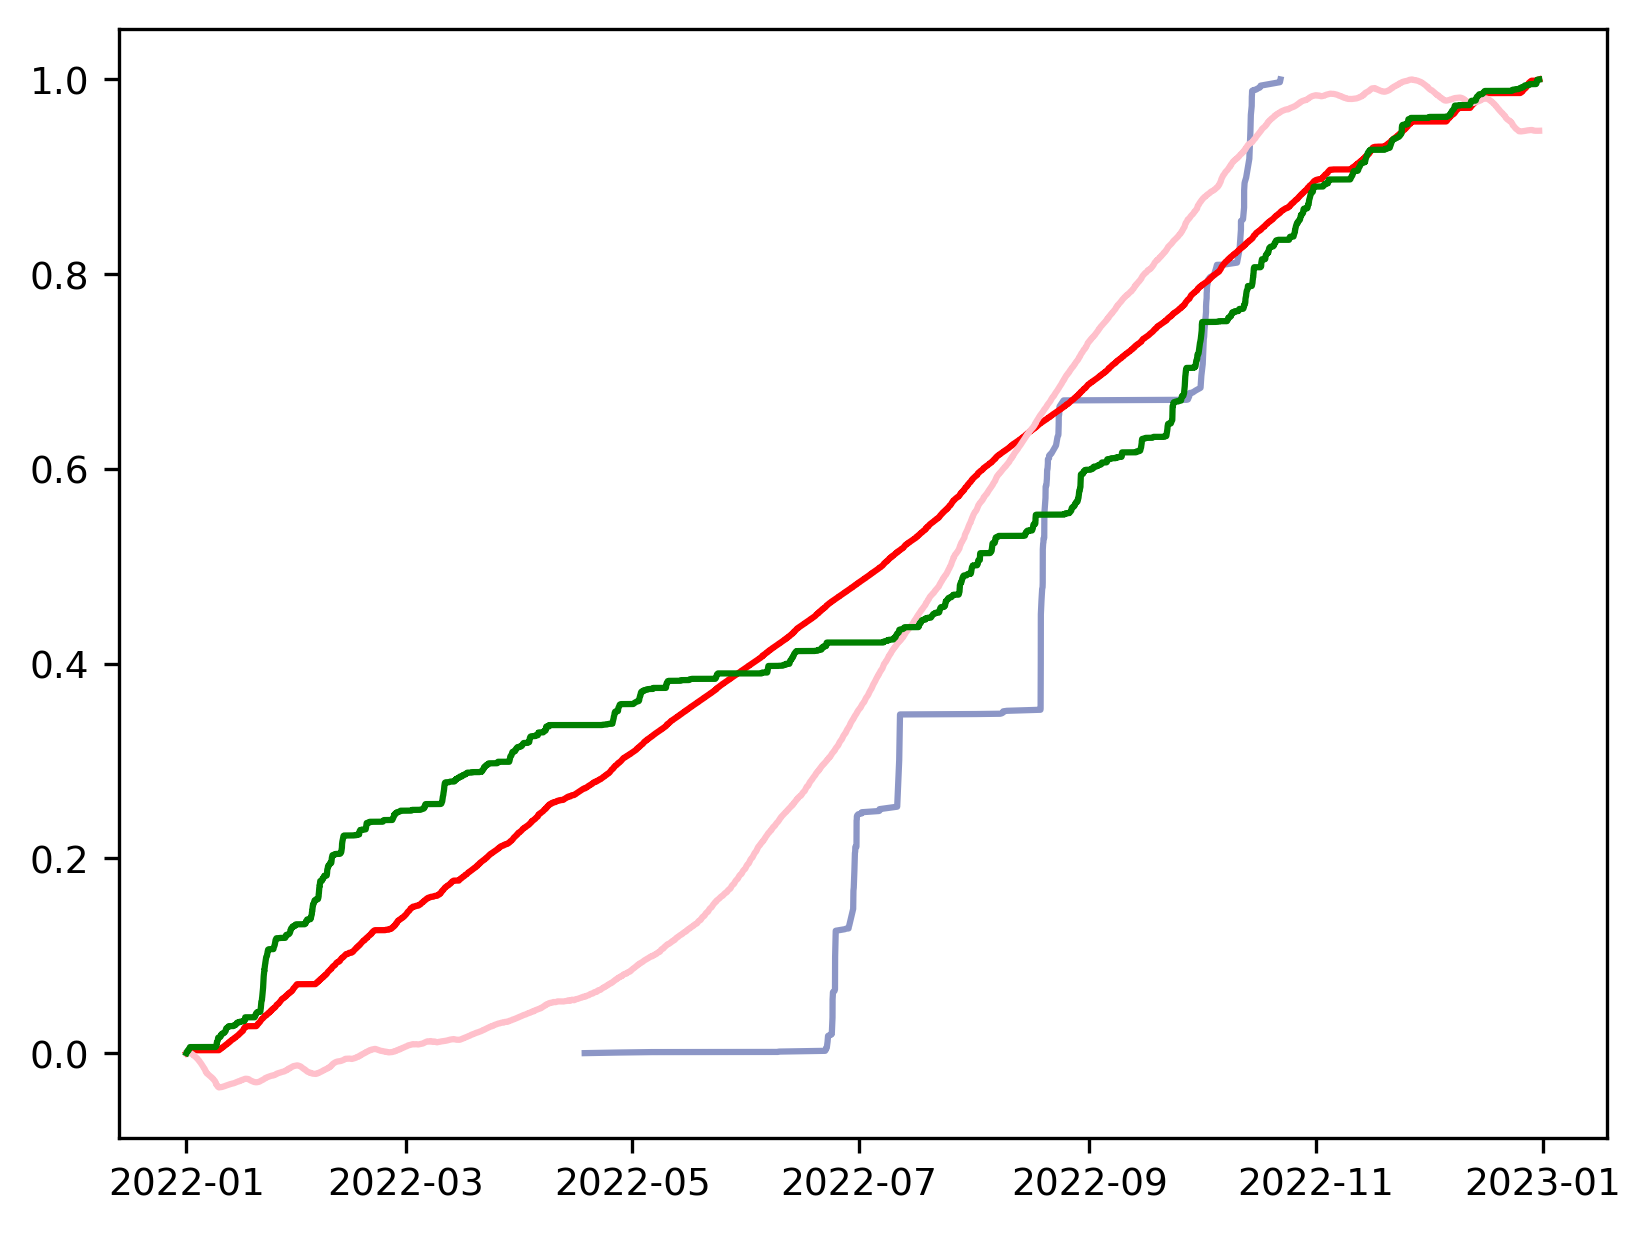

In [56]:
from scipy import integrate

df_Stikcompare = df_Stik[(df_Stik.index >='2022-01-01') & (df_Stik.index <'2022-12-31')]
Stikicequakes = integrate.cumulative_trapezoid(df_Stikcompare['M0'], dx=1, initial=0)
Stikicequakesnorm = Stikicequakes/np.max(Stikicequakes)
df_Stikcompare['cumulativeicequakesnorm'] = Stikicequakesnorm

df_AKJuncompare = df_AKJun[(df_AKJun.index >='2022-01-01') & (df_AKJun.index <'2022-12-31')]
df_AKJuncompare['Precip'] = df_AKJuncompare['Precip'].fillna(0)
cumulative_precip = integrate.cumulative_trapezoid(df_AKJuncompare['Precip'], dx=1, initial=0)
df_AKJuncompare['cumulative_precip'] = cumulative_precip
cumulative_precip_norm = cumulative_precip/np.max(cumulative_precip)
df_AKJuncompare['cumulative_precip_norm'] = cumulative_precip_norm

df_AKJuncompare['TempAboveZero'] = (df_AKJuncompare['TempC'] > 0).astype(int)
cumulative_temp_days = integrate.cumulative_trapezoid(df_AKJuncompare['TempAboveZero'], dx=1, initial=0)
df_AKJuncompare['cumulative_temp_days'] = cumulative_temp_days
df_AKJuncompare['cumulative_temp_days_norm'] = cumulative_temp_days / np.max(cumulative_temp_days)

df_AKJuncompare['TempC'] = df_AKJuncompare['TempC'].fillna(0)

#Cortempd = df_AKCorcompare['TempC'].resample('w').mean(numeric_only=True)
#Cortempd = Cortempd.dropna()
#CorTempdeld = np.gradient(Cortempd, 1)

cumulative_temp = integrate.cumulative_trapezoid(df_AKJuncompare['TempC'], dx=1, initial=0)
#cumulative_temp = integrate.cumulative_trapezoid(CorTempdeld, dx=1, initial=0)
df_AKJuncompare['cumulative_temp'] = cumulative_temp
cumulative_temp_norm = cumulative_temp/np.max(cumulative_temp)
df_AKJuncompare['cumulative_temp_norm'] = cumulative_temp_norm

plt.plot(df_Stikcompare.cumulativeicequakesnorm, color = '#8c96c6')
plt.plot(df_AKJuncompare.cumulative_temp_days_norm, color = 'red')
plt.plot(df_AKJuncompare.cumulative_temp_norm, color = 'pink')
#plt.plot(cumulative_temp_norm, color = 'pink')
plt.plot(df_AKJuncompare.cumulative_precip_norm, color = 'green')

#print(df_AKYakcompare)


C:\Users\alexd\AppData\Local\Temp\ipykernel_45080\284388953.py:1: FutureWarning: 'w' is deprecated and will be removed in a future version, please use 'W' instead.
  df_Stikcompare2 = df_Stikcompare.resample('w').sum()
c:\Users\alexd\anaconda3\envs\Icequake\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\alexd\AppData\Local\Temp\ipykernel_45080\284388953.py:8: FutureWarning: 'w' is deprecated and will be removed in a future version, please use 'W' instead.
  df_AKJuncompare2 = df_AKJuncompare2.resample('w').mean()
C:\Users\alexd\AppData\Local\Temp\ipykernel_45080\284388953.py:13: FutureWarning: 'w' is deprecated and will be removed in a future version, please use 'W' instead.
  df_AKJunprecip2 = df_AKJunprecip2.resample('w').sum()


27
27
27


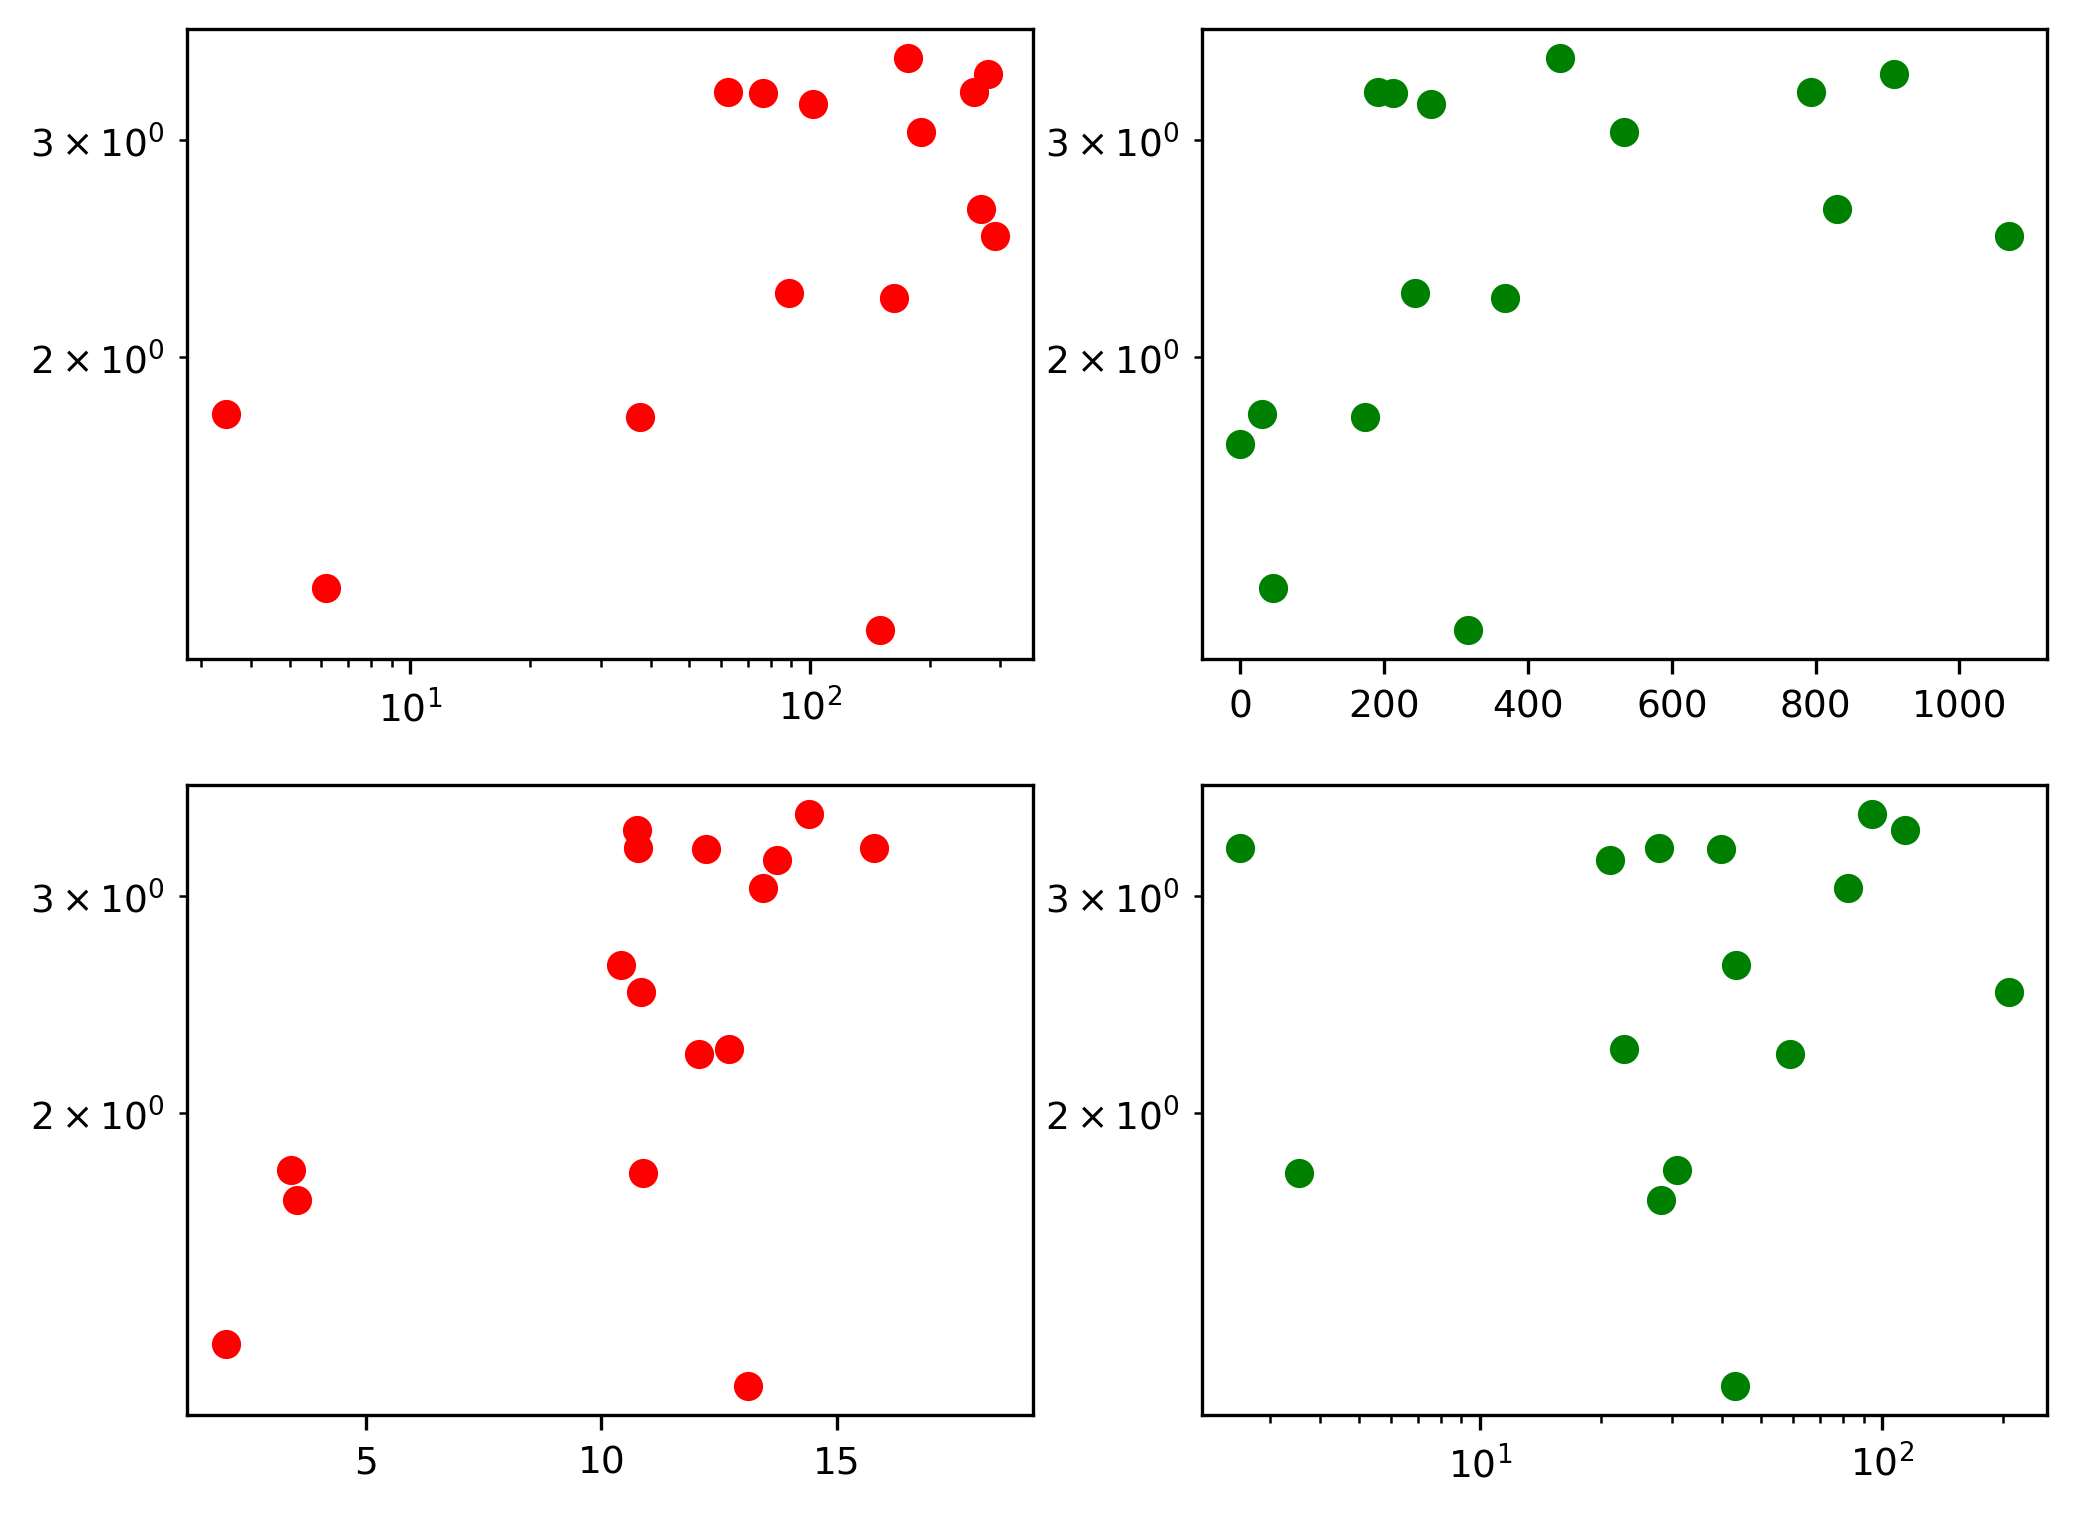

In [65]:
df_Stikcompare2 = df_Stikcompare.resample('w').sum()
df_Stikcompare2['Mwh'] = (np.log10(df_Stikcompare2['M0'])-9.105)/1.5
df_Stikcompare2['Mwh'] = df_Stikcompare2['Mwh'].replace(-np.inf, 0)
df_Stikcompare2['Mwh'] = df_Stikcompare2['Mwh'].fillna(0)
df_Stikcompare2 = df_Stikcompare2.iloc[:27]

df_AKJuncompare2 = df_AKJun[(df_AKJun.index >='2022-04-01') & (df_AKJun.index <'2022-10-31')]
df_AKJuncompare2 = df_AKJuncompare2.resample('w').mean()
df_AKJuncompare2['TempC'] = df_AKJuncompare2['TempC'].dropna()
df_AKJuncompare2 = df_AKJuncompare2.iloc[:27]

df_AKJunprecip2 = df_AKJuncompare[(df_AKJuncompare.index >='2022-04-01') & (df_AKJuncompare.index <'2022-10-31')]
df_AKJunprecip2 = df_AKJunprecip2.resample('w').sum()
df_AKJunprecip2['Precip'] = df_AKJunprecip2['Precip'].dropna()
df_AKJunprecip2 = df_AKJunprecip2.iloc[:27]

print(len(df_AKJuncompare2))
print(len(df_Stikcompare2))
print(len(df_AKJunprecip2))

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(8, 6))

ax1.scatter(integrate.cumulative_trapezoid(df_AKJuncompare2['TempC'], initial = 0), df_Stikcompare2.Mwh, color='red')
ax1.set_yscale('log')
ax1.set_xscale('log')
ax2.scatter(integrate.cumulative_trapezoid(df_AKJunprecip2['Precip'], initial = 0), df_Stikcompare2.Mwh, color = 'green')
ax2.set_yscale('log')
ax1.set_xscale('log')
ax3.scatter(df_AKJuncompare2.TempC, df_Stikcompare2.Mwh, color='red')
ax3.set_yscale('log')
ax4.scatter(df_AKJunprecip2.Precip, df_Stikcompare2.Mwh, color = 'green')
ax4.set_yscale('log')
ax4.set_xscale('log')